# Let's Begin

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
import matplotlib.collections as mcoll
from scipy.interpolate import NearestNDInterpolator
from scipy.stats import norm

from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from coords import *
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from astropy.coordinates import Angle
import astropy.units as u
import cmasher as cmr



import lmfit
from lmfit import minimize, Parameters,create_params,fit_report
from matplotlib.collections import LineCollection


from collections import Counter
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors


In [4]:
plt.style.use('classic')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

    

def rotate(x,y,theta):
    xprime = x*cos(theta) - y*sin(theta)
    yprime = x*sin(theta) + y*cos(theta)
    return xprime, yprime

l_offset = np.radians(-0.0558)
b_offset = np.radians(-0.0462)
x_offset = Rsun*l_offset
y_offset = Rsun*b_offset

#############################
# create class that stores a ring
#############################

class Ring:

    def __init__(self,t,a,bb,z,v0,theta,xyzsun,vxyzsun,alpha):
        self.t     = t
        self.a     = a
        self.bb     = bb
        self.z0    = z
        self.v0    = v0
        self.theta = theta
        self.x     = a*cos(t)
        self.y     = -bb*sin(t)
        self.z     = self.z0*sin(-2*t + alpha)
        self.R     = sqrt(self.x**2+self.y**2)
        self.phi   = -arctan2(self.y,self.x)
        self.ephix = -sin(self.phi) # unit vector parallel to circle
        self.ephiy = -cos(self.phi) # unit vector parallel to circle
        norm       = sqrt((a*sin(t))**2+(bb*cos(t))**2)
        self.ex    = -a*sin(t)/norm # unit vector parellel to ellipse
        self.ey    = -bb*cos(t)/norm  # unit vector parallel to ellipse
        self.cosalpha = self.ex*self.ephix + self.ey*self.ephiy
        self.vphi  = self.R[0]*self.v0/self.R # assume conservation of angular momentum
        self.v     = self.vphi/self.cosalpha # total speed along the orbit
        self.vx    = +self.v*self.ex
        self.vy    = +self.v*self.ey
        self.vz    = np.zeros(t.size)
        self.x,self.y   = rotate(self.x,self.y,theta)
        self.vx,self.vy = rotate(self.vx,self.vy,theta)
        self.X,self.Y,self.Z,self.vX,self.Vy,self.vZ = xyz2XYZ(self.x,self.y,self.z,self.vx,self.vy,self.vz,xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        # Convert Sgr A* offset from degrees to radians
        l_offset = np.radians(0.0558)
        b_offset = np.radians(-0.0462)
        x_offset = Rsun*l_offset
        y_offset = 0
        z_offset = Rsun*b_offset
        # Calculate galactic coordinates accounting for Sgr A* offset
        self.l,self.b,self.r,self.vl,self.vb,self.vr = xyz2lbr(
            self.x,self.y,self.z,self.vx,self.vy,self.vz,
            xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        self.l += l_offset
        self.b += b_offset
        self.x += x_offset
        self.y += y_offset
        self.z += z_offset
        self.mu_l, self.mu_b = vlb_2_mulb(self.r, self.vl*100, self.vb*100)
        self.mu_l, self.mu_b = vlb_2_mulb(self.r,self.vl*100,self.vb*100)

        
#############################
# define sun position & velocity
#############################

xsun  = 0.0
ysun  = -8.2
zsun  = 0.0
vxsun = -2.2
vysun = 0.0
vzsun = 0.0
xyzsun  = [xsun, ysun, zsun ]
vxyzsun = [vxsun,vysun,vzsun]
phisun  = arctan2(ysun,xsun)



In [5]:
def lb_lv_plots(Rings):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    


    ### Plot Rings LB ###
    ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_cat_agg)):
        
        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 0.5
        else:
            marker = 'o'
            alpha =1.

        if plot_cat_agg['NF_decision'][i] == 'N':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[0], s=120 , alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'LN':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[1], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'U':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[2], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'LF':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[3], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'F':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[4], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)


    ### Plot Rings LV ###
    ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 0.5
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] == 'N':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[0], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'LN':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[1], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'U':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[2], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'LF':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[3], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'F':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[4], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)






    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    
    ax[0].text(.9, 1.10, 'a = {:.3f}, b = {:.3f}, z = {:.3f}, v0 = {:.2f}, theta_deg = {:.1f}, red_chisq = {:.2f}'.format(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),out.redchi), fontsize=20, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    
    plt.show()

    return 

In [6]:
def lb_lv_plots_postcolor(Rings,out):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    


    ### Plot Rings LB ###
    ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)


    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    #cmap    = cmr.redshift_r
    cmap    = 'bwr_r'
    for i in range(0,len(plot_cat_agg)):

        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha =1.
            

        if plot_cat_agg['NF_decision'][i] != 'nan':
            sc = ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, 
                           c=plot_post_tab_agg['mu_MC'][i], s=120, 
                           cmap=cmap, norm=divnorm, alpha = alpha)

        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)



    ### Plot Rings LV ###
    ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] != 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, 
                      c=plot_post_tab['mu_MC'][i], s=120, 
                      cmap=cmap, norm=divnorm, alpha = alpha)


        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    cax = fig.add_axes([0.15, 0.97, 0.73, 0.03])
    cb = plt.colorbar(sc, ax=ax[0], orientation='horizontal', cax=cax)   
    ax[0].text(.9, 1.4, 'a = {:.3f}, b = {:.3f}, z = {:.3f}, v0 = {:.2f}, theta_deg = {:.1f}, red_chisq = {:.2f}'.format(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),out.redchi), fontsize=20, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    
    plt.show()

    return 

In [7]:
def load_data(path, sep='\s+', cols=[0,1,2,3],names=['l', 'b', 'v', 'near_far']):
    return pd.read_csv(path, sep=sep, header=None, names=names)
    #lk, bk, vk, NF = data['l'].values, data['b'].values, data['v'].values, data['near_far'].values
    #return data, lk, bk, vk, NF
    #Find near and far point

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_54086/157986325.py:1: SyntaxWarning: invalid escape sequence '\s'
  def load_data(path, sep='\s+', cols=[0,1,2,3],names=['l', 'b', 'v', 'near_far']):


In [8]:
### create a function that is a continuous distribution between NF on the ring itself
# take the y indices of the ring that are in front of the offset = Near; behind = Far
# values are relative weights in the distribution?
'''def ring_NF_dist_y(Rings):
    back_ind = np.where(Rings.y>y_offset)
    fore_ind = np.where(Rings.y<=y_offset)

    y_NF =  Rings.y.copy()
    y_NF=np.where(Rings.y>y_offset,y_NF,-(Rings.y - np.nanmin(Rings.y[back_ind]) )/ (np.nanmax(Rings.y[back_ind]) - np.nanmin(Rings.y[back_ind])))
    y_NF=np.where(Rings.y<=y_offset,y_NF,(Rings.y - np.nanmax(Rings.y[fore_ind]) )/ (np.nanmin(Rings.y[fore_ind]) - np.nanmax(Rings.y[fore_ind])))
    #y_NF=np.where(Rings.y<y_offset,y_NF,-1)
    #y_NF=np.where(Rings.y>=y_offset,y_NF,1)

    return back_ind, fore_ind, y_NF
'''
def ring_NF_dist_y(Rings):
    back_ind = np.where(Rings.y>y_offset)
    fore_ind = np.where(Rings.y<=y_offset)

    y_NF =  Rings.y.copy()
    y_NF[back_ind] = -(Rings.y[back_ind] - y_offset )/ (Rings.y[back_ind].max() - y_offset)
    y_NF[fore_ind] = 1 - ((Rings.y[fore_ind] - np.nanmin(Rings.y[fore_ind]) )/ (y_offset-np.nanmin(Rings.y[fore_ind])))
    #y_NF=np.where(Rings.y>y_offset,y_NF,-(Rings.y - y_offset )/ (Rings.y[back_ind].max() - y_offset))
    #y_NF=np.where(Rings.y<=y_offset,y_NF,(Rings.y - np.nanmax(Rings.y[fore_ind]) )/ (np.nanmin(Rings.y[fore_ind]) - np.nanmax(Rings.y[fore_ind])))


    return back_ind, fore_ind, y_NF


def ring_NF_dist(Rings):
    back_ind = np.where(Rings.r>=8.2)
    fore_ind = np.where(Rings.r<8.2)

    y_NF =  Rings.r.copy()
    y_NF[back_ind] = -(Rings.r[back_ind] - 8.2 )/ (np.nanmax(Rings.r[back_ind]) - 8.2)
    y_NF[fore_ind] =  1-(Rings.r[fore_ind] - np.nanmin(Rings.r[fore_ind]) )/ (8.2 - np.nanmin(Rings.r[fore_ind]))
    #y_NF=np.where(Rings.y<y_offset,y_NF,-1)
    #y_NF=np.where(Rings.y>=y_offset,y_NF,1)

    return back_ind, fore_ind, y_NF

def calculate_mahalanobis_distances(data, model):
    cov = np.cov(data.T) 
    inv_cov = np.linalg.inv(cov)
    distances = cdist(data, model, metric='mahalanobis', VI=inv_cov)
    return distances, inv_cov


def min_distance_mahalanobis(data, model):

    # compute distances for every point on the stream
    dist, inv_cov = calculate_mahalanobis_distances(data, model)

    # find the minima 
    glob_min_idxs =[]
    for i in range(len(data)):
        glob_min_idxs.append(np.argwhere(dist[i]==np.min(dist[i])).ravel()[0])
    return glob_min_idxs, dist #returns all distance values and minima index

def normalizelbv(l,b,v):
    lmin, lmax = -0.6, 1.7
    bmin, bmax = -0.3, 0.1
    vmin, vmax = -110., 100.
    
    #using approximate extents of the data in l,b,v to normalize between -1 and 1
    norml = 2*((l - lmin) / (lmax - lmin)) -1. 
    normb = 2*((b - bmin) / (bmax - bmin)) -1. 
    normv = 2*((v - vmin) / (vmax - vmin)) -1. 
    
    return norml,normb,normv

def distancelbv(l, b, v, l0, b0, v0):
    #typical Cartesian distance measurement 
    d_l = l - l0
    d_b = b - b0
    d_v = v - v0
    dis = np.sqrt( d_l**2 + d_b**2 + d_v**2)
    return dis


def min_distancelbv(streaml, streamb, streamv, P):
    """
    Compute minimum/a distance/s between
    a point P[x0,y0,z0] and a curve (x,y,z).
    
    Returns min indexes and distances array.
    """
    # compute distances for every point on the stream
    d = distancelbv(streaml, streamb, streamv, P[0], P[1], P[2])

    # find the minima 
    glob_min_idxs = np.argwhere(d==np.min(d)).ravel()
    return glob_min_idxs, d #returns all distance values and minima index


#Gaussian function for the PPDF distributions (used in KNN search)
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2.* (sigma**2 )))

#Save normed data as a class
class norm_data:    
    def __init__(self, norml0, normb0, normv0, NF):
        self.l0 = norml0
        self.b0 = normb0
        self.v0 = normv0
        self.NF = NF #Cloud NF is decided from the PPDF centers, already normalized to [-1,1]

In [9]:
def normalizelbv(l,b,v):
    lmin, lmax = -0.6, .7
    bmin, bmax = -0.3, 0.1
    vmin, vmax = -110., 100.
    
    #using approximate extents of the data in l,b,v to normalize between -1 and 1
    norml = 2*((l - lmin) / (lmax - lmin)) -1. 
    normb = 2*((b - bmin) / (bmax - bmin)) -1. 
    normv = 2*((v - vmin) / (vmax - vmin)) -1. 
    
    return norml,normb,normv

norml0, normb0, normv0 = normalizelbv(cat_tab['l'],cat_tab['b'], cat_tab['v'])



NameError: name 'cat_tab' is not defined

In [293]:
Rings_three = Ring(phi,
                  0.09 ,
                  0.055 ,
                  0.0125 ,
                  130 , 
                  np.radians(25 ),
                  xyzsun,vxyzsun,
                  0.4)

back_ind, fore_ind, y_NF=ring_NF_dist_y(Rings_three)
print(Rings_three.y.argmax(),y_NF.argmin(), Rings_three.y[Rings_three.y.argmax()], y_NF[Rings_three.y.argmax()])

print(Rings_three.y.argmin(), y_NF.argmax(),Rings_three.y[Rings_three.y.argmin()], y_NF[Rings_three.y.argmin()])

y_NF[fore_ind].max(), y_NF[back_ind].min()
#y_NF[np.where(Rings_three.y > 0.8*Rings_three.y.min())[0][0]]
#Rings_three.y[Rings_three.y.argmin()-100000], y_NF[Rings_three.y.argmin()-100000], y_offset

37345 37345 0.06270108803209837 -1.0
217345 217345 -0.06270108803209837 1.0


(np.float64(1.0), np.float64(-1.0))

In [10]:
def normedr_to_pc(r, A):
    '''takes in a normalized LOS position, r in (-1,1) scaling, 
    as well as a normalization constant A (in pc) that corresponds to the radius of the ellipse.
    returns top-down y value for distance from SgrA* in PARSECS
    
    y < 0 in NEAR, y>0 is FAR
    
    '''
    
    return A*r

# LMFIT time

In [11]:
###Read in data to scatter plot in lbv 
cat_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
post_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex")

##remove the rows with NaN NF decisions 
non_fitting_rows = list(np.where(cat_tab['NF_decision']=='nan')[0])
pixel_masked_rows =  np.where(cat_tab['lb_pixel_mask']==0)[0]

for i in pixel_masked_rows:
    if i not in non_fitting_rows:
        non_fitting_rows.append(i)

#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='12')[0][0]))

non_fitting_rows.append((np.where(cat_tab['leaf_id']=='10')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='9')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='13')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='14')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='8b')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='8c')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='11b')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='11c')[0][0]))

post_tab.remove_rows(non_fitting_rows)
cat_tab.remove_rows(non_fitting_rows)

cat_index = cat_tab['leaf_id']
cloud_name = cat_tab['cloud_name']
NF_decision = cat_tab['NF_decision']
lb_pixel_mask = cat_tab['lb_pixel_mask']

post_A = post_tab['A_MC']
post_mu = post_tab['mu_MC']
post_sigma = post_tab['sigma_MC']



## aggregate table that pulls out the largest mask
## to represent the l,b N/F/U position

cat_group = cat_tab.group_by('lb_pixel_mask')
cat_group_mask = cat_group.groups.keys['lb_pixel_mask'] == 1

cat_agg = cat_group.groups[cat_group_mask]


## For plotting only
plot_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
plot_cat_group = plot_tab.group_by('lb_pixel_mask')
plot_cat_group_mask = plot_cat_group.groups.keys['lb_pixel_mask'] == 1
plot_cat_agg = plot_cat_group.groups[plot_cat_group_mask]
plot_post_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex")
plot_post_tab_agg = plot_post_tab[np.where(plot_tab['lb_pixel_mask']==1)]



In [12]:
####################################################
### Pre-process the DATA to normalize to [-1,1] ###
####################################################
norml0, normb0, normv0 = normalizelbv(cat_tab['l'],cat_tab['b'], cat_tab['v'])
Ndata = norm_data(norml0, normb0, normv0, post_mu)

norml0.max()

np.float64(1.0246153846153847)

In [13]:
params = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.055  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True},
                       alpha_rings={'value': 0.4  , 'min': 0, 'max': np.pi, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )

params_OFF = create_params(a_rings={'value': 0.1   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.1  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 110.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 30  , 'min': 15, 'max': 360, 'vary': True},
                       alpha_rings={'value': 0.4  , 'min': 0, 'max': np.pi, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )

params_dphi = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.055  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': True}
                          )



In [298]:
#############################
###Uncertainty of fitting?###
#############################
# Store the y-axis top-down values of all of the pc LOS distances 
# from each iteration of the fitting for each cloud.
# Then we'll make a histogram of the various distances for each cloud,
# and get the uncertainties in pc?

res = minimize(ring_resid, method='emcee', nan_policy='omit', args=(Ndata.l0,Ndata.b0,Ndata.v0), burn=300, steps=1000, thin=20,
                     params=params, is_weighted=False, progress=True)

0.09 0.055 0.0125 0.6111111111111112
0.13981264581029934 0.4892406425687187 0.9607947440113154 0.8301947551723227 0.05681329601284947 0.6290532883790181
2.282996671130876

0.08999032798402501 0.05499897835523263 0.012500899108344815 0.6111654395236341
emcee: Exception while calling your likelihood function:
  params: [8.99903280e-02 5.49989784e-02 1.25008991e-02 1.30002330e+02
 2.49991582e+01 4.00036549e-01 9.99996097e-03]
  args: (<function ring_resid at 0x1987ad260>, Parameters([('a_rings', <Parameter 'a_rings', value=np.float64(0.08999032798402501), bounds=[0.01:0.3]>), ('b_rings', <Parameter 'b_rings', value=np.float64(0.05499897835523263), bounds=[0.01:0.2]>), ('z_rings', <Parameter 'z_rings', value=np.float64(0.012500899108344815), bounds=[0.0:0.05]>), ('v_rings', <Parameter 'v_rings', value=np.float64(130.00232984089877), bounds=[100.0:150.0]>), ('theta_rings', <Parameter 'theta_rings', value=np.float64(24.99915818745133), bounds=[0:180]>), ('alpha_rings', <Parameter 'alpha_ring

Traceback (most recent call last):
  File "/opt/anaconda3/envs/python3_13/lib/python3.13/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/python3_13/lib/python3.13/site-packages/lmfit/minimizer.py", line 1086, in _lnprob
    out = userfcn(params, *userargs, **userkwargs)
  File "/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_17734/2598658821.py", line 20, in ring_resid
    Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings, np.radians(theta_rings),xyzsun,vxyzsun,alpha_rings)
  File "/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_17734/2870402379.py", line 60, in __init__
    self.l,self.b,self.r,self.vl,self.vb,self.vr = xyz2lbr(
                                                   ~~~~~~~^
        self.x,self.y,self.z,self.vx,self.vy,self.vz,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        xyzsun[0],xyzsun[1],xyzsun[2],vxy

KeyboardInterrupt: 

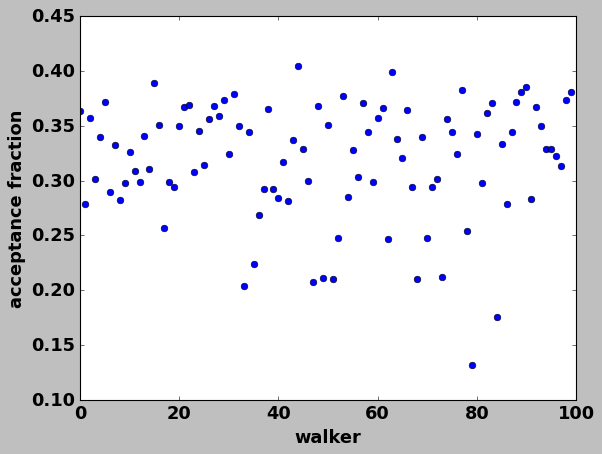

In [ ]:
plt.plot(res.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

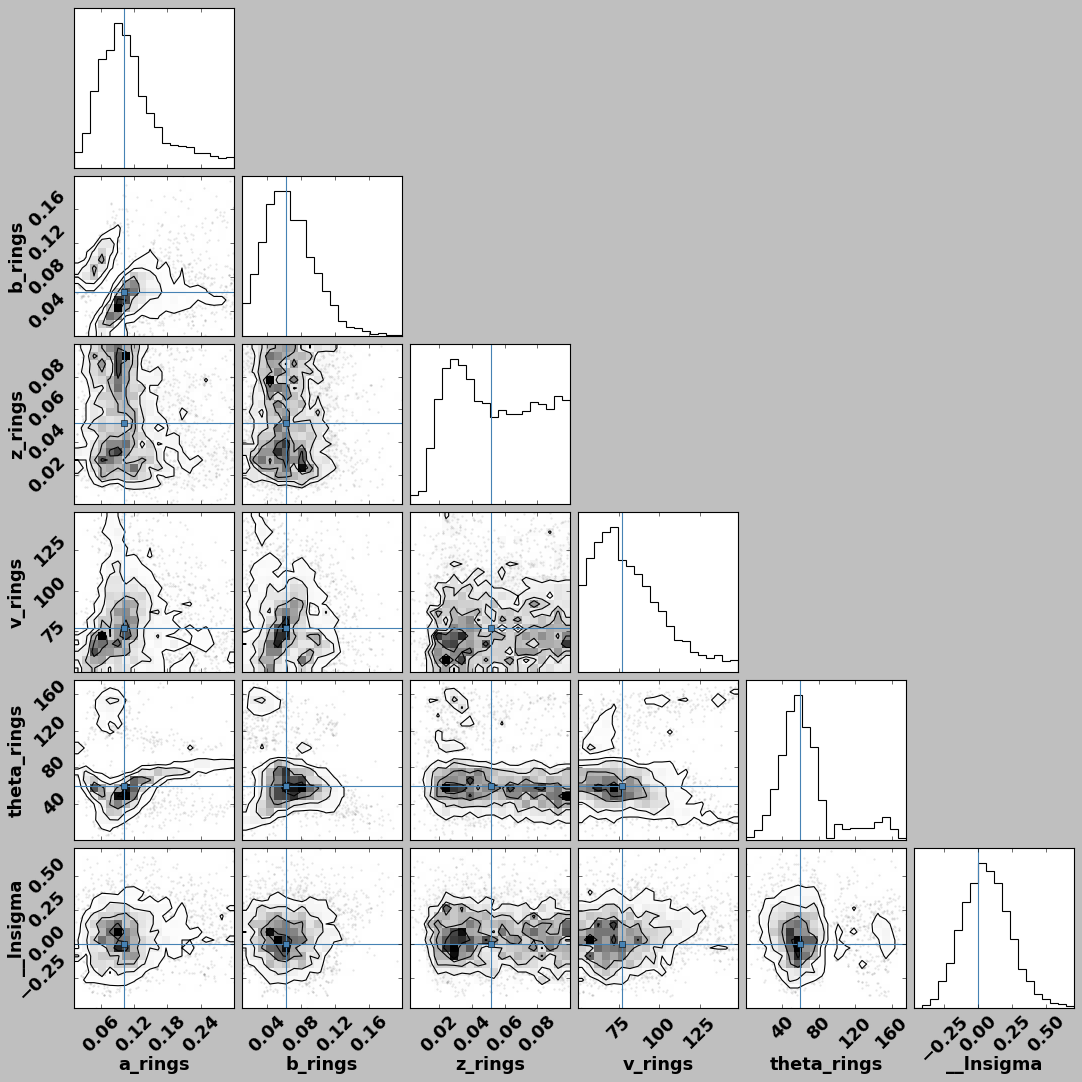

In [ ]:
import corner

emcee_plot = corner.corner(res.flatchain, labels=res.var_names,
                           truths=list(res.params.valuesdict().values())[0:-1])

In [ ]:


def ring_resid(params, l,b,v):
    
    a_rings=params['a_rings']
    b_rings=params['b_rings']
    z_rings=params['z_rings']
    v_rings=params['v_rings']
    theta_rings=params['theta_rings']
    alpha_rings=params['alpha_rings']
    ddphi=params['ddphi']
    
    dphi = np.radians(ddphi)
    phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
    
    Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings, np.radians(theta_rings),xyzsun,vxyzsun,alpha_rings)
            
    ### Pre-process the given MODEL; normalize to [-1,1] ###
    normELL_l, normELL_b, normELL_v = normalizelbv(np.degrees(Rings.l),np.degrees(Rings.b),Rings.vr)
    back_ind, fore_ind, y_NF = ring_NF_dist_y(Rings) #finds the N/F on the ellipse
    Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)
    
    
    ### Perform KNN search on the model and find the neighbor distances and indices in the model
    nn = NearestNeighbors(n_neighbors=int(np.sqrt(len(Nrings.l0))), metric='minkowski')
    nn.fit(np.vstack([Nrings.l0,Nrings.b0,Nrings.v0,Nrings.NF]).T)
    distances, indices = nn.kneighbors(np.vstack([Ndata.l0,Ndata.b0,Ndata.v0,Ndata.NF]).T)
    
    
    ### for each catalogue point, find the minimum residual between pt and the ellipse
    #   and save the min to array
    min_d_list = []
    nf_penalty_list = [] #saves how closely the nearest point matches the NF position posterior based on KNN search
    
    model_data = np.vstack([Nrings.l0,Nrings.b0,Nrings.v0]).T
    cat_data = np.vstack([Ndata.l0,Ndata.b0,Ndata.v0]).T
    glob_min_idxs, dist_lbv = min_distance_mahalanobis(cat_data,model_data)
    
    cat_los_i = [] #list for values of LOS in parsec for each cloud
    
    for i in range(len(cat_data)):

        ### store min distance into the min dist list ###
        min_d_list.append(dist_lbv[i][glob_min_idxs[i]])
        
        
        
        ### Find how well each point agrees with the N/F degree of the model ellipse ###
        
        idx=indices[i]
        dist = distances[i]
        neighbors_nf = Nrings.NF[idx]
        common_nf = Counter(neighbors_nf).most_common(1)[0][0]
        post_dist_value = gaussian(common_nf ,post_A[i],post_mu[i],post_sigma[i])

        if common_nf > post_mu[i]:
            area_between = abs(norm.cdf(common_nf, loc=post_mu[i], scale=abs(post_sigma[i]) )- 0.5)
        if common_nf < post_mu[i]:
            area_between = abs(0.5 - norm.cdf(common_nf, loc=post_mu[i], scale=abs(post_sigma[i]) ))
        if i == 17:
 
            print(min_d_list[i],area_between,common_nf, post_mu[i],post_sigma[i],(min_d_list[i]+area_between))
            #print(Ndata.l0[np.argmax(Ndata.NF)], Nrings.l0[np.argmax(Nrings.NF)])
        #nf_penalty = post_A[i] - post_dist_value #this fits by seeing how close the point is to the peak on the posterior curve
        nf_penalty = abs(post_mu[i] - common_nf) #this fits by comparing how offset the point is from the center of the gaussian
        nf_penalty_list.append(area_between )  
        #print(min_d_list[i],abs(nf_penalty) )
    lists_of_lists = [min_d_list, nf_penalty_list]
    resid_list = [sum(x) for x in zip(*lists_of_lists)] #add the values of the lists together
    #resid_list = [x[0]/x[1] for x in zip(*lists_of_lists)]
    return resid_list
    

In [14]:


def ring_resid(params, l,b,v):
    
    a_rings=params['a_rings']
    b_rings=params['b_rings']
    z_rings=params['z_rings']
    v_rings=params['v_rings']
    theta_rings=params['theta_rings']
    alpha_rings=params['alpha_rings']
    ddphi=params['ddphi']
  
    '''if a_rings.value<b_rings.value:
        print('XXXXX', a_rings.value,b_rings.value, z_rings.value, b_rings.value/a_rings.value)
    else:
        print(a_rings.value,b_rings.value, z_rings.value,theta_rings.value, b_rings.value/a_rings.value)
    '''

    dphi = np.radians(ddphi)
    phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
    
    Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings, np.radians(theta_rings),xyzsun,vxyzsun,alpha_rings)
            
    ### Pre-process the given MODEL; normalize to [-1,1] ###
    normELL_l, normELL_b, normELL_v = normalizelbv(np.degrees(Rings.l),np.degrees(Rings.b),Rings.vr)
    back_ind, fore_ind, y_NF = ring_NF_dist_y(Rings) #finds the N/F on the ellipse
    Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)
    
    
    ### Perform KNN search on the model and find the neighbor distances and indices in the model
    nn = NearestNeighbors(n_neighbors=int(np.sqrt(len(Nrings.l0))), metric='minkowski')
    nn.fit(np.vstack([Nrings.l0,Nrings.b0,Nrings.v0,Nrings.NF]).T)
    distances, indices = nn.kneighbors(np.vstack([Ndata.l0,Ndata.b0,Ndata.v0,Ndata.NF]).T)
    
    
    ### for each catalogue point, find the minimum residual between pt and the ellipse
    #   and save the min to array
    min_d_list = []
    nf_penalty_list = [] #saves how closely the nearest point matches the NF position posterior based on KNN search
    
    model_data = np.vstack([Nrings.l0,Nrings.b0,Nrings.v0]).T
    cat_data = np.vstack([Ndata.l0,Ndata.b0,Ndata.v0]).T
    glob_min_idxs, dist_lbv = min_distance_mahalanobis(cat_data,model_data)
    cat_los_i = [] #list for values of LOS in parsec for each cloud
    
    for i in range(len(cat_data)):

        ### store min distance into the min dist list ###
        min_d_list.append(dist_lbv[i][glob_min_idxs[i]])
        
        
        ### Find how well each point agrees with the N/F degree of the model ellipse ###
        
        idx=indices[i]
        dist = distances[i]
        neighbors_nf = Nrings.NF[idx]
        #common_nf = Counter(neighbors_nf).most_common(1)[0][0]

        common_nf = Nrings.NF[glob_min_idxs[i]]

        post_dist_value = gaussian(common_nf ,post_A[i],post_mu[i],post_sigma[i])

        if common_nf > post_mu[i]:
            area_between = abs(norm.cdf(common_nf, loc=post_mu[i], scale=abs(post_sigma[i]) )- 0.5)
        if common_nf < post_mu[i]:
            area_between = abs(0.5 - norm.cdf(common_nf, loc=post_mu[i], scale=abs(post_sigma[i]) ))
       
       
       
        #if i == 17:
        #    print(Ndata.l0[i],Nrings.l0[glob_min_idxs[i] ],Counter(neighbors_nf).most_common(1)[0][0])
         #   print(min_d_list[i],area_between,common_nf, post_mu[i],post_sigma[i],(min_d_list[i]+area_between))


        #nf_penalty = post_A[i] - post_dist_value #this fits by seeing how close the point is to the peak on the posterior curve
        nf_penalty = abs(post_mu[i] - common_nf) #this fits by comparing how offset the point is from the center of the gaussian
        #nf_penalty_list.append(area_between+post_sigma[i])  
        nf_penalty_list.append(area_between*(1+post_sigma[i])  )
        #print(min_d_list[i],abs(nf_penalty) )

    lists_of_lists = [min_d_list, nf_penalty_list]
    resid_list = [sum(x) for x in zip(*lists_of_lists)] #add the values of the lists together
    #resid_list = [(x[0] * (1+x[1])) for x in zip(*lists_of_lists)]
    #print(np.sum([x**2 for x in resid_list])/(22-6))
    #print('')
    return resid_list
    

In [ ]:
params = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       #b_rings={'value': 0.1  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0, 'max': 0.025, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True},
                       alpha_rings={'value': 0.4  , 'min': -3, 'max': 3, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )
params.add('b_rings', value=0.61*params['a_rings'].value, min=0.01, max=0.2, vary=True)
#params.add('alpha_rings', value=0.3904+(((params['a_rings'].value-0.010)/0.005)*0.0006), min= 0, max= np.pi/2, vary=False)

#params.add('b_rings', value=0.055, min=0.01, max=0.2, vary=True)

out = minimize(ring_resid, params, method='nelder', args=(Ndata.l0,Ndata.b0,Ndata.v0))



In [367]:
0.0125/.09

0.1388888888888889

In [417]:
out.residual

array([0.72586261, 1.71126756, 0.57511578, 2.0580699 , 0.79349008,
       2.06123133, 0.75532251, 0.81635125, 1.59724752, 2.1602351 ,
       1.22249454, 1.70455161, 1.19126496, 2.63964747, 0.7787057 ,
       1.6576524 , 0.52790629, 0.67006542, 0.64830484, 0.86343692,
       0.99638064, 2.02343269])

In [421]:
out


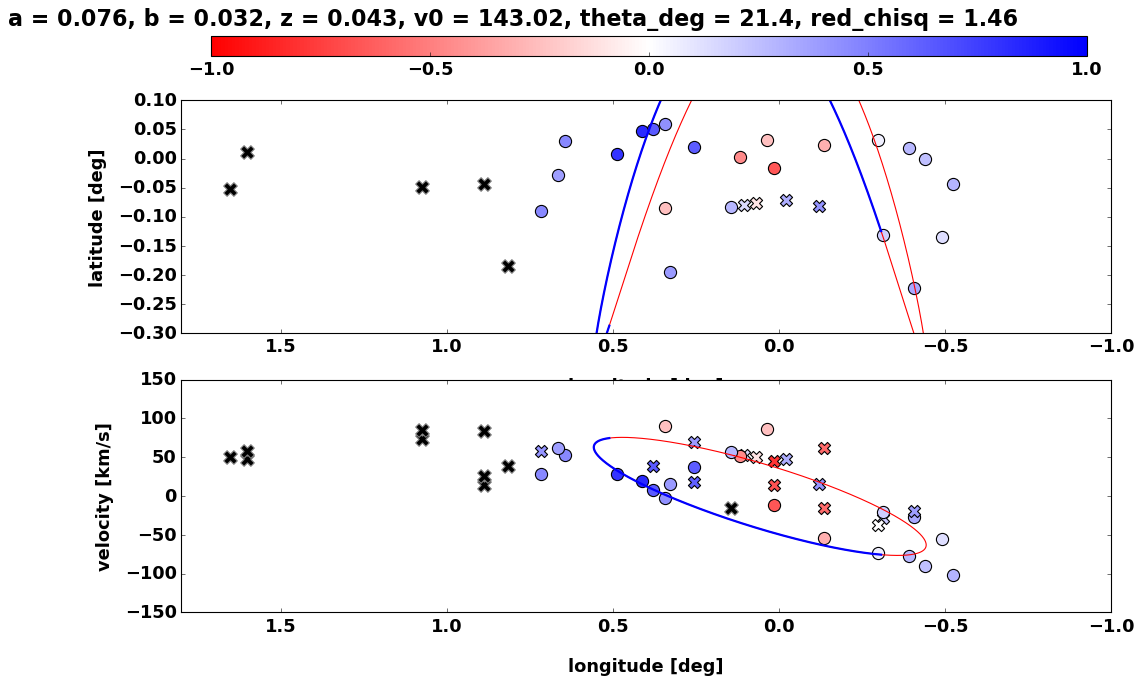

In [422]:
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)

Rings_out = Ring(phi,
                  out.params['a_rings'].value,
                  out.params['b_rings'].value,
                  out.params['z_rings'].value,
                  out.params['v_rings'].value, 
                  np.radians(out.params['theta_rings'].value),
                  xyzsun,vxyzsun,
                  out.params['alpha_rings'].value)

Rings_out_redo = Ring(phi,
                  0.135 ,
                  0.092 ,
                  0.016 ,
                  128.1 , 
                  np.radians(22.9 ),
                  xyzsun,vxyzsun,
                  0.116)

"""

Rings_out_avg = Ring(phi,
                  0.155 ,
                  0.117 ,
                  0.016 ,
                  129.8 , 
                  np.radians(33.8 ),
                  xyzsun,vxyzsun,)




Rings_out = Ring(phi,
                  0.136,
                  0.103,
                  0.013,
                  130.6, 
                  np.radians(40.2),
                  xyzsun,vxyzsun)
"""
'''
Rings_out_off = Ring(phi,
                  out_off.params['a_rings'].value,
                  out_off.params['b_rings'].value,
                  out_off.params['z_rings'].value,
                  out_off.params['v_rings'].value, 
                  np.radians(out_off.params['theta_rings'].value),
                  xyzsun,vxyzsun)'''

lb_lv_plots_postcolor(Rings_out, out)
#lb_lv_plots_postcolor(Rings_out_off, out_off)

#Save output to dat files
list(vars(Rings_out).items())

save_Rings_out = Table()
Rings_out_fit_params = Table()

for i in list(vars(Rings_out).items()):
    if i[0] in ['x', 'y', 'z', 'R', 'phi', 'v', 'vx', 'vy', 'vz', 'l', 'b', 'r', 'vl', 'vb', 'vr' ]:
        save_Rings_out[i[0]] = i[1]
    if i[0] in ['a','bb','z0','v0','theta']:
        Rings_out_fit_params[i[0]] = [i[1]]
        
#ascii.write(save_Rings_out, "/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/Rings_out.dat", overwrite=True)  
#ascii.write(Rings_out_fit_params,"/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/Rings_out_params.dat", overwrite=True)


In [315]:
for i in list(vars(Rings_out).items()):
    if i[0] in ['a','bb','z0','v0','theta']:
        print(i)

('a', np.float64(0.14977032232558724))
('bb', np.float64(0.09777486737972543))
('z0', np.float64(0.011858185784787227))
('v0', np.float64(129.3423161662161))
('theta', np.float64(0.7217489679847374))


# Bold Line Plots

In [15]:
#scouse data for LV 
scouse_fits = pd.read_csv('../CMZ_datasets/final_cmz_scouse_hnco_fits.csv',
              usecols=[0,1,2,3,5,7], names=['n', 'l', 'b', 'amp', 'velocity', 'FWHM'],
              sep="\s+")

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_54086/3215178084.py:4: SyntaxWarning: invalid escape sequence '\s'
  sep="\s+")


In [16]:
def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

In [17]:
def lb_lv_plots_postcolor_grad(Rings, out='None', scouse_on='None', output_save = 'None'):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    
    ringcmap = 'bwr_r' #cmr.prinsenvlag


    ### Plot Rings LB ###
    sgra = ax[0].scatter(-0.0558, -0.0462,marker = '*', s=150 ,color = 'k',zorder=10)
    ringcolor = ring_NF_dist(Rings)[2]
    lines = colored_line(np.degrees(Rings.l),np.degrees(Rings.b), ringcolor, ax[0], linewidth=5, cmap=ringcmap,zorder=1)

    #ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    #ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)


    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    #cmap    = cmr.redshift_r
    cmap    = 'bwr_r'
    for i in range(0,len(plot_cat_agg)):

        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha =1.
            

        if plot_cat_agg['NF_decision'][i] != 'nan':
            sc = ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, 
                           c=plot_post_tab_agg['mu_MC'][i], s=120, 
                           cmap=cmap, norm=divnorm, alpha = alpha)

        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)



    ### Plot Rings LV ###
    ringcolor = ring_NF_dist(Rings)[2]
    lines = colored_line(np.degrees(Rings.l),Rings.vr, ringcolor, ax[1], linewidth=5, cmap=ringcmap,zorder=1)

    #ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    #ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] != 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, 
                      c=plot_post_tab['mu_MC'][i], s=120, 
                      cmap=cmap, norm=divnorm, alpha = alpha)


        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)

    if scouse_on == True:
        l   = scouse_fits['l'].values
        b   = scouse_fits['b'].values
        v   = scouse_fits['velocity'].values
        amp = scouse_fits['amp'].values

        #ax[0].scatter(l, b, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
        #        norm=mpl.colors.LogNorm(), alpha=0.1, zorder=0)
        ax[1].scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
                norm=mpl.colors.LogNorm(), alpha=0.1, zorder=0)


    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    cax = fig.add_axes([0.15, 0.97, 0.73, 0.03])
    cb = plt.colorbar(sc, ax=ax[0], orientation='horizontal', cax=cax)  
    if out =='None':
        ax[0].text(.9, 1.4, r'a = %.3f, b = %.3f, z$_{0}$ = %.3f, v$_{0}$ = %.2f, $\theta$ = %.1f' %(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta)), fontsize=20, ha='right', va='top', 
            transform=ax[0].transAxes)

    else:  
        ax[0].text(.9, 1.4, r'a = %.3f, b = %.3f, z$_{0}$ = %.3f, v$_{0}$ = %.2f, $\theta$ = %.1f, $\chi^{2}_{\mathrm{red}}$ = %.2f' %(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),out.redchi), fontsize=20, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    #cax2 = fig.add_axes([.97, 0.1, 0.03, 0.8])
    #cb2 = plt.colorbar(lines, orientation='vertical', cax=cax2)
    #cb2.set_label('Ring LOS N/F', rotation=270)

    if output_save != 'None':
        plt.savefig(output_save, bbox_inches='tight')   
    
    plt.show()





/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_72191/1389427420.py:85: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax[1].scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',


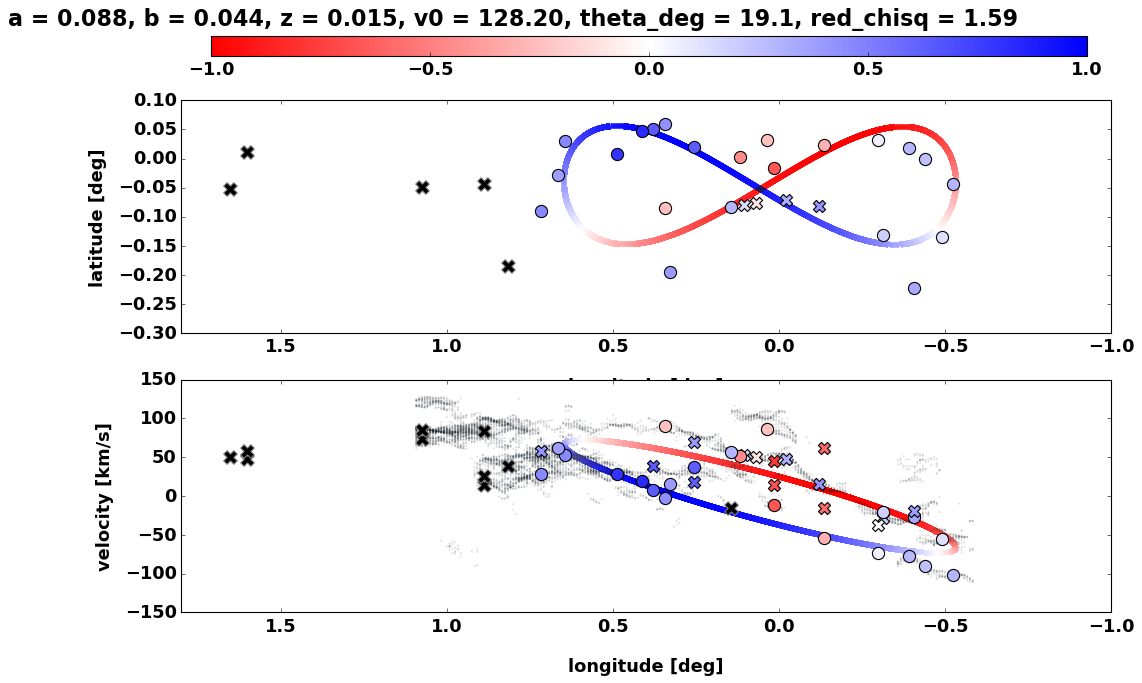

In [ ]:

lb_lv_plots_postcolor_grad(Rings_out, scouse_on=True, output_save='./paper_items/Figs/paper3_ellipse_fit_output.pdf')
#lb_lv_plots_postcolor_grad(Rings_out_off, out_off)


/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_97538/4004893707.py:88: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax[1].scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',


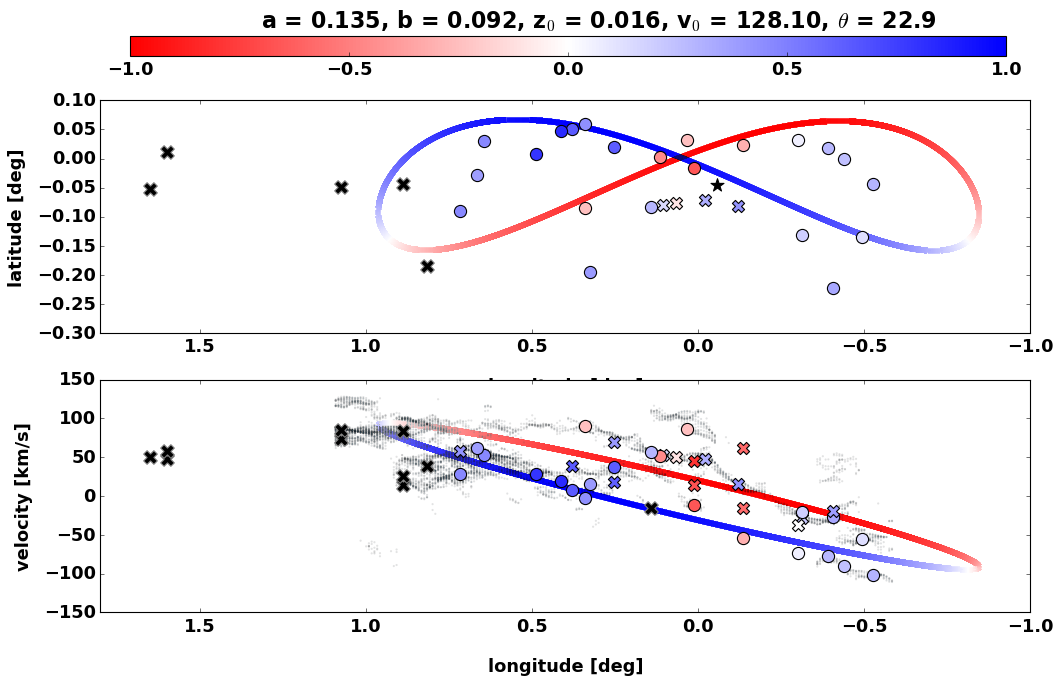

In [ ]:
lb_lv_plots_postcolor_grad(Rings_out_redo, scouse_on=True,output_save='./paper_items/Figs/final_output_ellipse_fit_LBLV.pdf')


# Top-down visualizations!

In [18]:
def denorm_yNF_value(y_NF, Rings_out):
        
    """This function takes in a normalized array (-1,1) and converts it to a top-down y-axis
    distance from SgrA* based on that output from the best fitting x2 ellipse (Rings_out).
    
    Negative values are on the NEAR SIDE in front of SgrA*
    Positive values are on the FAR SIDE behind SgrA*
    
    Results are in kiloparsecs!! 
    """
    
    term1 = (y_NF + 1)/2
    term2 = (np.nanmax(Rings_out.r) - np.nanmin(Rings_out.r))
    
    real_y = (term1*term2) + np.nanmin(Rings_out.r)

    #returns the LOS distance on the ring from SgrA* in kpc
    return real_y

def denorm_sigma_value(NFsigma, Rings_out):

    minkpc =  8.2 - np.nanmin(Rings_out.r)
    maxkpc =  8.2 - np.nanmax(Rings_out.r)
    widthkpc = minkpc - maxkpc
    
    term1 = (NFsigma)
    term2 = widthkpc
    
    real_sig = (term1*term2) 

    #returns the LOS distance on the ring from SgrA* in kpc
    return real_sig




In [ ]:
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
Rings_inner = Ring(phi,
                  0.095,
                  0.061,
                  0.008,
                  110.2, 
                  np.radians(24.0),
                  xyzsun,vxyzsun)

Rings_avg = Ring(phi,
                  0.136,
                  0.103,
                  0.013,
                  130.6, 
                  np.radians(40.2),
                  xyzsun,vxyzsun)

Rings_outer = Ring(phi,
                  0.161,
                  0.124,
                  0.017,
                  143.6, 
                  np.radians(42.7),
                  xyzsun,vxyzsun)

In [19]:
###New version
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
Rings_inner = Ring(phi,
                  0.155 - 0.058,
                  0.117 - 0.043,
                  0.016 - 0.008,
                  129.8 - 10.0, 
                  np.radians(33.8 - 9.4),
                  xyzsun,vxyzsun,
                  alpha=0.4)

Rings_avg = Ring(phi,
                  0.076 ,
                  0.032 ,
                  0.043 ,
                  143.02 , 
                  np.radians(21.4),
                  xyzsun,vxyzsun,
                  alpha=-1.038)


Rings_outer = Ring(phi,
                  0.155 + 0.058,
                  0.117 + 0.043,
                  0.016 + 0.008,
                  129.8 + 10.0, 
                  np.radians(33.8 + 9.4),
                  xyzsun,vxyzsun,
                  alpha=0.4)

'''
###NEWER WITH ALPHA VARY ####

###New version
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)

Rings_inner = Ring(phi,
                  0.135 - 0.047,
                  0.092 - 0.039,
                  0.016 - 0.003,
                  128.1 - 5.56, 
                  np.radians(22.9 -13.7),
                  xyzsun,vxyzsun,
                  0.116 - 0.36)

Rings_avg = Ring(phi,
                  0.135 ,
                  0.092 ,
                  0.016 ,
                  128.1 , 
                  np.radians(22.9 ),
                  xyzsun,vxyzsun,
                  0.116)

Rings_outer = Ring(phi,
                  0.135 + 0.047,
                  0.092 + 0.039,
                  0.016 + 0.003,
                  128.1 + 5.56, 
                  np.radians(22.9 + 13.7),
                  xyzsun,vxyzsun,
                  0.116 + 0.36)
'''

'\n###NEWER WITH ALPHA VARY ####\n\n###New version\ndphi = np.radians(0.001)\nphi  = arange(phisun+dphi/2,phisun+2*pi,dphi)\n\nRings_inner = Ring(phi,\n                  0.135 - 0.047,\n                  0.092 - 0.039,\n                  0.016 - 0.003,\n                  128.1 - 5.56, \n                  np.radians(22.9 -13.7),\n                  xyzsun,vxyzsun,\n                  0.116 - 0.36)\n\nRings_avg = Ring(phi,\n                  0.135 ,\n                  0.092 ,\n                  0.016 ,\n                  128.1 , \n                  np.radians(22.9 ),\n                  xyzsun,vxyzsun,\n                  0.116)\n\nRings_outer = Ring(phi,\n                  0.135 + 0.047,\n                  0.092 + 0.039,\n                  0.016 + 0.003,\n                  128.1 + 5.56, \n                  np.radians(22.9 + 13.7),\n                  xyzsun,vxyzsun,\n                  0.116 + 0.36)\n'

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_97538/2841162573.py:85: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax[1].scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',


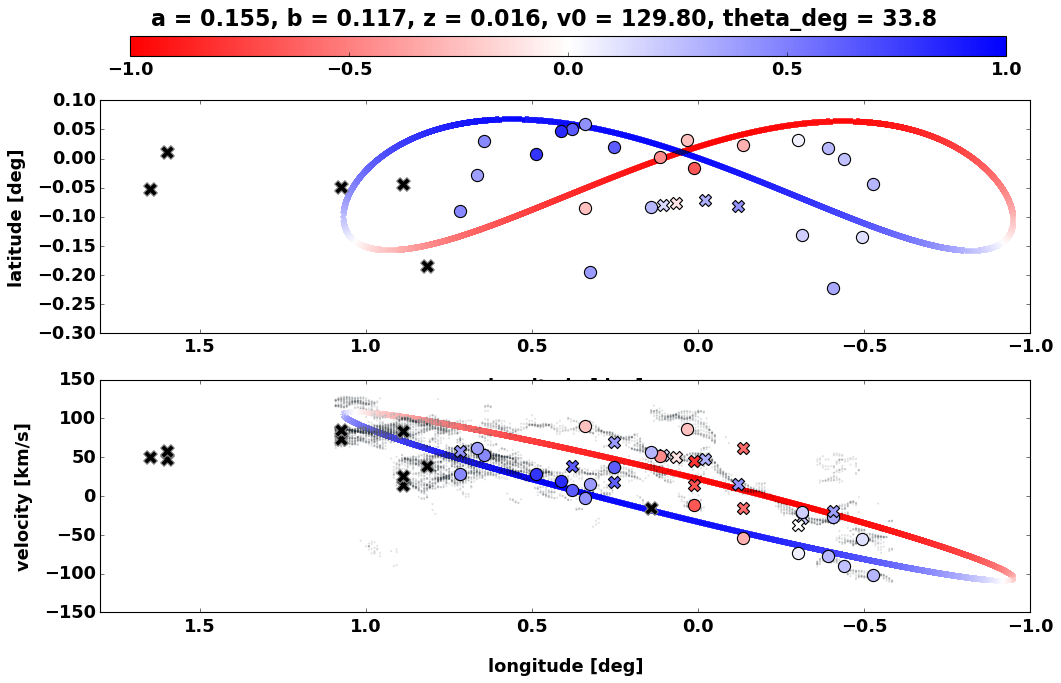

In [ ]:
lb_lv_plots_postcolor_grad(Rings_avg, scouse_on=True)



In [ ]:
plot_post_tab_agg[12]

<Row index=12>
cloud_id        A_MC               mu_MC               sigma_MC     
  str3        float64             float64              float64      
-------- ------------------ -------------------- -------------------
      13 3.6079965088955213 -0.10917096702094588 -0.1264811859631931

In [20]:
##convert the cloud posterior sigmas into pc uncertainties for the plotted ones?
cat_sig_list, cat_sig_inner, cat_sig_avg, cat_sig_outer = [], [], [], []
cat_y_list,cat_y_inner,cat_y_avg,cat_y_outer = [], [], [], []

for i in range(len(plot_post_tab_agg[:-3])):
    
    

    lowerlim_y = denorm_yNF_value(plot_post_tab_agg['mu_MC'][i],Rings_inner)
    avglim_y   = denorm_yNF_value(plot_post_tab_agg['mu_MC'][i],Rings_avg)
    upperlim_y = denorm_yNF_value(plot_post_tab_agg['mu_MC'][i],Rings_outer)
    
    #combiney_kpc = np.mean([lowerlim_y,  upperlim_y])
    combiney_kpc = upperlim_y
    
    cat_y_list.append(8.2-combiney_kpc)
    cat_y_inner.append(8.2-lowerlim_y)
    cat_y_avg.append(8.2-avglim_y)
    cat_y_outer.append(8.2-upperlim_y)

    lowerlim_sig_kpc = denorm_sigma_value(abs(plot_post_tab_agg['sigma_MC'][i]), Rings_inner)
    avglim_sig_kpc   = denorm_sigma_value(abs(plot_post_tab_agg['sigma_MC'][i]), Rings_avg)
    upperlim_sig_kpc = denorm_sigma_value(abs(plot_post_tab_agg['sigma_MC'][i]), Rings_outer)
    
    #combinesig_kpc = np.sqrt(lowerlim_sig_kpc**2 + upperlim_sig_kpc**2)
    #combinesig_kpc = (lowerlim_sig_kpc**2 + upperlim_sig_kpc**2 + avglim_sig_kpc**2)**(1./2.)
    combinesig_kpc = abs(avglim_sig_kpc) + abs(np.std((8.2-lowerlim_y, 8.2-upperlim_y, 8.2-avglim_y)))#PDF width + stdv of the three y positions?
    
    cat_sig_list.append(combinesig_kpc)
    cat_sig_inner.append(np.abs(lowerlim_sig_kpc))
    cat_sig_avg.append(np.abs(avglim_sig_kpc))
    cat_sig_outer.append(np.abs(upperlim_sig_kpc))
    

    #print(plot_cat_agg['leaf_id'][i], plot_post_tab_agg['sigma_MC'][i], abs(avglim_sig_kpc) , abs(np.std((8.2-lowerlim_y, 8.2-upperlim_y, 8.2-avglim_y))))
    print(plot_cat_agg['leaf_id'][i], (8.2-combiney_kpc)*1e3 , (8.2-lowerlim_y)*1e3 ,(8.2-upperlim_y)*1e3, abs(np.std((8.2-lowerlim_y, 8.2-upperlim_y, 8.2-avglim_y)))*1e3, plot_post_tab_agg['sigma_MC'][i],abs(avglim_sig_kpc)*1e3,combinesig_kpc*1e3,  )
    #print(plot_cat_agg['leaf_id'][i], (8.2-combiney_kpc)*1e3 , abs(np.std((8.2-lowerlim_y, 8.2-upperlim_y, 8.2-avglim_y)))*1e3,  abs(avglim_sig_kpc)*1e3, combinesig_kpc*1e3, plot_post_tab_agg['sigma_MC'][i],abs(avglim_sig_kpc)*1e3,  )

    

1 -55.14001457543216 -23.0911436608352 -55.14001457543216 18.25611623414897 0.19475569441926877 15.85368999027523 34.109806224424204
2 -23.6297518273183 -9.859771623748514 -23.6297518273183 7.811643501533001 0.17806766556803705 14.495235046274265 22.306878547807266
3 -46.641409592602656 -19.52252205894922 -46.641409592602656 15.439130372684154 -0.0960761176626362 7.820880356974775 23.260010729658926
4a -63.62163187663228 -26.652632020532252 -63.62163187663228 21.06747575926851 0.24008567845546164 19.54368486470918 40.611160623977696
5 -51.27331866840912 -21.4674919474529 -51.27331866840912 16.97444311304714 -0.10092933886409959 8.215946928001923 25.190390041049064
6b -35.71062442161832 -14.93261157768977 -35.71062442161832 11.81597488967856 -0.088948120339696 7.240640276465862 19.056615166144425
7a -11.44013079751538 -4.741267467634813 -11.44013079751538 3.7714231921476578 0.12850966849783943 10.461067396220962 14.23249058836862
8a 57.34584984529967 24.142430142138238 57.34584984529967

In [ ]:
plot_post_tab_agg

<Table length=31>
cloud_id         A_MC               mu_MC               sigma_MC      
  str3         float64             float64              float64       
-------- ------------------- -------------------- --------------------
       1  1.7928237509182936   0.2942182486485238  0.19475569441926877
       2   2.073418816830731  0.12545953383701713  0.17806766556803705
       3    4.02107617490705  0.24870248554437027  -0.0960761176626362
      4a  1.5506219840081257  0.33964303125715045  0.24008567845546164
       5   3.818618510176168  0.27350948347407017 -0.10092933886409959
      6b  3.9388446162807424  0.19016075670885116   -0.088948120339696
      7a    2.67264496951411  0.06017588972802232  0.12850966849783943
      8a   2.154586460298521 -0.30821944175886967  0.13270803138922396
       9   2.471947556848211  0.41540961697736395  0.13617477977512488
     ...                 ...                  ...                  ...
      22   8.443129735247982   0.8301947551723227  0.05681329601284947
      23   4.575514961427717   0.7920896091501736 -0.10525625756266903
      24   3.014426414641095  0.46478986844246273  0.12054967057700099
      25 0.48954918017732885  0.37617261013710696   0.6296947542377945
     26a  0.8446191275894311  0.46623705532871534  0.39131977343987334
      27  0.6138580161376826   0.0743880268086565   0.3898106271146642
     28c  0.6039228169861125  0.07461803965221804   0.3989924509484253
     29b  0.8865515953743225  0.28249651992018104   0.3715793202276751
     30a  0.8618789204952116  0.17329757679058722  0.33153168354164825
      31  0.6185043847427923  0.45018222534734814  0.40227989275008813

##for Sgrb1
minkpc =  8.2 - np.nanmin(Rings_avg.r)
maxkpc =  8.2 - np.nanmax(Rings_avg.r)
widthkpc = minkpc - maxkpc
print(widthkpc)
sgrb1_A, sgrb1_mu, sgrb1_sig =0.49940184, 0.21282293, 0.54633422
lowerlim_y = denorm_yNF_value(sgrb1_mu,Rings_inner)
avglim_y   = denorm_yNF_value(sgrb1_mu,Rings_avg)
upperlim_y = denorm_yNF_value(sgrb1_mu,Rings_outer)

#combiney_kpc = np.mean([lowerlim_y,  upperlim_y])
combiney_kpc = avglim_y

lowerlim_sig_kpc = denorm_sigma_value(sgrb1_sig, Rings_inner)
avglim_sig_kpc   = denorm_sigma_value(sgrb1_sig, Rings_avg)
upperlim_sig_kpc = denorm_sigma_value(sgrb1_sig, Rings_outer)


combinesig_kpc = abs(avglim_sig_kpc) + abs(np.std((8.2-lowerlim_y, 8.2-upperlim_y, 8.2-avglim_y)))#PDF width + stdv of the three y positions?



print('sgrb1', (8.2-combiney_kpc)*1e3 , (8.2-lowerlim_y)*1e3 ,(8.2-upperlim_y)*1e3)
print(abs(np.std((8.2-lowerlim_y, 8.2-upperlim_y, 8.2-avglim_y)))*1e3, sgrb1_sig,abs(avglim_sig_kpc)*1e3,combinesig_kpc*1e3,  )

print(avglim_sig_kpc)

In [21]:
def los_l_to_xyz(l):
    
    rr = np.linspace((8.2--0.21),(8.2-0.21), 100)
    x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(l),np.deg2rad(0),rr,
                       0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)
    return -y , x

In [ ]:
y_offset

np.float64(-0.006612005338255317)

<>:95: SyntaxWarning: invalid escape sequence '\e'
<>:95: SyntaxWarning: invalid escape sequence '\c'
<>:95: SyntaxWarning: invalid escape sequence '\e'
<>:95: SyntaxWarning: invalid escape sequence '\c'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_90486/4033589728.py:95: SyntaxWarning: invalid escape sequence '\e'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_90486/4033589728.py:95: SyntaxWarning: invalid escape sequence '\c'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])


NameError: name 'colored_line' is not defined

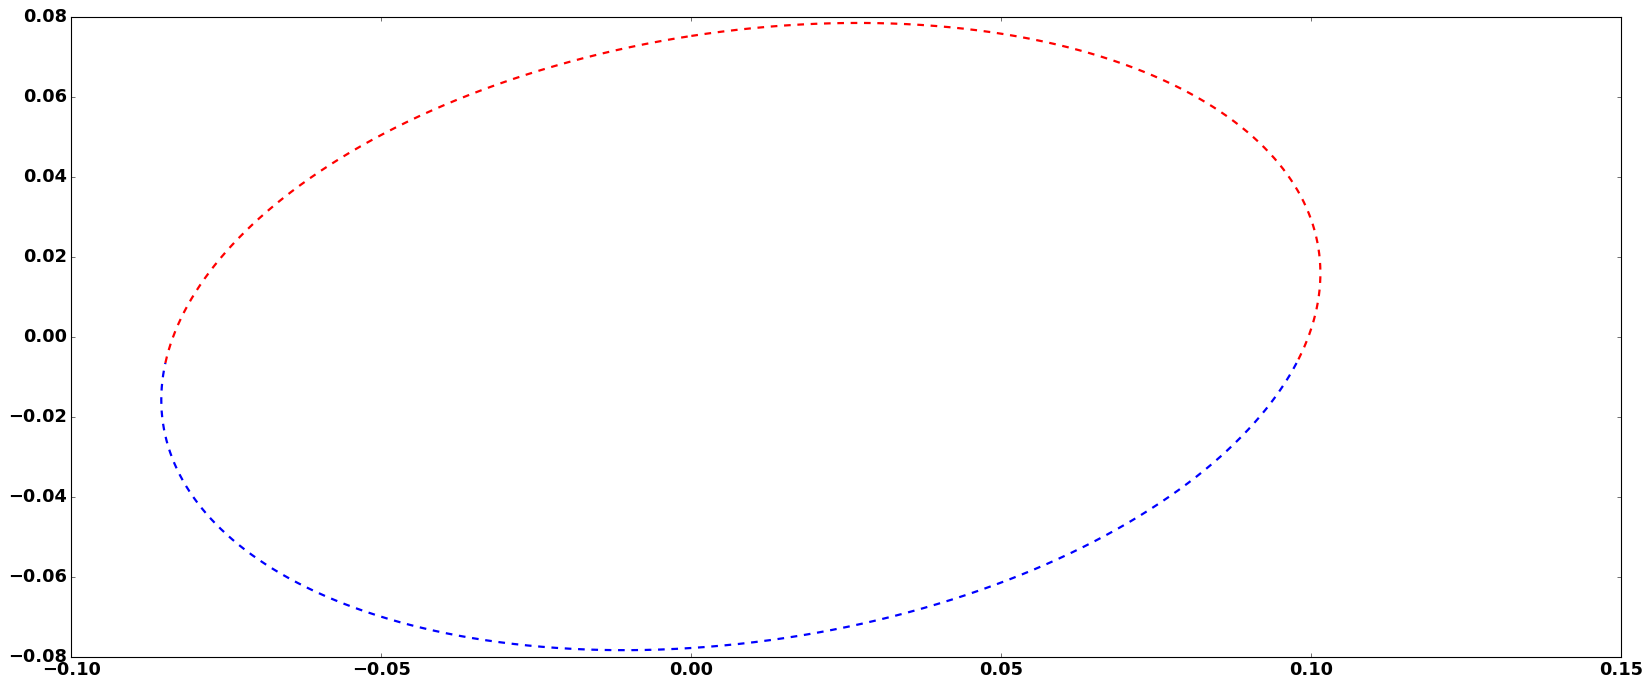

In [ ]:
### Another version of top-down with the shaded area
# treating the median ellipse as the average, and the min/max as the most likely ranges possible from the fitting

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 10))
fig.set_facecolor('white')
fig.set_facecolor('white')


ringcmap = 'bwr_r' #cmr.prinsenvlag




indind = np.where(Rings_inner.y>y_offset)[0]
indind_xneg = np.where(Rings_inner.x[indind]<0)[0]
indind_xpos = np.where(Rings_inner.x[indind]>0)[0]
sortedind = np.argsort(Rings_inner.x[indind])
inner_fore_ind = np.where(Rings_inner.y<=y_offset)
ax.plot(Rings_inner.x[indind][indind_xneg][np.argsort(Rings_inner.x[indind][indind_xneg])],Rings_inner.y[indind][indind_xneg][np.argsort(Rings_inner.x[indind][indind_xneg])],'--',c='red',linewidth=2, zorder=10)
ax.plot(Rings_inner.x[indind][indind_xpos],Rings_inner.y[indind][indind_xpos],'--',linewidth=2,c='red',zorder=10)
ax.plot(Rings_inner.x[inner_fore_ind[0:]],Rings_inner.y[inner_fore_ind[0:]],c='blue', linestyle = '--', linewidth=2, zorder=9)

avg_ringcolor = ring_NF_dist(Rings_avg)[2]
avg_lines = colored_line(Rings_avg.x ,Rings_avg.y , avg_ringcolor, ax, linewidth=5, cmap=ringcmap,zorder=10)

indind = np.where(Rings_outer.y>y_offset)[0]
indind_xneg = np.where(Rings_outer.x[indind]<0)[0]
indind_xpos = np.where(Rings_outer.x[indind]>0)[0]
sortedind = np.argsort(Rings_outer.x[indind])
outer_fore_ind = np.where(Rings_outer.y<=y_offset)
ax.plot(Rings_outer.x[indind][indind_xneg][np.argsort(Rings_outer.x[indind][indind_xneg])],Rings_outer.y[indind][indind_xneg][np.argsort(Rings_outer.x[indind][indind_xneg])],'--',linewidth=2,c='red',zorder=10)
ax.plot(Rings_outer.x[indind][indind_xpos],Rings_outer.y[indind][indind_xpos],'--',linewidth=2,c='red',zorder=10)
ax.plot(Rings_outer.x[outer_fore_ind[0:]],Rings_outer.y[outer_fore_ind[0:]],c='blue', linestyle = '--', linewidth=2, zorder=9)




## Shade between the N and F edges? ##
ax.fill(Rings_outer.x,Rings_outer.y, 'grey', alpha=0.1 ,zorder=0)
ax.fill(Rings_inner.x, Rings_inner.y, 'w', edgecolor='w', alpha=1)





sgra = ax.scatter(-y_offset , 0 , marker = '*', s=150 ,color = 'k',zorder=10)


long_list = np.arange(-1.5, 1.5, 0.5)
axt_ticks = []
for ll in long_list:
    xline, rrline = los_l_to_xyz(ll)
    ax.plot(xline, rrline , linestyle = '--', c='gray',zorder=1)
    axt_ticks.append(xline[-1])




divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
cmap    = 'bwr_r'
for i in range(len(cat_y_list)):

    if plot_post_tab_agg['cloud_id'][i] not in cat_agg['leaf_id']:
        marker = 'X'
        color = 'k'
        alpha = 1.
    else:
        marker = 'o'
        color = plot_post_tab_agg['mu_MC'][i]
        alpha =1.
            
    x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(plot_cat_agg['l'][i]),np.deg2rad(plot_cat_agg['b'][i]),cat_y_list[i]+8.2,
                       0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)

    ax.scatter(-y,cat_y_list[i], marker = marker, c=color , cmap=cmap, norm=divnorm, s = 150, zorder = 10)

    ax.errorbar(-y,cat_y_list[i], yerr=cat_sig_list[i], c='k', zorder=9)
    ax.text((-y),cat_y_list[i]+0.005, int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))) , zorder=10) 


ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.158, 0.158)

#ax.axes.get_yaxis().set_visible(False)

xlabels = [item.get_text().replace('\u2212', '-') for item in ax.get_xticklabels()]
xlabels = [str(int(float(item)*1e3)) for item in xlabels]
ylabels = [item.get_text().replace('\u2212', '-') for item in ax.get_yticklabels()]
ylabels = [str(int(float(item)*1e3)) for item in ylabels]
ax.set_xticklabels(xlabels)
ax.set_yticklabels(' ')

ax_t = ax.secondary_xaxis('top') #set top axis ticks on
ax_t.set_xticks(axt_ticks)
ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])

ax.set_xlabel('x [pc]', labelpad=20)
ax.set_ylabel('y', labelpad=10)

ax.arrow(-.120, -.100, 0, -0.008*3, length_includes_head=False,
          head_width=0.004*3, head_length=0.005*3, color = 'k')
ax.text(-.127, -.09, 'To Sun')



#plt.savefig('./paper_items/Figs/x2_fits_topdown_ellipses_shaded.pdf', bbox_inches='tight')


In [ ]:
max(plot_cat_agg['rad'])

np.float64(8.7)

<>:110: SyntaxWarning: invalid escape sequence '\e'
<>:110: SyntaxWarning: invalid escape sequence '\c'
<>:110: SyntaxWarning: invalid escape sequence '\e'
<>:110: SyntaxWarning: invalid escape sequence '\c'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_54086/581365026.py:110: SyntaxWarning: invalid escape sequence '\e'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list],fontsize=25)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_54086/581365026.py:110: SyntaxWarning: invalid escape sequence '\c'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list],fontsize=25)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_54086/581365026.py:73: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(-y,cat_y_list[i], marker = marker, c=color , cmap=cmap, norm=divnorm, s = 150, zorder = 10)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_54086/581365026.py:105

Text(-0.127, -0.145, 'To Sun')

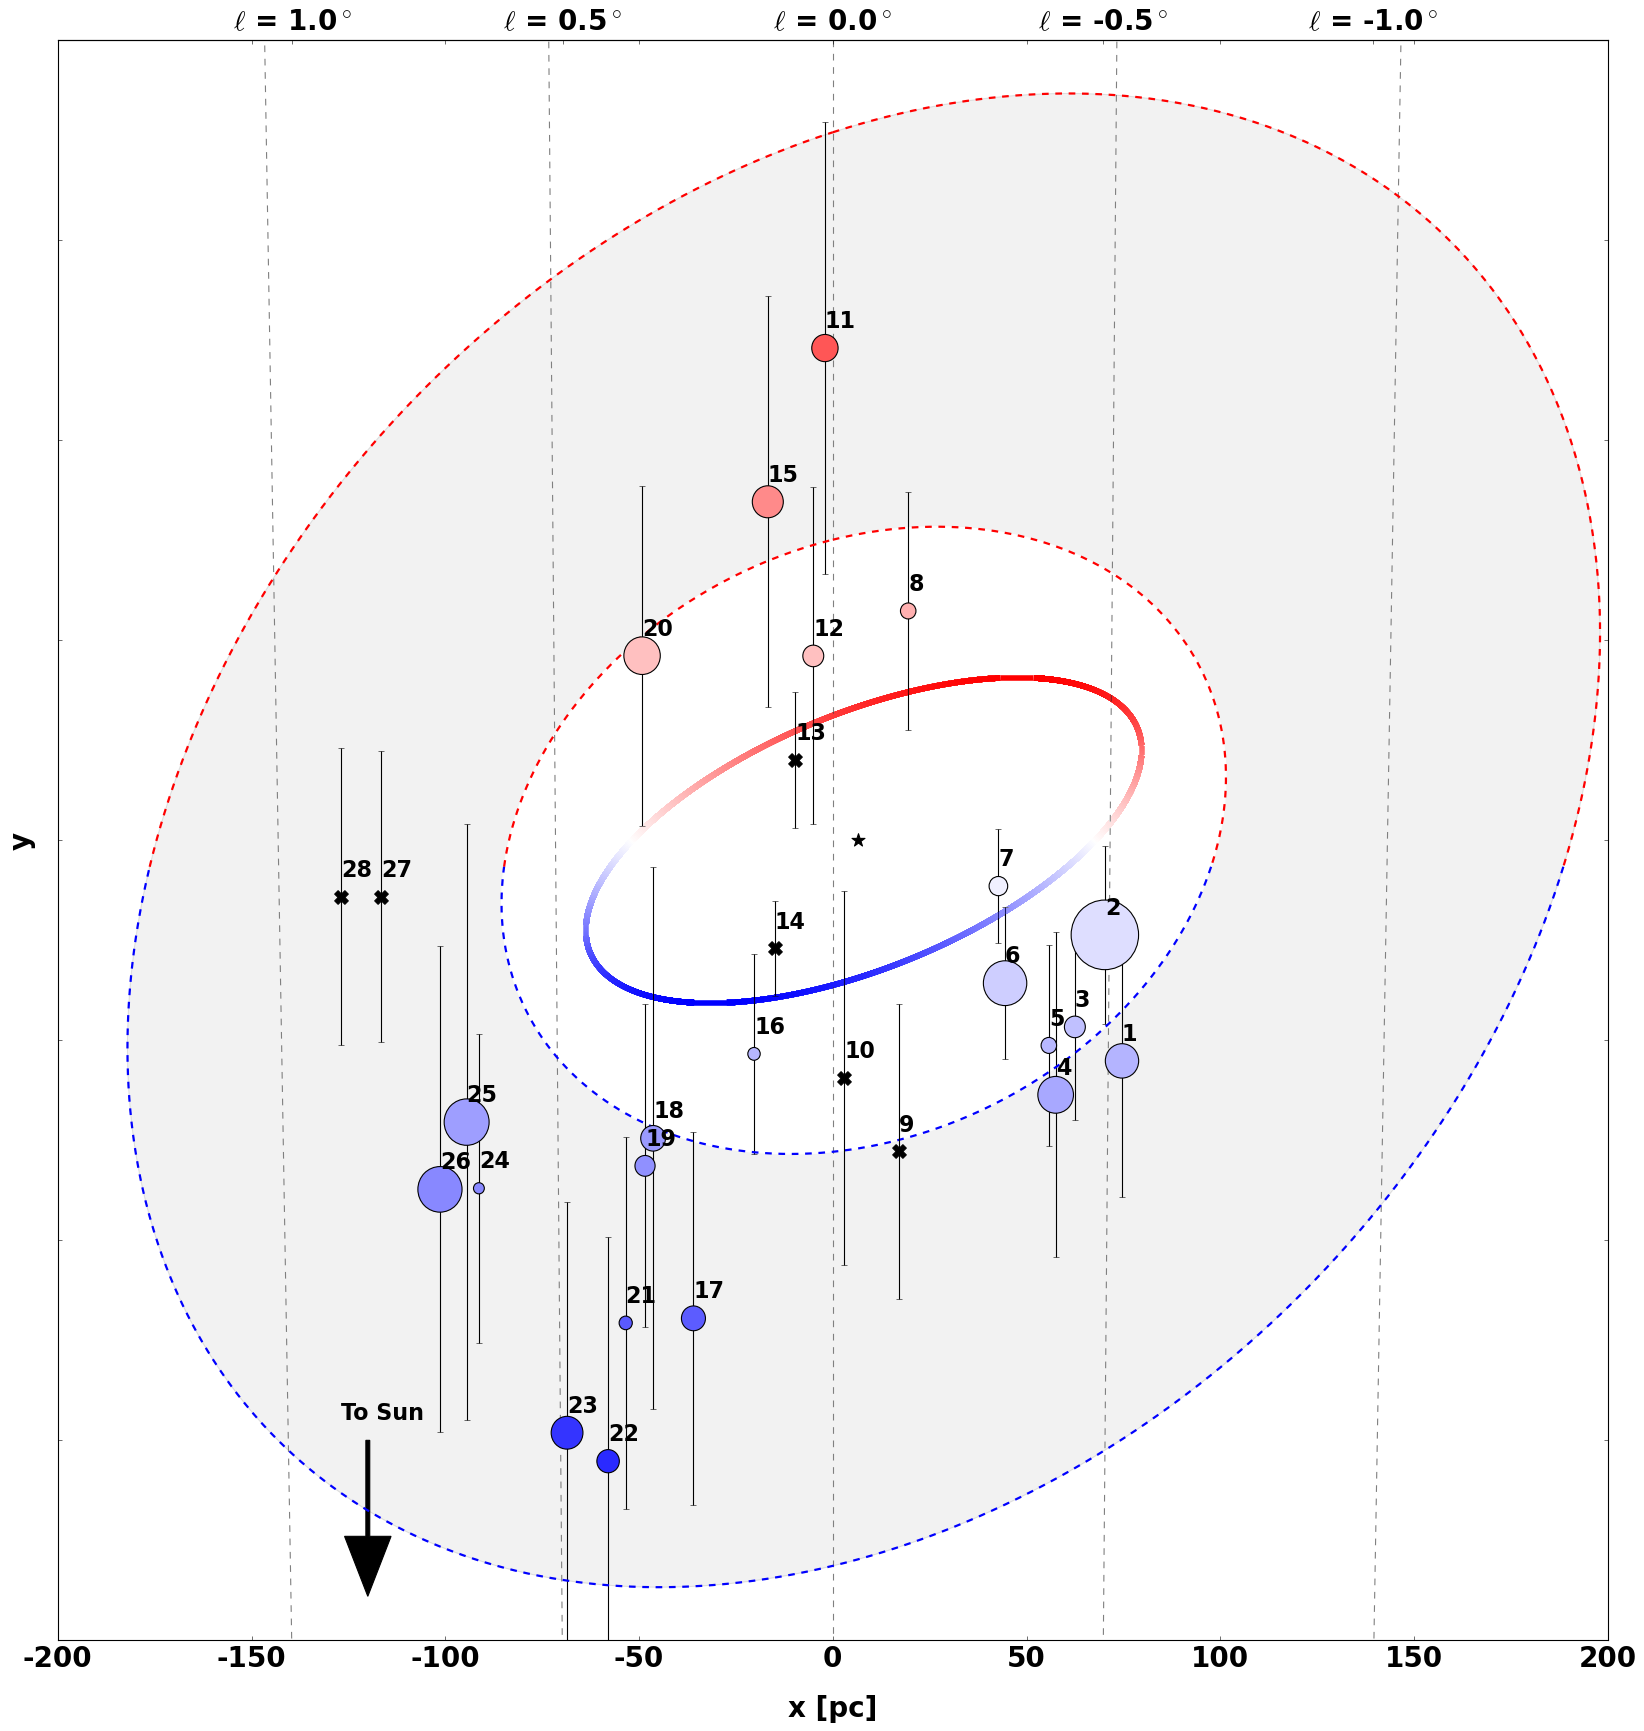

In [22]:
### Another version of top-down with the shaded area
### ADDING IN THE FACE-ON PROJECTED AREAS
# treating the median ellipse as the average, and the min/max as the most likely ranges possible from the fitting


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 25))
fig.set_facecolor('white')
fig.set_facecolor('white')


ringcmap = 'bwr_r' #cmr.prinsenvlag




indind = np.where(Rings_inner.y>y_offset)[0]
indind_xneg = np.where(Rings_inner.x[indind]<0)[0]
indind_xpos = np.where(Rings_inner.x[indind]>0)[0]
sortedind = np.argsort(Rings_inner.x[indind])
inner_fore_ind = np.where(Rings_inner.y<=y_offset)
ax.plot(Rings_inner.x[indind][indind_xneg][np.argsort(Rings_inner.x[indind][indind_xneg])],Rings_inner.y[indind][indind_xneg][np.argsort(Rings_inner.x[indind][indind_xneg])],'--',c='red',linewidth=2, zorder=9)
ax.plot(Rings_inner.x[indind][indind_xpos],Rings_inner.y[indind][indind_xpos],'--',linewidth=2,c='red',zorder=9)
ax.plot(Rings_inner.x[inner_fore_ind[0:]],Rings_inner.y[inner_fore_ind[0:]],c='blue', linestyle = '--', linewidth=2, zorder=9)

avg_ringcolor = ring_NF_dist(Rings_avg)[2]
avg_lines = colored_line(Rings_avg.x ,Rings_avg.y , avg_ringcolor, ax, linewidth=5, cmap=ringcmap,zorder=10)

indind = np.where(Rings_outer.y>y_offset)[0]
indind_xneg = np.where(Rings_outer.x[indind]<0)[0]
indind_xpos = np.where(Rings_outer.x[indind]>0)[0]
sortedind = np.argsort(Rings_outer.x[indind])
outer_fore_ind = np.where(Rings_outer.y<=y_offset)
ax.plot(Rings_outer.x[indind][indind_xneg][np.argsort(Rings_outer.x[indind][indind_xneg])],Rings_outer.y[indind][indind_xneg][np.argsort(Rings_outer.x[indind][indind_xneg])],'--',linewidth=2,c='red',zorder=10)
ax.plot(Rings_outer.x[indind][indind_xpos],Rings_outer.y[indind][indind_xpos],'--',linewidth=2,c='red',zorder=10)
ax.plot(Rings_outer.x[outer_fore_ind[0:]],Rings_outer.y[outer_fore_ind[0:]],c='blue', linestyle = '--', linewidth=2, zorder=9)




## Shade between the N and F edges? ##
ax.fill(Rings_outer.x,Rings_outer.y, 'grey', alpha=0.1 ,zorder=0)
ax.fill(Rings_inner.x, Rings_inner.y, 'w', edgecolor='w', alpha=1)





sgra = ax.scatter(-y_offset , 0 , marker = '*', s=150 ,color = 'k',zorder=10)


long_list = np.arange(-2., 2., 0.5)
axt_ticks = []
for ll in long_list:
    xline, rrline = los_l_to_xyz(ll)
    ax.plot(xline, rrline , linestyle = '--', c='gray',zorder=1)
    axt_ticks.append(xline[-1])




divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
cmap    = 'bwr_r'
for i in range(len(cat_y_list)):
    

    if plot_post_tab_agg['cloud_id'][i] not in cat_agg['leaf_id']:
        marker = 'X'
        color = 'k'
        alpha = 1.

        x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(plot_cat_agg['l'][i]),np.deg2rad(plot_cat_agg['b'][i]),cat_y_list[i]+8.2,
                        0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)
        ax.scatter(-y,cat_y_list[i], marker = marker, c=color , cmap=cmap, norm=divnorm, s = 150, zorder = 10)
        ax.errorbar(-y,cat_y_list[i], yerr=cat_sig_list[i], c='k', zorder=9)
        ax.text((-y),cat_y_list[i]+0.005, int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))) ,fontsize=20, zorder=10) 

    else:

        circle_rad = plot_cat_agg['rad'][i]/1e3 #in kpc
        
        x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(plot_cat_agg['l'][i]),np.deg2rad(plot_cat_agg['b'][i]),cat_y_list[i]+8.2,
                        0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)

        circle = mpl.patches.Circle((-y,cat_y_list[i]), radius=circle_rad)
        circle.set_zorder(10)
        color = cm.bwr_r(divnorm(plot_post_tab_agg['mu_MC'][i]))
        alpha =1.

        ax.add_artist(circle, )
        circle.set_facecolor(color)
        circle.set_zorder(9)
        ax.errorbar(-y,cat_y_list[i], yerr=cat_sig_list[i], c='k', zorder=8)
        ax.text((-y),cat_y_list[i]+0.005, int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))) , fontsize=20, zorder=10) 


ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)

#ax.axes.get_yaxis().set_visible(False)

xlabels = [item.get_text().replace('\u2212', '-') for item in ax.get_xticklabels()]
xlabels = [str(int(float(item)*1e3)) for item in xlabels]
ylabels = [item.get_text().replace('\u2212', '-') for item in ax.get_yticklabels()]
ylabels = [str(int(float(item)*1e3)) for item in ylabels]
ax.set_xticklabels(xlabels, fontsize=25)
ax.set_yticklabels(' ')

ax_t = ax.secondary_xaxis('top') #set top axis ticks on
ax_t.set_xticks(axt_ticks)
ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list],fontsize=25)

ax.set_xlabel('x [pc]', labelpad=20,fontsize=25)
ax.set_ylabel('y', labelpad=10,fontsize=25)

ax.arrow(-.120, -.150, 0, -0.008*3, length_includes_head=False,
          head_width=0.004*3, head_length=0.005*3, color = 'k')
ax.text(-.127, -.145, 'To Sun', fontsize=20,zorder=10)



#plt.savefig('./paper_items/Figs/x2_fits_topdown_ellipses_shaded_circleareas.pdf', bbox_inches='tight')


array([     0,      1,      2, ..., 191189, 191190, 191191],
      shape=(71738,))

# Separate top-down ellipses! 

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(25, 25*2.5), dpi=300)
plt.subplots_adjust(wspace=0.05)
fig.set_facecolor('white')
fig.set_facecolor('white')

ringcmap = 'bwr_r' #cmr.prinsenvlag


### Plot Rings LB ###
min_ringcolor = ring_NF_dist(Rings_inner)[2]
min_lines = colored_line(Rings_inner.x ,Rings_inner.y , min_ringcolor, ax[0], linewidth=5, cmap=ringcmap,zorder=10)


avg_ringcolor = ring_NF_dist(Rings_avg)[2]
avg_lines = colored_line(Rings_avg.x ,Rings_avg.y , avg_ringcolor, ax[1], linewidth=5, cmap=ringcmap,zorder=10)


max_ringcolor = ring_NF_dist(Rings_outer)[2]
max_lines = colored_line(Rings_outer.x ,Rings_outer.y , max_ringcolor, ax[2], linewidth=5, cmap=ringcmap,zorder=10)

ax[0].scatter(-y_offset , 0 , marker = '*', s=150 ,color = 'k',zorder=10)
ax[1].scatter(-y_offset , 0 , marker = '*', s=150 ,color = 'k',zorder=10)
ax[2].scatter(-y_offset , 0 , marker = '*', s=150 ,color = 'k',zorder=10)


for axes in ax:
    long_list = np.arange(-1.5, 1.5, 0.5)
    axt_ticks = []
    for ll in long_list:
        xline, rrline = los_l_to_xyz(ll)
        axes.plot(xline, rrline , linestyle = '--', c='gray',zorder=0)
        axt_ticks.append(xline[-1])

    axes.set_xlim(-0.15, 0.15)
    axes.set_ylim(-0.158, 0.158)
    xlabels = [item.get_text().replace('\u2212', '-') for item in axes.get_xticklabels()]
    xlabels = [str(int(float(item)*1e3)) for item in xlabels]
    ylabels = [item.get_text().replace('\u2212', '-') for item in axes.get_yticklabels()]
    ylabels = [str(int(float(item)*1e3)) for item in ylabels]
    axes.set_xticklabels(xlabels)
    axes.set_yticklabels(' ')

    ax_t = axes.secondary_xaxis('top') #set top axis ticks on
    ax_t.set_xticks(axt_ticks)
    ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])

    axes.set_xlabel('x [pc]', labelpad=20)
    axes.set_ylabel('y', labelpad=10)

    axes.arrow(-.120, -.100, 0, -0.008*3, length_includes_head=False,
            head_width=0.004*3, head_length=0.005*3, color = 'k')
    axes.text(-.127, -.09, 'To Sun')

    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    cmap    = 'bwr_r'

    if axes == ax[0]:
        ycatsig, ycat   = cat_sig_inner, cat_y_inner
    if axes == ax[1]:
        ycatsig, ycat  = cat_sig_avg, cat_y_avg
    if axes == ax[2]:
        ycatsig, ycat = cat_sig_outer, cat_y_outer

    for i in range(len(ycat)):

        if plot_post_tab_agg['cloud_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            color = 'k'
            alpha = 1.
        else:
            marker = 'o'
            color = plot_post_tab_agg['mu_MC'][i]
            alpha =1.
                
        x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(plot_cat_agg['l'][i]),np.deg2rad(plot_cat_agg['b'][i]),ycat[i]+8.2,
                        0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)

        axes.scatter(-y,ycat[i], marker = marker, c=color , cmap=cmap, norm=divnorm, s = 150, zorder = 10)

        axes.errorbar(-y,ycat[i], yerr=ycatsig[i], c='k', zorder=9)
        axes.text((-y),ycat[i]+0.005, int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))) , zorder=10) 


plt.savefig('./paper_items/Figs/separate_x2_fits_topdown_ellipses.pdf', bbox_inches='tight')


<>:45: SyntaxWarning: invalid escape sequence '\e'
<>:45: SyntaxWarning: invalid escape sequence '\c'
<>:45: SyntaxWarning: invalid escape sequence '\e'
<>:45: SyntaxWarning: invalid escape sequence '\c'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_98961/3111368887.py:45: SyntaxWarning: invalid escape sequence '\e'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_98961/3111368887.py:45: SyntaxWarning: invalid escape sequence '\c'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_98961/3111368887.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(xlabels)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_98961/3111368887.py:41: UserWarning: set_ticklabels() should only be used with a fixed numbe

In [ ]:
cat_tab

<Table length=22>
leaf_id   cloud_name      l       b    ... NF_decision absorp_NF lb_pixel_mask
  str3      str14      float64 float64 ...     str3       str3       int64    
------- -------------- ------- ------- ... ----------- --------- -------------
      1 G359.475-0.044  -0.525  -0.044 ...          LN       nan             1
      2 G359.508-0.135  -0.492  -0.135 ...           N       nan             1
      3 G359.561-0.001  -0.439  -0.001 ...           U         F             1
     4a G359.595-0.223  -0.405  -0.223 ...           N       nan             1
      5 G359.608+0.018  -0.392   0.018 ...          LN         N             1
     6b G359.688-0.132  -0.312  -0.132 ...           U         F             1
     7a G359.701+0.032  -0.299   0.032 ...          LN         N             1
     8a G359.865+0.023  -0.135   0.023 ...           F         F             1
    11a   G0.014-0.016   0.014  -0.016 ...           F       nan             1
    ...            ...     ...     ... ...         ...       ...           ...
    17b    G0.255+0.02   0.255    0.02 ...           N         N             1
     18   G0.327-0.195   0.327  -0.195 ...           U       nan             1
     19    G0.342+0.06   0.342    0.06 ...           N         N             1
     20   G0.342-0.085   0.342  -0.085 ...           F         F             1
    21a    G0.379+0.05   0.379    0.05 ...           N         N             1
     22   G0.413+0.048   0.413   0.048 ...           N         N             1
     23   G0.488+0.008   0.488   0.008 ...           N         N             1
     24    G0.645+0.03   0.645    0.03 ...           N       nan             1
     25   G0.666-0.028   0.666  -0.028 ...           U         N             1
    26a    G0.716-0.09   0.716   -0.09 ...           N       nan             1

In [ ]:
np.array(xray_tab['cloud_index']).astype(str)

array(['13', '14'], dtype='<U21')

# Save LOS dist results to Table

In [ ]:
##Load in PPDF table and create a column that lists the methods used##
PPDF_meth_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/paper_items/Tables/PPDF_method_info.tex")
starcount_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/starcounts_tab.tex")
xray_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/xray_methods.tex")
nogueras_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/nogueras_measures.tex")

method_col = []
for i in range(len(PPDF_meth_tab)):
    meths = np.array('')
    j = PPDF_meth_tab[i]['leaf_id']
    
    if np.isnan(PPDF_meth_tab[i]['flux_diff']) == False:
        meths= meths + 'd'
    if np.isnan(PPDF_meth_tab[i]['flux_ratio']) == False:
        meths = meths + ',r'
    if np.isnan(PPDF_meth_tab[i]['corr_coeff']) == False:
        meths = meths + ',c'
    if np.isnan(PPDF_meth_tab[i]['absorp_value']) == False:
        meths = meths + ',a'
    if np.isnan(starcount_tab[i]['counts_ratio_from_avg']) == False:
        meths = meths + ',s'
    if j in np.array(xray_tab['cloud_index']).astype(str):
        meths = meths + ',x'
    if j in np.array(nogueras_tab['cloud_index']).astype(str):
        meths = meths + ',k'
    
    method_col.append(meths)
meth_table = Table()
meth_table['leaf_id'] = PPDF_meth_tab['leaf_id']
meth_table['methods'] = method_col
meth_table

<Table length=47>
leaf_id  methods 
  str3     str9  
------- ---------
      1   d,r,c,s
      2   d,r,c,s
      3 d,r,c,a,s
     4a   d,r,c,s
     4b   d,r,c,s
      5 d,r,c,a,s
     6a d,r,c,a,s
     6b d,r,c,a,s
     7a d,r,c,a,s
    ...       ...
    26b   d,r,c,s
     27   d,r,c,s
    28a   d,r,c,s
    28b   d,r,c,s
    28c   d,r,c,s
    29a   d,r,c,s
    29b   d,r,c,s
    30a   d,r,c,s
    30b   d,r,c,s
     31   d,r,c,s

In [ ]:
##convert the cloud posterior sigmas into pc uncertainties for ALL IDs

full_cat_sig_list = []
full_cat_y_list = []
for i in range(len(plot_post_tab[:])):

    lowerlim_y = denorm_yNF_value(plot_post_tab['mu_MC'][i],Rings_inner)
    avglim_y   = denorm_yNF_value(plot_post_tab['mu_MC'][i],Rings_avg)
    upperlim_y = denorm_yNF_value(plot_post_tab['mu_MC'][i],Rings_outer)
    
    #combiney_kpc = np.mean([lowerlim_y,  upperlim_y])
    combiney_kpc = avglim_y
    
    cat_y_list.append(8.2-combiney_kpc)
    cat_y_inner.append(8.2-lowerlim_y)
    cat_y_avg.append(8.2-avglim_y)
    cat_y_outer.append(8.2-upperlim_y)
    
    full_cat_y_list.append(8.2-combiney_kpc)   
    
    lowerlim_sig_kpc = denorm_sigma_value(plot_post_tab['sigma_MC'][i], Rings_inner)
    avglim_sig_kpc   = denorm_sigma_value(plot_post_tab['sigma_MC'][i], Rings_avg)
    upperlim_sig_kpc = denorm_sigma_value(plot_post_tab['sigma_MC'][i], Rings_outer)
    
    #combinesig_kpc = np.sqrt(lowerlim_sig_kpc**2 + upperlim_sig_kpc**2)
    #combinesig_kpc = (lowerlim_sig_kpc**2 + upperlim_sig_kpc**2 + avglim_sig_kpc**2)**(1./2.)
    combinesig_kpc = abs(avglim_sig_kpc) + abs(np.std((8.2-lowerlim_y, 8.2-upperlim_y, 8.2-avglim_y)))#PDF width + stdv of the three y positions?
    
    cat_sig_list.append(combinesig_kpc)
    cat_sig_inner.append(np.abs(lowerlim_sig_kpc))
    cat_sig_avg.append(np.abs(avglim_sig_kpc))
    cat_sig_outer.append(np.abs(upperlim_sig_kpc))
    full_cat_sig_list.append(combinesig_kpc)
    

    
    print(plot_tab['leaf_id'][i], (8.2-combiney_kpc)*1e3 , combinesig_kpc*1e3 )
    
los_table = Table()
los_table['leaf id'] = plot_tab['leaf_id']
los_table['cloud name'] = plot_tab['cloud_name']
los_table['l'] = plot_tab['l'] * u.degree
los_table['b'] = plot_tab['b'] * u.degree
los_table['v'] = plot_tab['v'] * u.km/ u.s
los_table['A_mc']      = plot_post_tab['A_MC'].round(3)
los_table['mu_mc']     = plot_post_tab['mu_MC'].round(3)
los_table['sigma_mc']  = abs(plot_post_tab['sigma_MC'].round(3))
los_table['LOS_pos'] = np.round(np.array(full_cat_y_list), 3) * u.kpc
los_table['LOS_sig'] = np.round(np.array(full_cat_sig_list), 3) * u.kpc
los_table['NF Methods'] = meth_table['methods']
los_table.write("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/paper_items/Tables/LOS_synth_table.tex", format = 'latex', overwrite=True)


1 -38.32860080547995 63.70715498490376
2 -16.397974818882943 51.90464317713981
3 -32.41371114632052 36.046394016368275
4a -44.231667316889656 77.4980597858438
4b -49.210285142143206 101.60583439249552
5 -35.63744388245915 38.405133141766896
6a -26.59957121346679 37.899263627563585
6b -24.806063973048964 31.604139907003947
7a -7.914198537488204 36.13638414128257
7b -0.5580423009927671 36.655931435598575
8a 39.959715642716276 48.05177734075825
8b 74.40518121372541 52.26719402801379
8c 75.82396207170738 67.56479367920376
9 -54.077728633291855 53.84269681587854
10 -41.34570460012199 100.52749629937067
11a 85.70339316018938 79.25880100746532
11b 103.16387348596123 87.2765642299663
11c 87.33136379195017 53.07155215868615
12 32.13316889065787 96.4964205764895
13 14.092857995951391 37.6282836261662
14 -18.767003630271617 15.803467826372586
15 58.95463235801124 94.37355453971561
16a nan nan
16b -37.106132648371926 35.902743082437645
17a -80.3108653754343 48.40160417503134
17b -83.12241206583693

In [ ]:
los_table[19:28]

<Table length=9>
leaf id  cloud name     l       b    ... sigma_mc LOS_pos LOS_sig NF Methods
                       deg     deg   ...            kpc     kpc             
  str3     str14     float64 float64 ... float64  float64 float64    str9   
------- ------------ ------- ------- ... -------- ------- ------- ----------
     13 G0.068-0.076   0.068  -0.076 ...    0.126   0.014   0.038  d,r,c,a,x
     14  G0.105-0.08   0.105   -0.08 ...    0.036  -0.019   0.016  d,r,c,a,x
     15 G0.116+0.003   0.116   0.003 ...    0.286   0.059   0.094  d,r,c,a,s
    16a G0.143-0.083   0.143  -0.083 ...      nan     nan     nan           
    16b G0.143-0.083   0.143  -0.083 ...    0.089  -0.037   0.036  d,r,c,a,s
    17a  G0.255+0.02   0.255    0.02 ...    0.081   -0.08   0.048  d,r,c,a,s
    17b  G0.255+0.02   0.255    0.02 ...    0.087  -0.083   0.051  d,r,c,a,s
    17c  G0.255+0.02   0.255    0.02 ...     0.05  -0.052   0.031  d,r,c,a,s
     18 G0.327-0.195   0.327  -0.195 ...     0.53  -0.052   0.155    d,r,c,s

In [ ]:
Rings_out_tab = ascii.read("Rings_out.dat")

def denorm_yNF_value(y_NF, Rings_out):
        
    """This function takes in a normalized array (-1,1) and converts it to a top-down y-axis
    distance from SgrA* based on that output from the best fitting x2 ellipse (Rings_out).
    
    Positive values are on the NEAR SIDE in front of SgrA*
    Negative values are on the FAR SIDE behind SgrA*
    
    Results are in kiloparsecs!! 
    """
    term1 = (y_NF + 1)/2
    term2 = (np.nanmax(Rings_out_tab['r']) - np.nanmin(Rings_out_tab['r']))
    
    real_y = (term1*term2) + np.nanmin(Rings_out_tab['r'])

    #returns the LOS distance on the ring from SgrA* in kpc
    return real_y

def argmedian(x):
    return np.argpartition(x, len(x) // 2)[len(x) // 2]
#normELL_l, normELL_b, normELL_v = normalizelbv(Rings_out.l,Rings_out.b,Rings_out.vr)
#back_ind, fore_ind, y_NF = ring_NF_dist(Rings_out) #finds the N/F on the ellipse
#Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)

# Try fitting different initial CMZ sizes (change by 5 pc each time?)

params = create_params(a_rings={'value': 0.115   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       #b_rings={'value': 0.1  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True},
                       #alpha_rings={'value': 0.1  , 'min': -3, 'max': 3, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )
params.add('b_rings', value=0.61*params['a_rings'].value, min=0.01, max=0.2, vary=True)
params.add('alpha_rings', value=0.3904+(((params['a_rings'].value-0.010)/0.005)*0.0006), min= -np.pi/2, max= np.pi/2, vary=True)


10 10
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 393
    # data points      = 22
    # variables        = 5
    chi-square         = 40.0350428
    reduced chi-square = 2.35500252
    Akaike info crit   = 23.1716791
    Bayesian info crit = 28.6268914
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.04095734 (init = 0.01)
    b_rings:      0.01902967 (init = 0.01)
    z_rings:      0.04998706 (init = 0.0125)
    v_rings:      128.180009 (init = 130)
    theta_rings:  10.1044121 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.55740022] [-0.62072602]
[0.13199878] [-0.02655596] [1.] [-1.]
DISREGARDED FIT


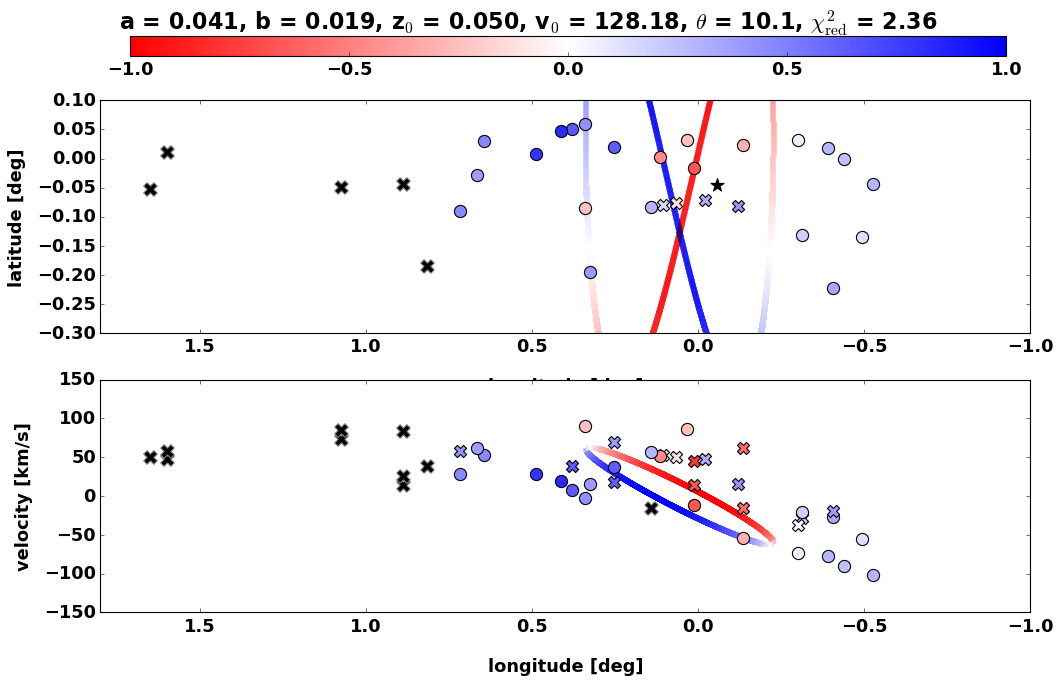

15 15
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 573
    # data points      = 22
    # variables        = 5
    chi-square         = 26.2007753
    reduced chi-square = 1.54122208
    Akaike info crit   = 13.8444241
    Bayesian info crit = 19.2996364
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07203444 (init = 0.015)
    b_rings:      0.02533109 (init = 0.01)
    z_rings:      0.04999989 (init = 0.0125)
    v_rings:      134.552159 (init = 130)
    theta_rings:  22.9381463 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.27433773] [-0.20323884]
[0.36562334] [-0.25890865] [1.] [-1.]
NICE FIT!


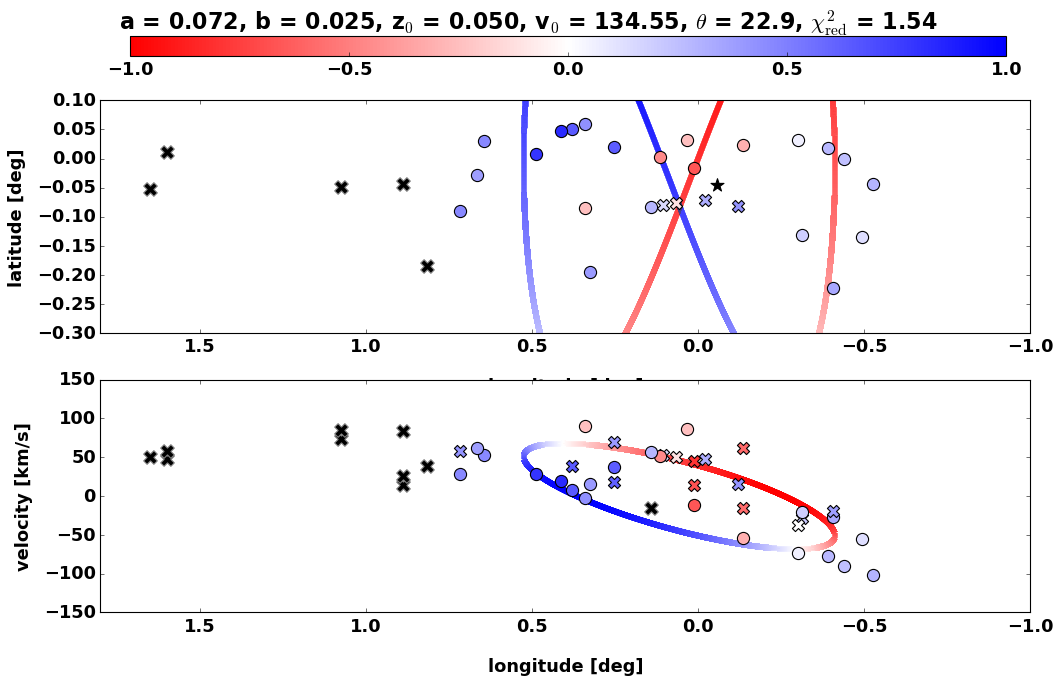

20 20
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 455
    # data points      = 22
    # variables        = 5
    chi-square         = 26.3130701
    reduced chi-square = 1.54782765
    Akaike info crit   = 13.9385131
    Bayesian info crit = 19.3937254
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07096495 (init = 0.02)
    b_rings:      0.02230019 (init = 0.0122)
    z_rings:      0.04999323 (init = 0.0125)
    v_rings:      147.119625 (init = 130)
    theta_rings:  20.5397246 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.31696128] [-0.23343338]
[0.37326467] [-0.26761493] [1.] [-1.]
NICE FIT!


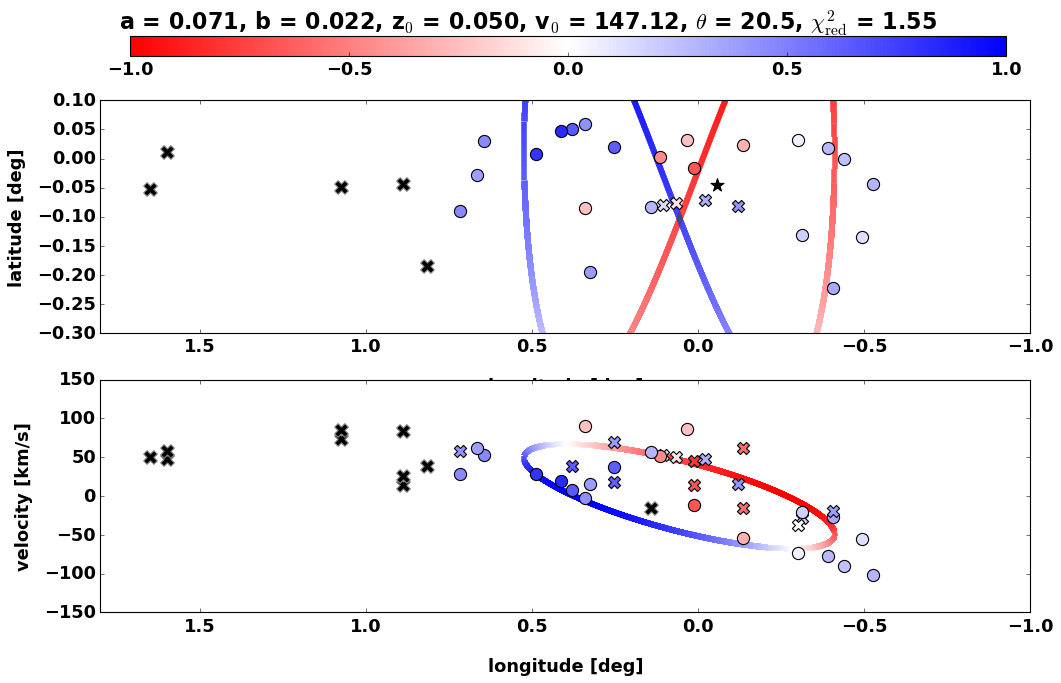

25 25
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 400
    # data points      = 22
    # variables        = 5
    chi-square         = 26.2475742
    reduced chi-square = 1.54397495
    Akaike info crit   = 13.8836847
    Bayesian info crit = 19.3388969
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07163879 (init = 0.025)
    b_rings:      0.02406724 (init = 0.01525)
    z_rings:      0.04999859 (init = 0.0125)
    v_rings:      140.061762 (init = 130)
    theta_rings:  21.6308310 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.30917429] [-0.2322545]
[0.36776345] [-0.26180146] [1.] [-1.]
NICE FIT!


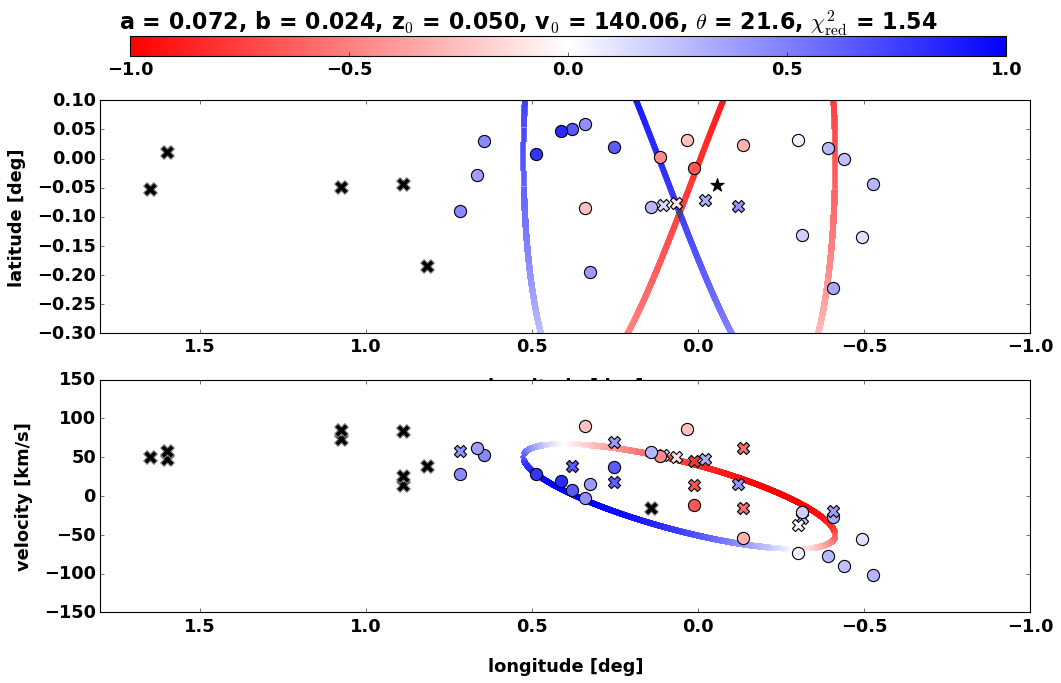

30 30
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 320
    # data points      = 22
    # variables        = 5
    chi-square         = 26.2741722
    reduced chi-square = 1.54553954
    Akaike info crit   = 13.9059671
    Bayesian info crit = 19.3611793
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07137614 (init = 0.03)
    b_rings:      0.02332259 (init = 0.0183)
    z_rings:      0.04999605 (init = 0.0125)
    v_rings:      143.117005 (init = 130)
    theta_rings:  21.1315868 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.31463539] [-0.23557915]
[0.37002678] [-0.2642402] [1.] [-1.]
NICE FIT!


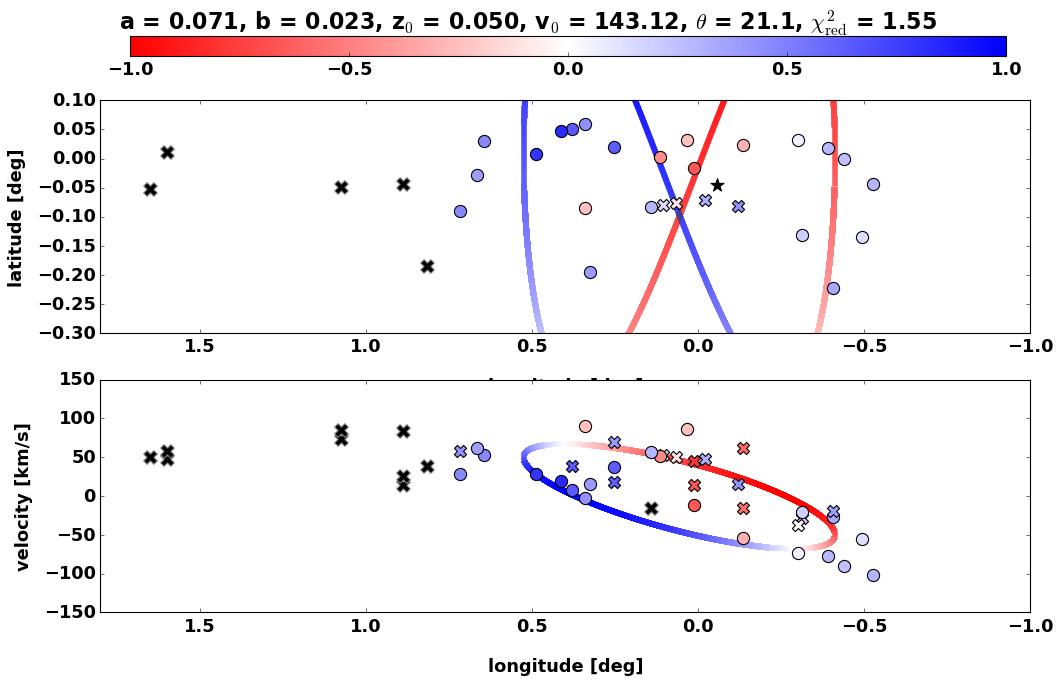

35 35
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 352
    # data points      = 22
    # variables        = 5
    chi-square         = 26.2191073
    reduced chi-square = 1.54230043
    Akaike info crit   = 13.8598115
    Bayesian info crit = 19.3150238
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07198213 (init = 0.035)
    b_rings:      0.02495104 (init = 0.02135)
    z_rings:      0.04999328 (init = 0.0125)
    v_rings:      136.591510 (init = 130)
    theta_rings:  22.4355786 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.28980384] [-0.21675916]
[0.36630612] [-0.25991377] [1.] [-1.]
NICE FIT!


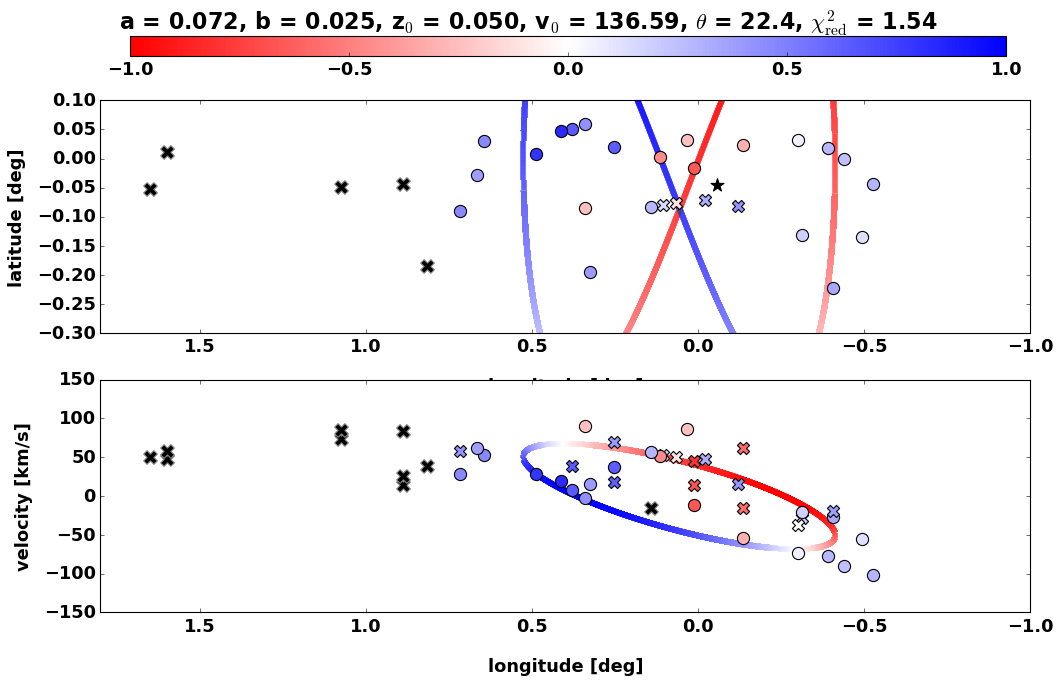

40 40
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 445
    # data points      = 22
    # variables        = 5
    chi-square         = 26.2872299
    reduced chi-square = 1.54630764
    Akaike info crit   = 13.9168979
    Bayesian info crit = 19.3721102
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07121334 (init = 0.04)
    b_rings:      0.02292820 (init = 0.0244)
    z_rings:      0.04999445 (init = 0.0125)
    v_rings:      144.504397 (init = 130)
    theta_rings:  20.9043882 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.3162954] [-0.2346968]
[0.37124137] [-0.26551228] [1.] [-1.]
NICE FIT!


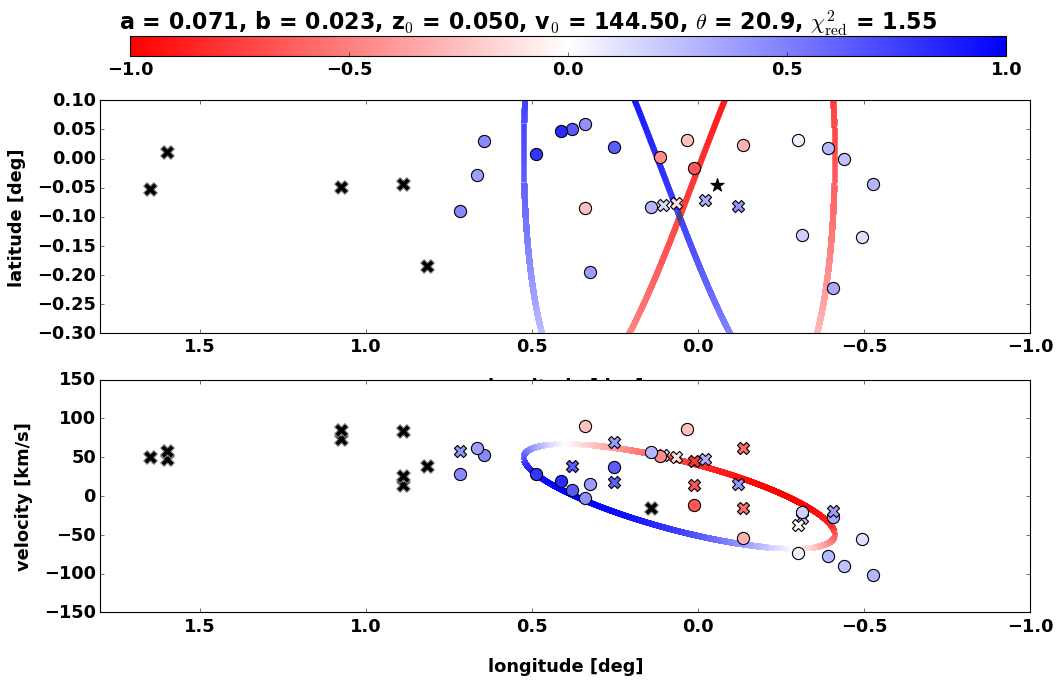

45 45
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 342
    # data points      = 22
    # variables        = 5
    chi-square         = 26.2826211
    reduced chi-square = 1.54603654
    Akaike info crit   = 13.9130404
    Bayesian info crit = 19.3682527
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07124911 (init = 0.045)
    b_rings:      0.02306126 (init = 0.02745)
    z_rings:      0.04999374 (init = 0.0125)
    v_rings:      144.014584 (init = 130)
    theta_rings:  20.9863762 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.31540255] [-0.2353327]
[0.37071953] [-0.26496644] [1.] [-1.]
NICE FIT!


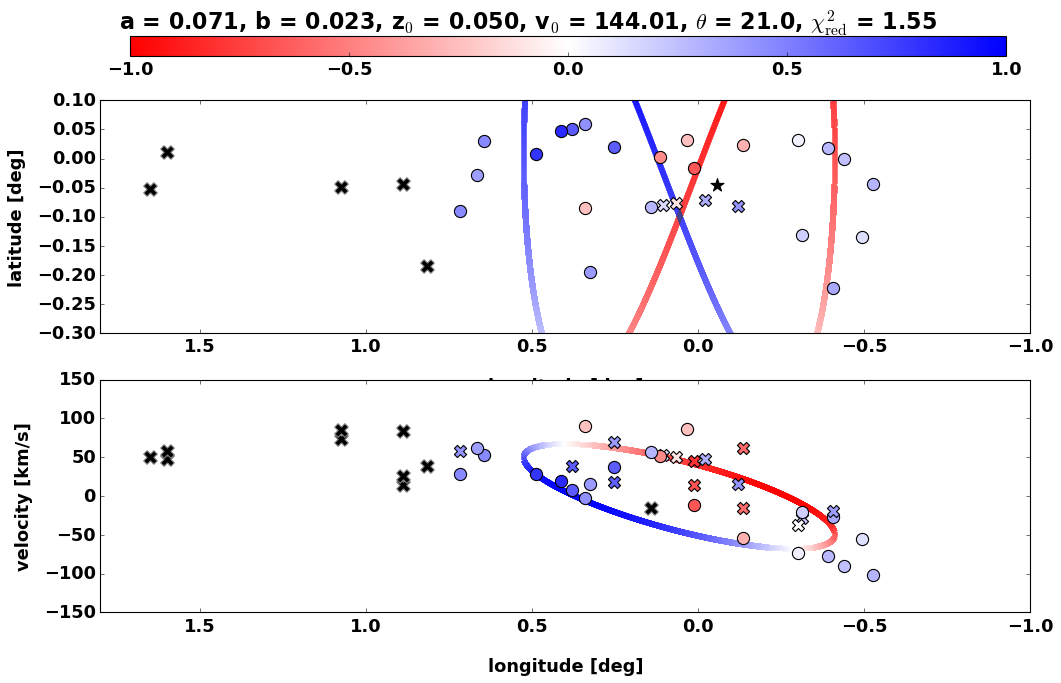

50 50
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 305
    # data points      = 22
    # variables        = 5
    chi-square         = 26.2621694
    reduced chi-square = 1.54483349
    Akaike info crit   = 13.8959145
    Bayesian info crit = 19.3511268
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07146618 (init = 0.05)
    b_rings:      0.02363315 (init = 0.0305)
    z_rings:      0.04999694 (init = 0.0125)
    v_rings:      141.772224 (init = 130)
    theta_rings:  21.3286513 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.31334981] [-0.23473765]
[0.36888119] [-0.26303394] [1.] [-1.]
NICE FIT!


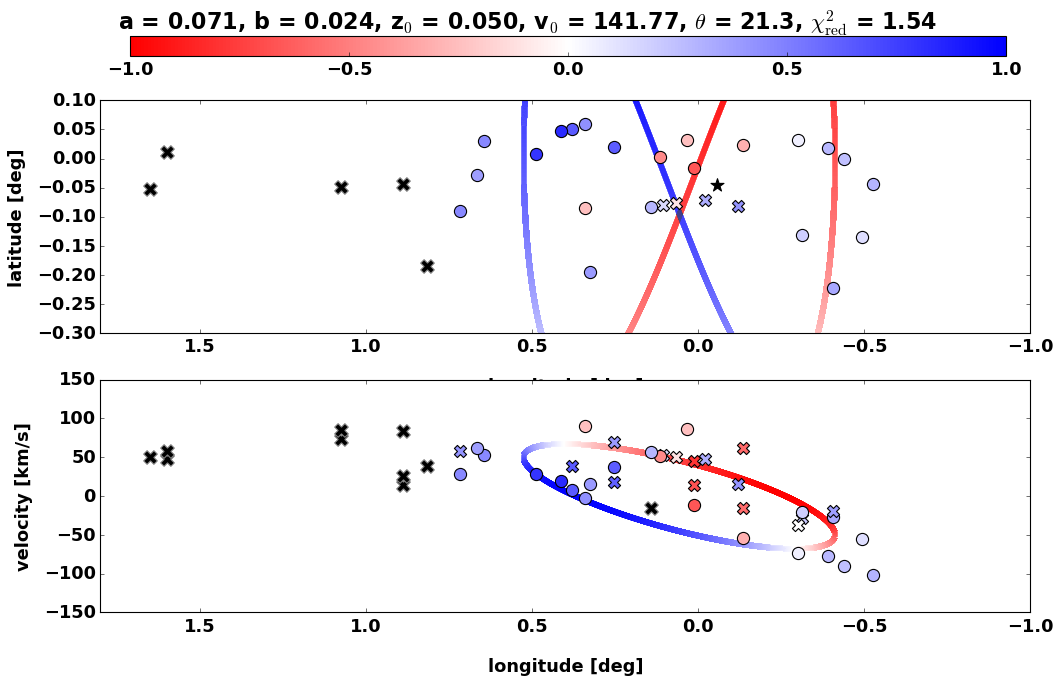

55 55
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 356
    # data points      = 22
    # variables        = 5
    chi-square         = 26.1905378
    reduced chi-square = 1.54061987
    Akaike info crit   = 13.8358263
    Bayesian info crit = 19.2910385
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07189726 (init = 0.055)
    b_rings:      0.02544275 (init = 0.03355)
    z_rings:      0.04999937 (init = 0.0125)
    v_rings:      133.422600 (init = 130)
    theta_rings:  23.2782298 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.26245436] [-0.1920246]
[0.36509568] [-0.25812344] [1.] [-1.]
NICE FIT!


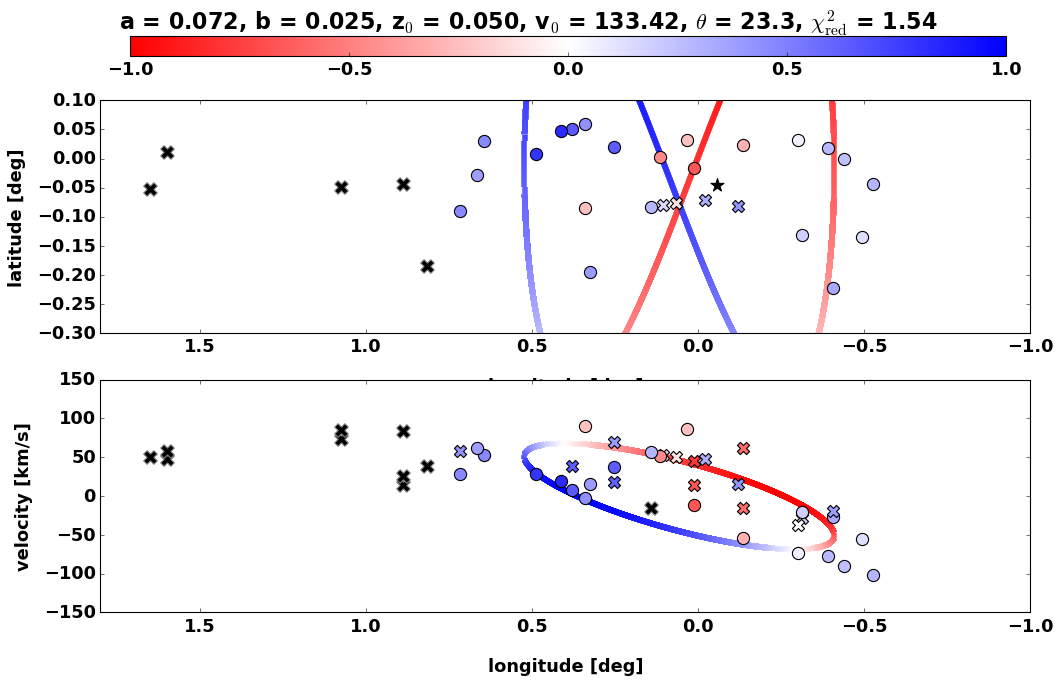

60 60
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 559
    # data points      = 22
    # variables        = 5
    chi-square         = 26.4307544
    reduced chi-square = 1.55475026
    Akaike info crit   = 14.0366880
    Bayesian info crit = 19.4919003
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07002659 (init = 0.06)
    b_rings:      0.02152185 (init = 0.0366)
    z_rings:      0.04912325 (init = 0.0125)
    v_rings:      144.282121 (init = 130)
    theta_rings:  21.3313827 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.23334099] [-0.1556109]
[0.37765437] [-0.27066113] [1.] [-1.]
NICE FIT!


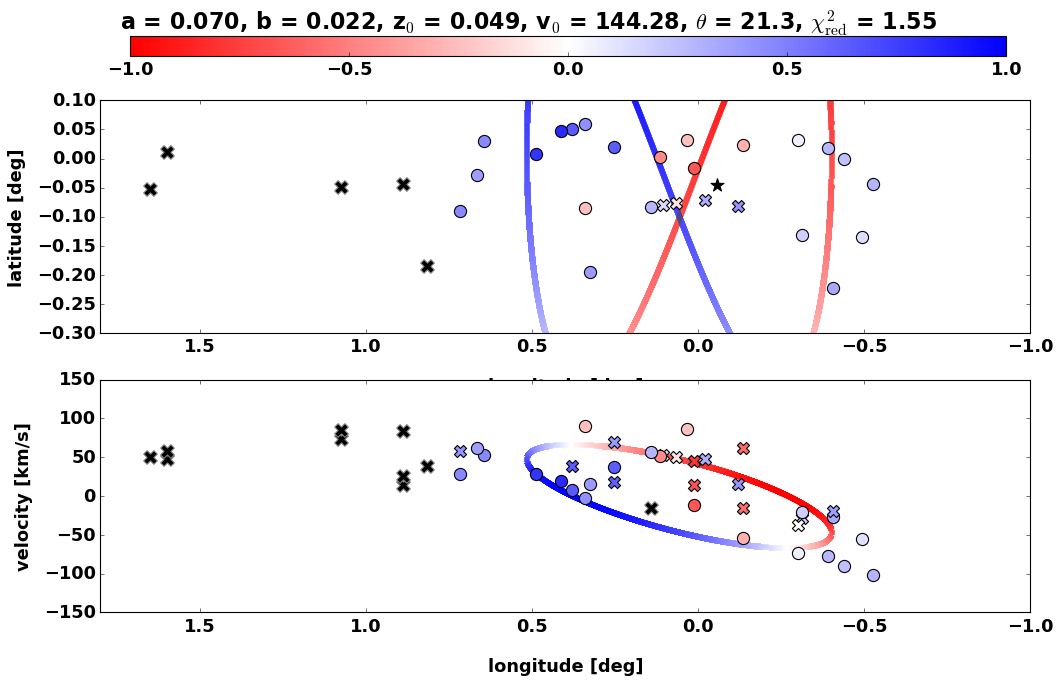

65 65
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 304
    # data points      = 22
    # variables        = 5
    chi-square         = 26.1677934
    reduced chi-square = 1.53928197
    Akaike info crit   = 13.8167127
    Bayesian info crit = 19.2719250
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07230703 (init = 0.065)
    b_rings:      0.02625060 (init = 0.03965)
    z_rings:      0.04999989 (init = 0.0125)
    v_rings:      131.004022 (init = 130)
    theta_rings:  23.8984764 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.25124285] [-0.18330332]
[0.3636755] [-0.2564509] [1.] [-1.]
NICE FIT!


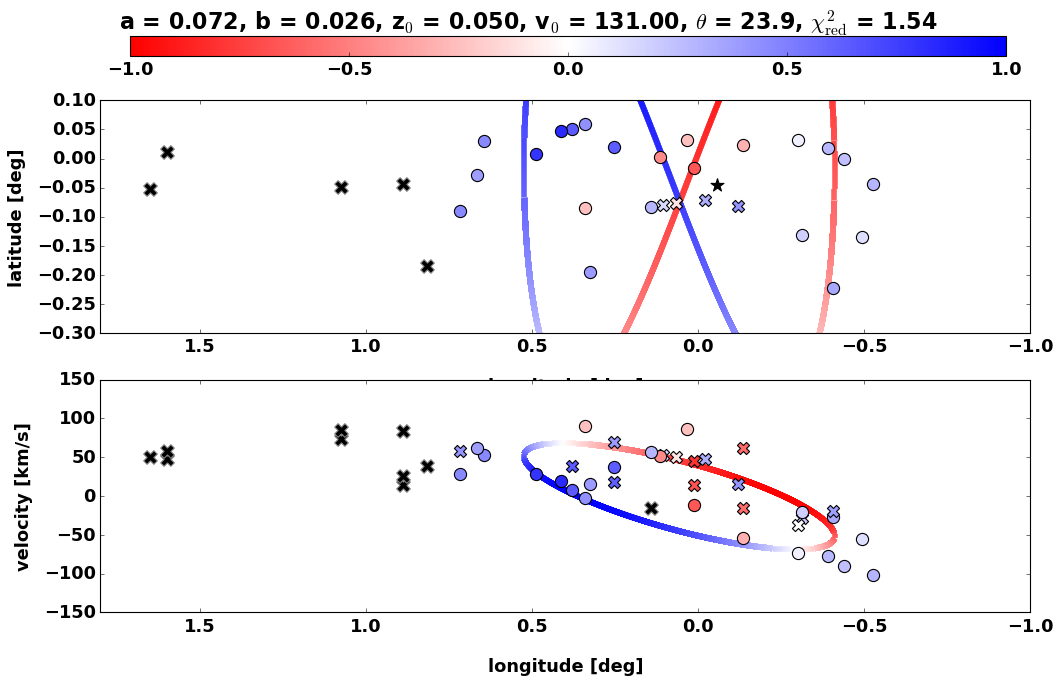

70 70
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 342
    # data points      = 22
    # variables        = 5
    chi-square         = 26.3188448
    reduced chi-square = 1.54816734
    Akaike info crit   = 13.9433407
    Bayesian info crit = 19.3985530
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07081098 (init = 0.07)
    b_rings:      0.02209635 (init = 0.0427)
    z_rings:      0.04999384 (init = 0.0125)
    v_rings:      147.683299 (init = 130)
    theta_rings:  20.4403733 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.31699057] [-0.23345545]
[0.37348544] [-0.26785009] [1.] [-1.]
NICE FIT!


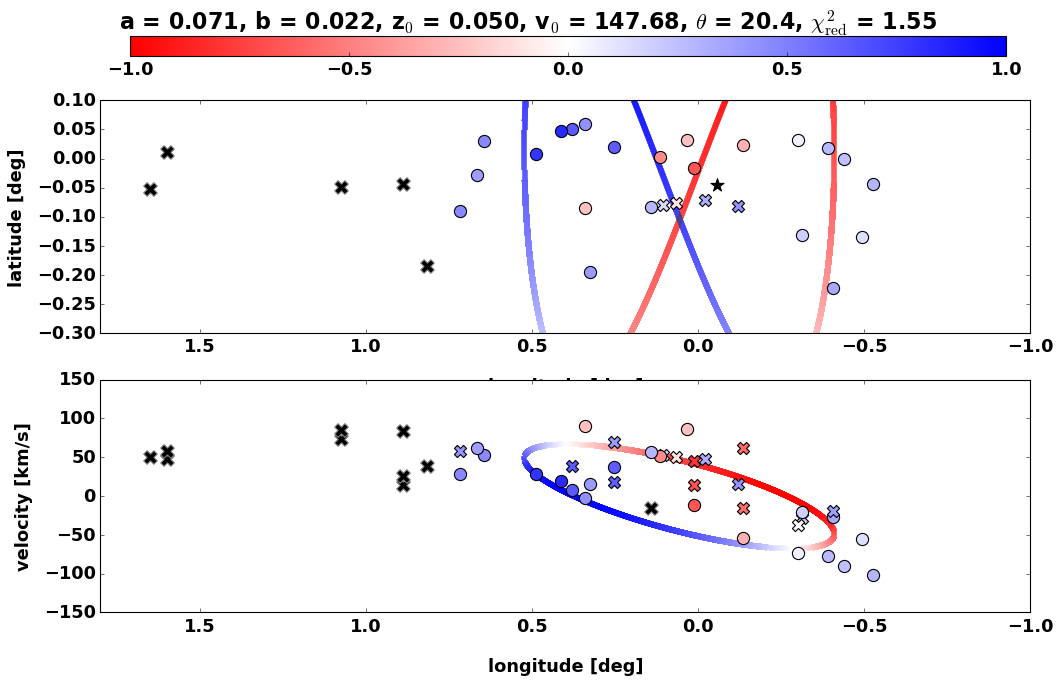

75 75
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 990
    # data points      = 22
    # variables        = 5
    chi-square         = 34.5167041
    reduced chi-square = 2.03039436
    Akaike info crit   = 19.9088205
    Bayesian info crit = 25.3640327
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.04159026 (init = 0.075)
    b_rings:      0.01285481 (init = 0.04575)
    z_rings:      0.03910779 (init = 0.0125)
    v_rings:      125.439130 (init = 130)
    theta_rings:  19.2842194 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.32330583] [-0.26816498]
[0.23991622] [-0.1317737] [1.] [-1.]
NICE FIT!


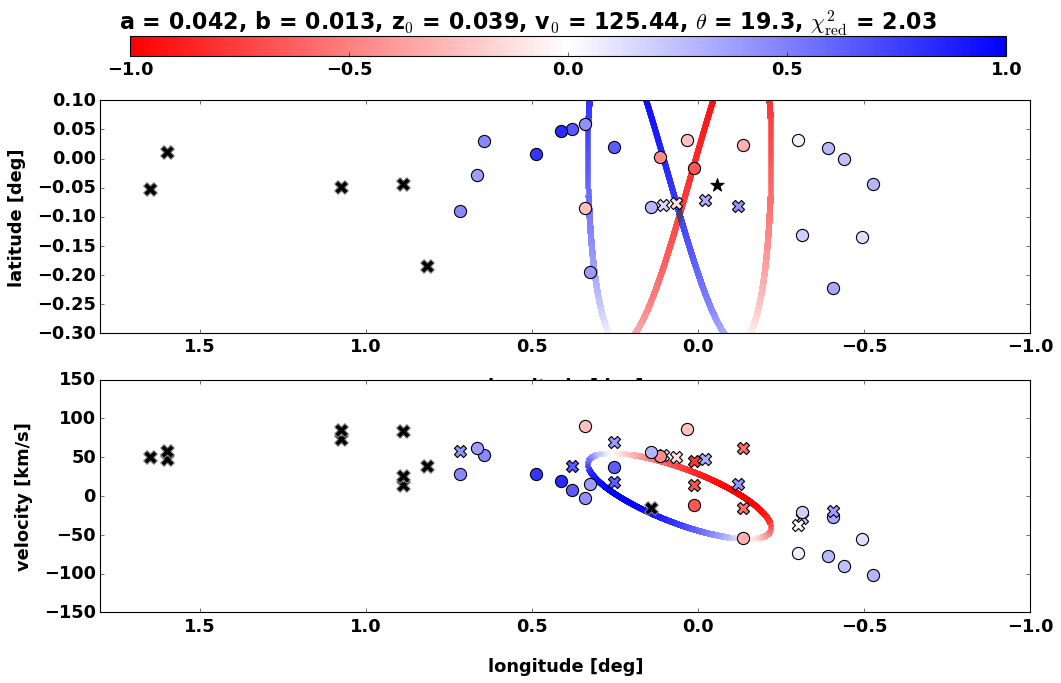

80 80
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 427
    # data points      = 22
    # variables        = 5
    chi-square         = 44.7335653
    reduced chi-square = 2.63138620
    Akaike info crit   = 25.6129967
    Bayesian info crit = 31.0682090
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07718109 (init = 0.08)
    b_rings:      0.05063453 (init = 0.0488)
    z_rings:      0.01433878 (init = 0.0125)
    v_rings:      130.246783 (init = 130)
    theta_rings:  22.3294436 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.04767076] [-0.0353856]
[0.20571098] [-0.09584767] [1.] [-1.]
NICE FIT!


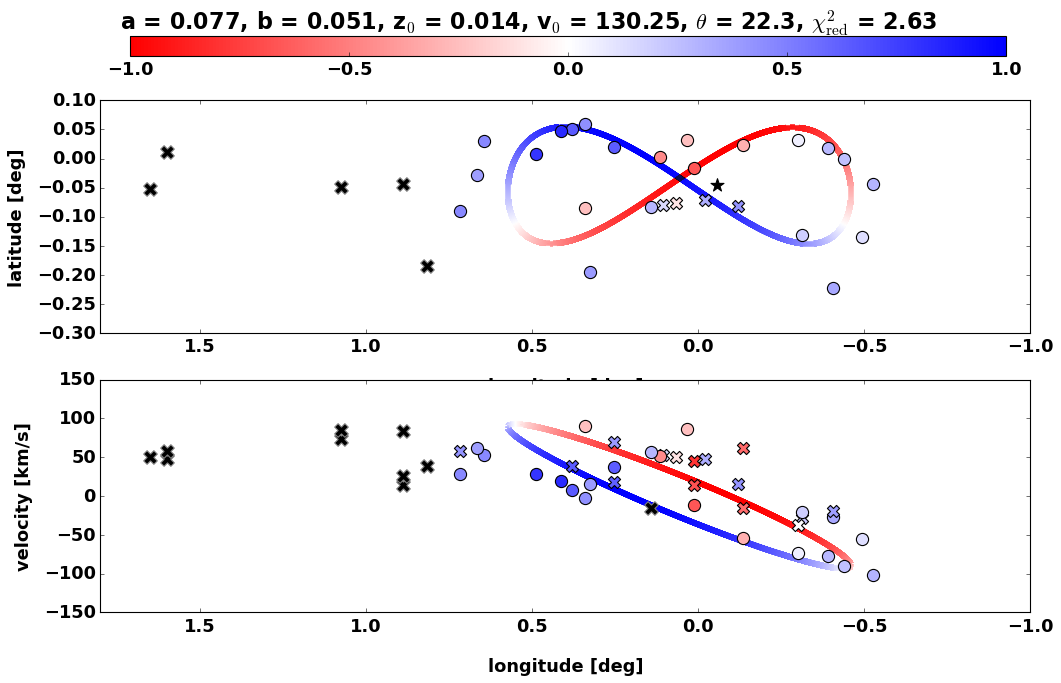

85 85
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 448
    # data points      = 22
    # variables        = 5
    chi-square         = 26.1340587
    reduced chi-square = 1.53729757
    Akaike info crit   = 13.7883327
    Bayesian info crit = 19.2435450
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07198272 (init = 0.085)
    b_rings:      0.02806889 (init = 0.05185)
    z_rings:      0.04999859 (init = 0.0125)
    v_rings:      122.905452 (init = 130)
    theta_rings:  25.2690259 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.24349097] [-0.18127173]
[0.35101218] [-0.24341175] [1.] [-1.]
NICE FIT!


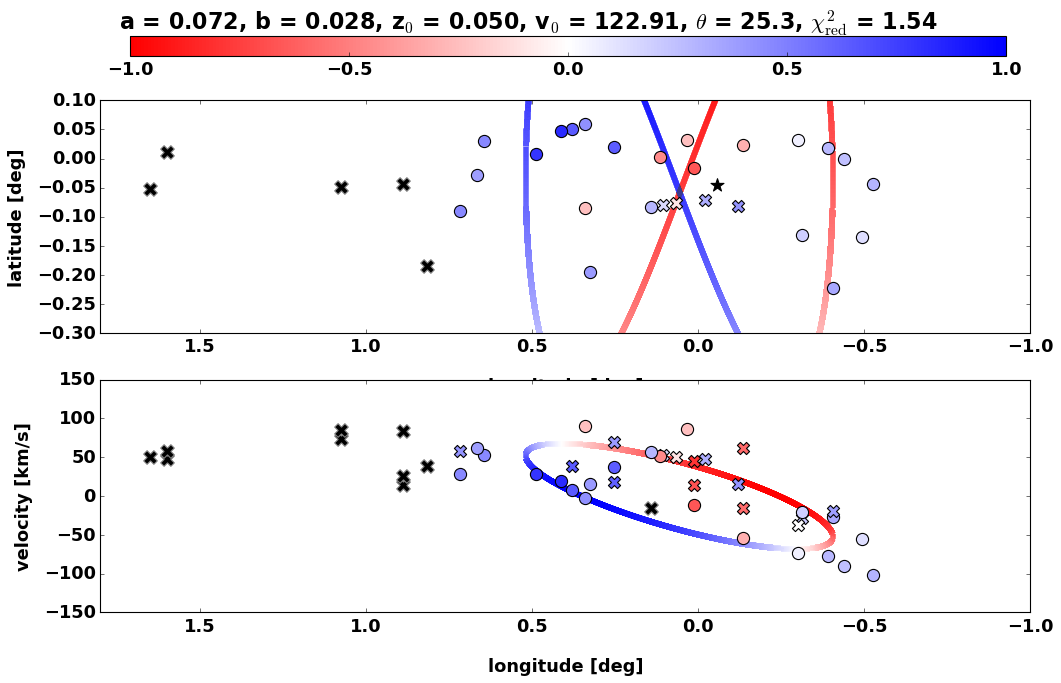

90 90
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 352
    # data points      = 22
    # variables        = 5
    chi-square         = 26.2202115
    reduced chi-square = 1.54236538
    Akaike info crit   = 13.8607380
    Bayesian info crit = 19.3159503
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07191567 (init = 0.09)
    b_rings:      0.02486371 (init = 0.0549)
    z_rings:      0.04999463 (init = 0.0125)
    v_rings:      136.745166 (init = 130)
    theta_rings:  22.3765494 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.29114137] [-0.21726262]
[0.36631157] [-0.25994337] [1.] [-1.]
NICE FIT!


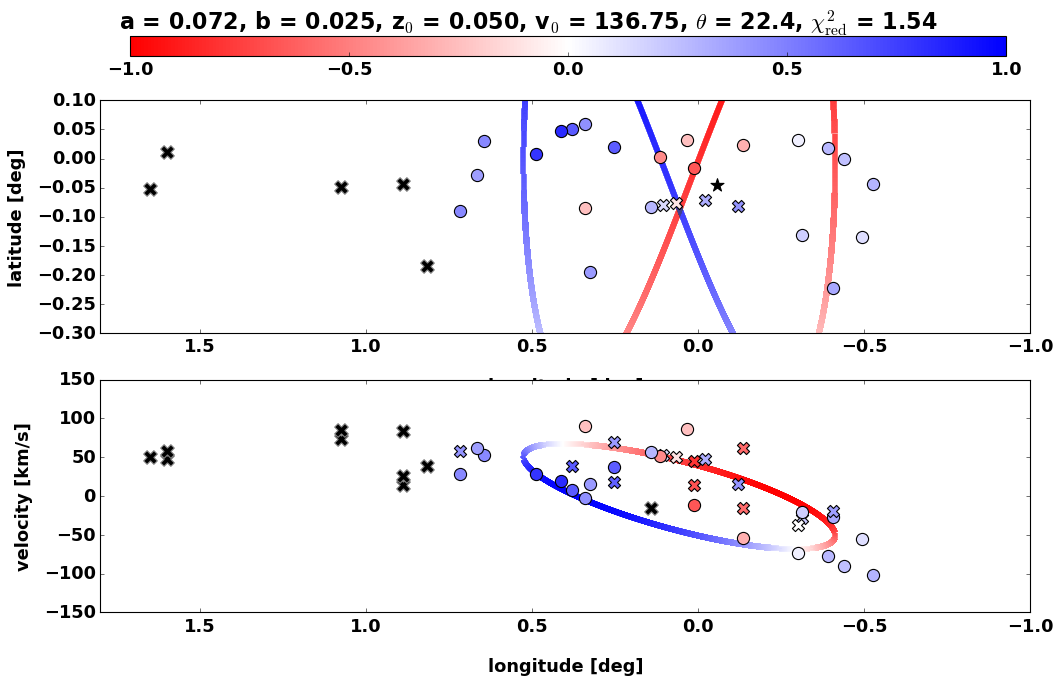

95 95
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 447
    # data points      = 22
    # variables        = 5
    chi-square         = 26.2102387
    reduced chi-square = 1.54177875
    Akaike info crit   = 13.8523688
    Bayesian info crit = 19.3075810
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07180508 (init = 0.095)
    b_rings:      0.02498239 (init = 0.05795)
    z_rings:      0.04999557 (init = 0.0125)
    v_rings:      135.577332 (init = 130)
    theta_rings:  22.7150789 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.27752576] [-0.20556832]
[0.36600218] [-0.25936098] [1.] [-1.]
NICE FIT!


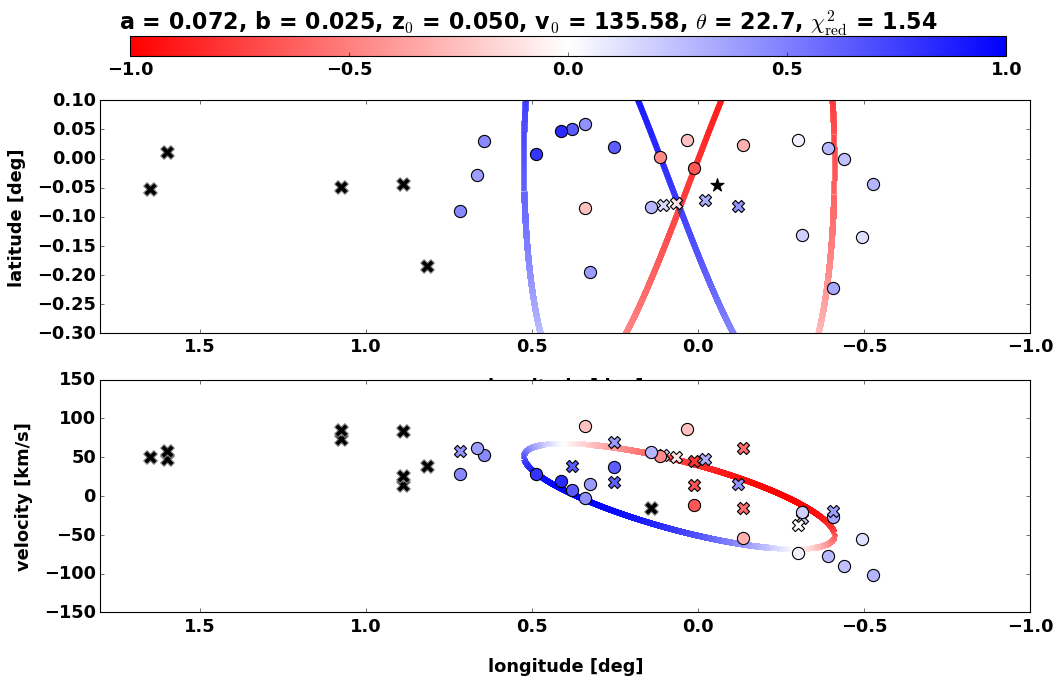

100 100
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 356
    # data points      = 22
    # variables        = 5
    chi-square         = 26.1790018
    reduced chi-square = 1.53994128
    Akaike info crit   = 13.8261339
    Bayesian info crit = 19.2813461
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07208536 (init = 0.1)
    b_rings:      0.02580999 (init = 0.061)
    z_rings:      0.04999843 (init = 0.0125)
    v_rings:      132.221161 (init = 130)
    theta_rings:  23.6653352 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.25210895] [-0.1831666]
[0.36489571] [-0.25771153] [1.] [-1.]
NICE FIT!


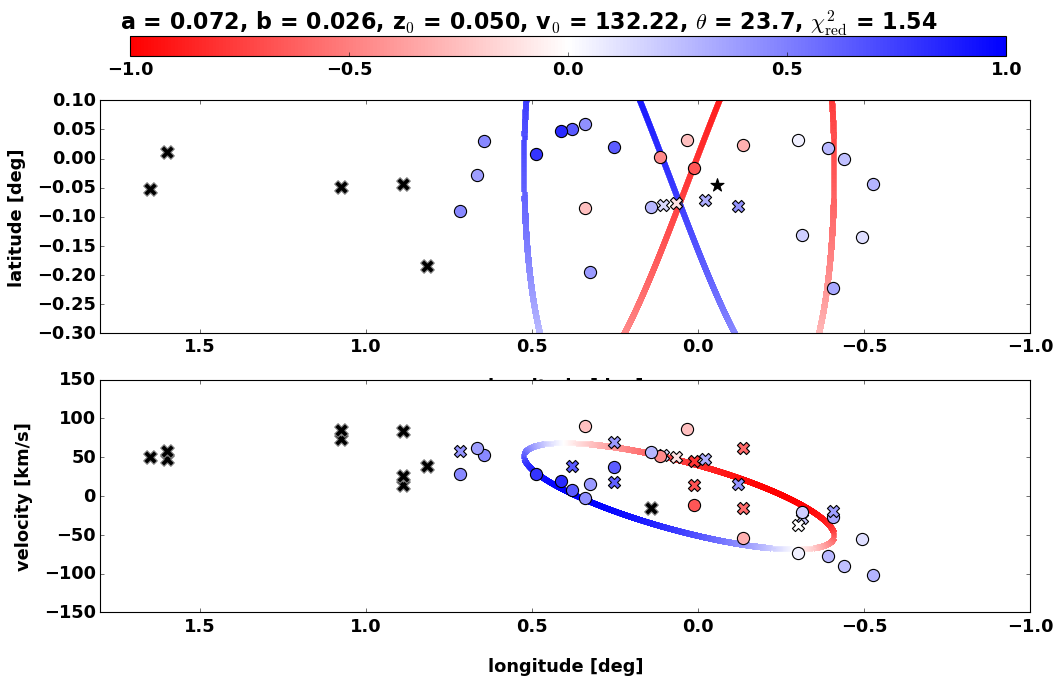

105 105
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 493
    # data points      = 22
    # variables        = 5
    chi-square         = 26.1305547
    reduced chi-square = 1.53709145
    Akaike info crit   = 13.7853828
    Bayesian info crit = 19.2405950
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07270818 (init = 0.105)
    b_rings:      0.02806318 (init = 0.06405)
    z_rings:      0.04999945 (init = 0.0125)
    v_rings:      124.863083 (init = 130)
    theta_rings:  25.0089768 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.246396] [-0.1841395]
[0.3554795] [-0.24801791] [1.] [-1.]
NICE FIT!


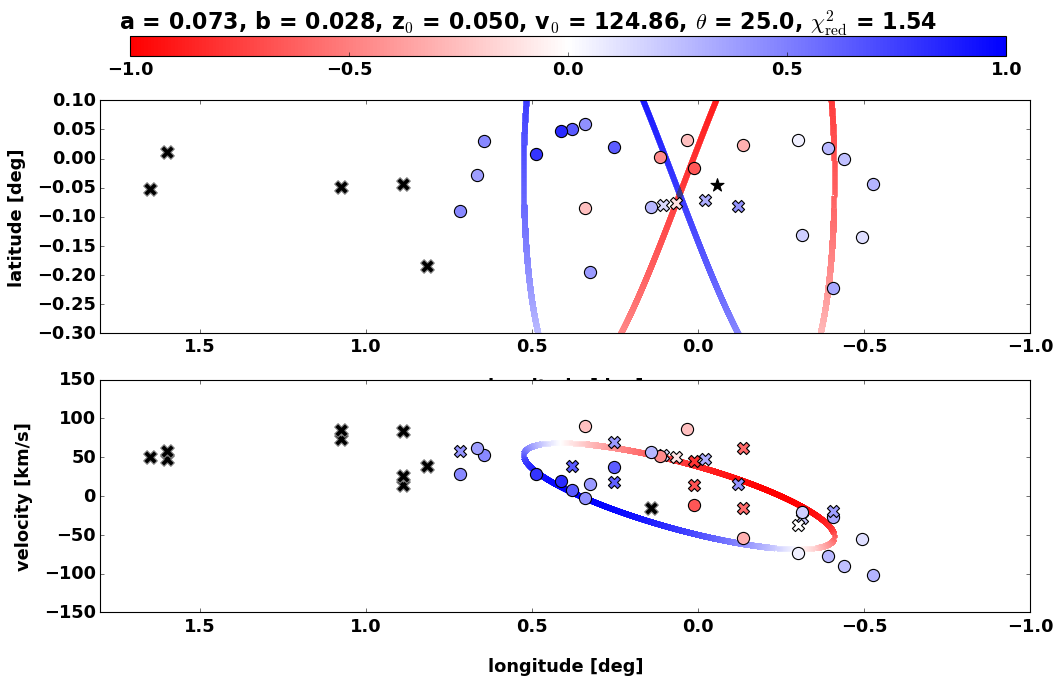

110 110
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 497
    # data points      = 22
    # variables        = 5
    chi-square         = 26.1900091
    reduced chi-square = 1.54058877
    Akaike info crit   = 13.8353822
    Bayesian info crit = 19.2905945
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07124931 (init = 0.11)
    b_rings:      0.02507934 (init = 0.0671)
    z_rings:      0.04999724 (init = 0.0125)
    v_rings:      132.930378 (init = 130)
    theta_rings:  23.3790181 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.25262077] [-0.18237061]
[0.36389031] [-0.25671142] [1.] [-1.]
NICE FIT!


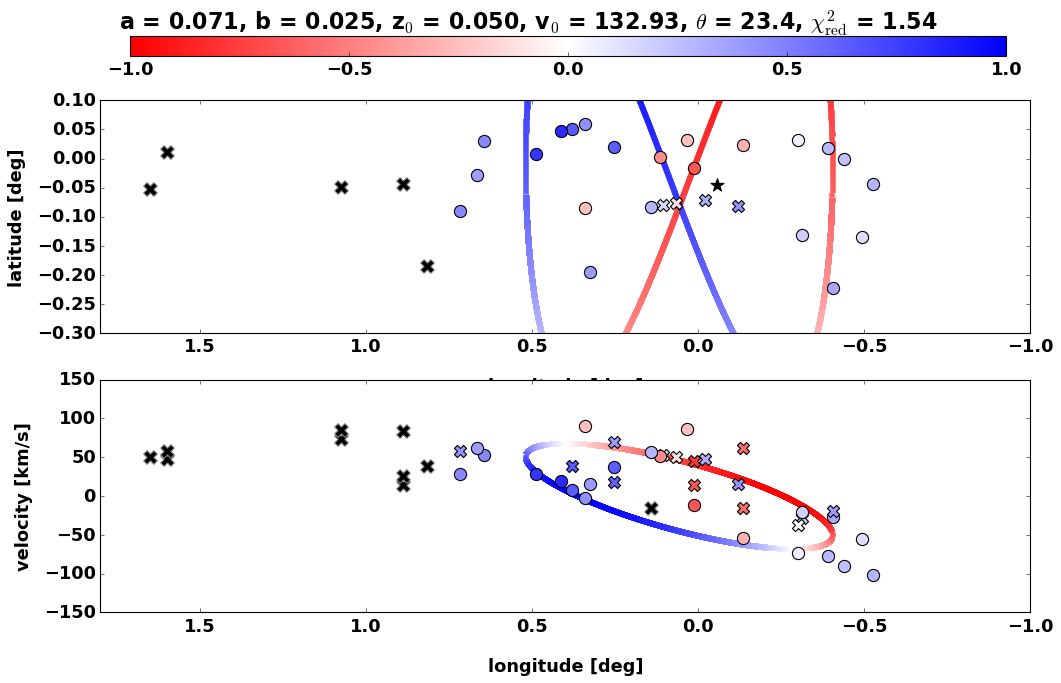

115 115
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 294
    # data points      = 22
    # variables        = 5
    chi-square         = 26.1607023
    reduced chi-square = 1.53886484
    Akaike info crit   = 13.8107503
    Bayesian info crit = 19.2659625
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.07218143 (init = 0.115)
    b_rings:      0.02630292 (init = 0.07015)
    z_rings:      0.04999981 (init = 0.0125)
    v_rings:      130.141751 (init = 130)
    theta_rings:  23.9842996 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.24948443] [-0.18248744]
[0.36264002] [-0.25537508] [1.] [-1.]
NICE FIT!


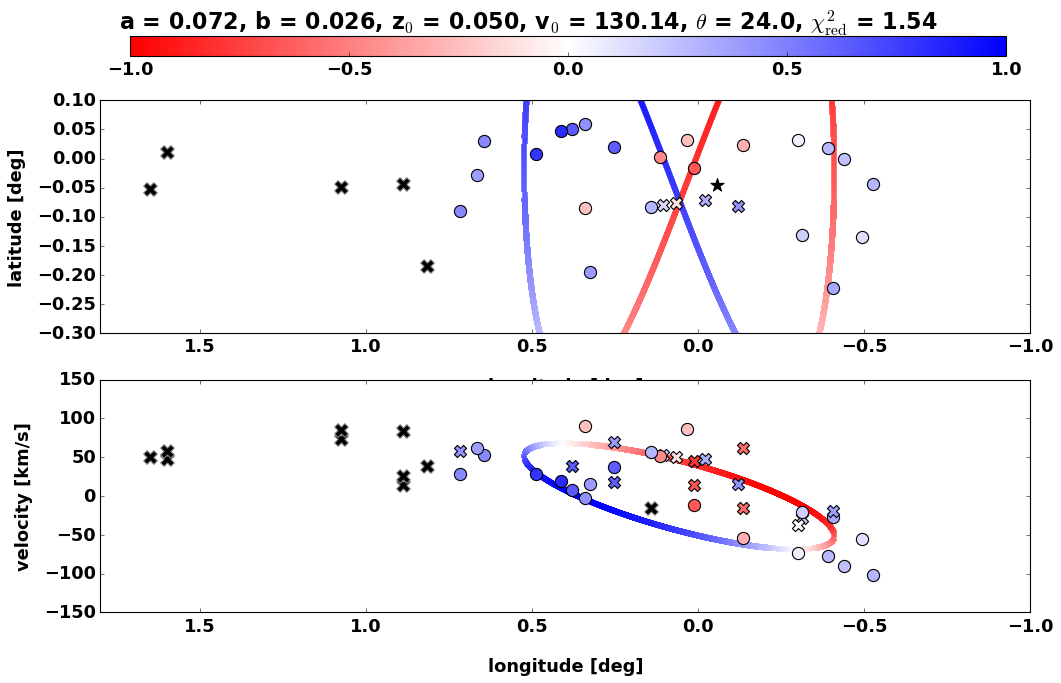

120 120
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 240
    # data points      = 22
    # variables        = 5
    chi-square         = 41.5285482
    reduced chi-square = 2.44285578
    Akaike info crit   = 23.9774502
    Bayesian info crit = 29.4326625
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.11818833 (init = 0.12)
    b_rings:      0.07718732 (init = 0.0732)
    z_rings:      0.01214782 (init = 0.0125)
    v_rings:      130.241469 (init = 130)
    theta_rings:  24.8219756 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.02972946] [-0.00976712]
[0.3026783] [-0.19415783] [1.] [-1.]
NICE FIT!


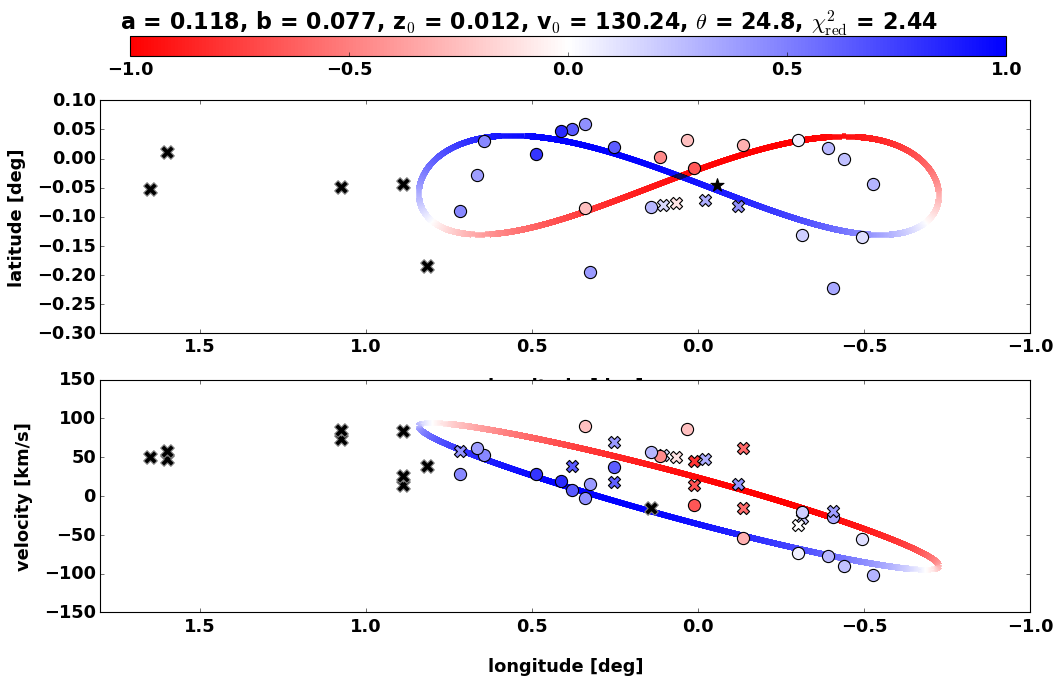

125 125
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 486
    # data points      = 22
    # variables        = 5
    chi-square         = 40.3131184
    reduced chi-square = 2.37135991
    Akaike info crit   = 23.3239586
    Bayesian info crit = 28.7791709
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.13567141 (init = 0.125)
    b_rings:      0.08634578 (init = 0.07625)
    z_rings:      0.01235039 (init = 0.0125)
    v_rings:      132.049885 (init = 130)
    theta_rings:  31.5099261 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.02687814] [-0.00072556]
[0.38817418] [-0.27893733] [1.] [-1.]
NICE FIT!


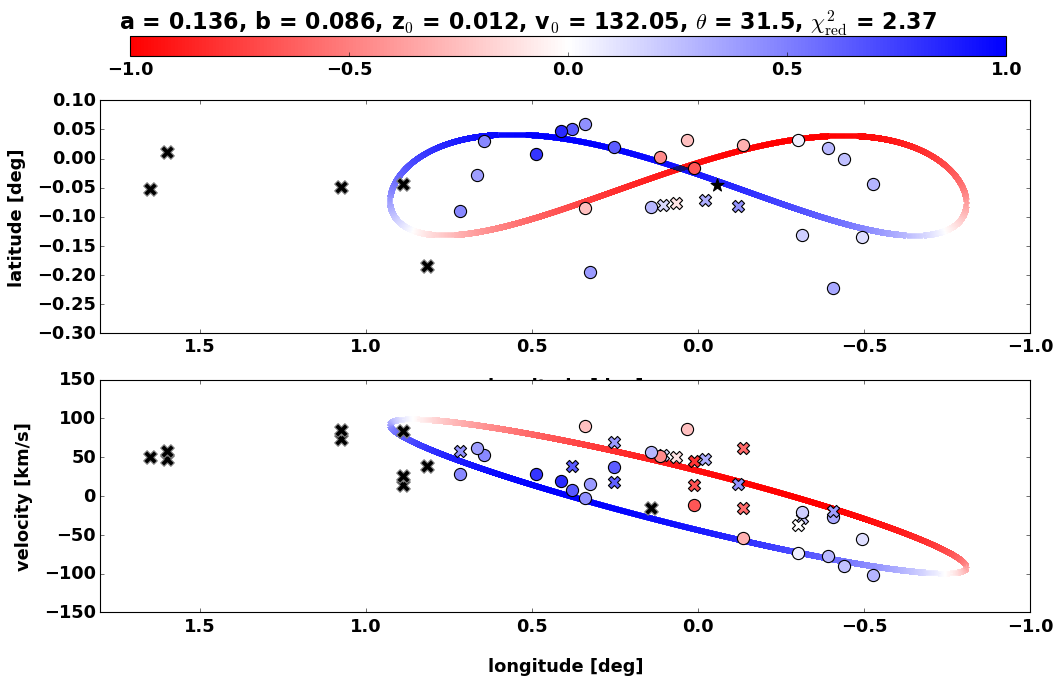

130 130
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 318
    # data points      = 22
    # variables        = 5
    chi-square         = 40.6027392
    reduced chi-square = 2.38839642
    Akaike info crit   = 23.4814477
    Bayesian info crit = 28.9366600
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.12517696 (init = 0.13)
    b_rings:      0.08175169 (init = 0.0793)
    z_rings:      0.01217787 (init = 0.0125)
    v_rings:      128.844593 (init = 130)
    theta_rings:  28.4283434 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.02912634] [-0.00655443]
[0.3359289] [-0.22703251] [1.] [-1.]
NICE FIT!


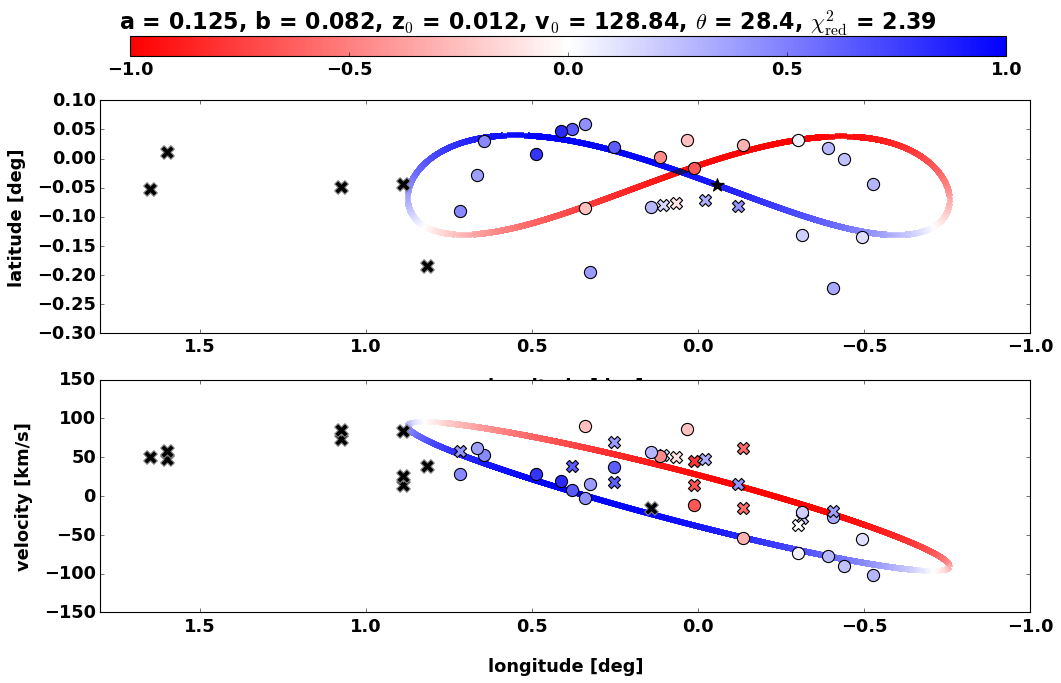

135 135
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 549
    # data points      = 22
    # variables        = 5
    chi-square         = 39.6285577
    reduced chi-square = 2.33109163
    Akaike info crit   = 22.9471663
    Bayesian info crit = 28.4023786
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.13049785 (init = 0.135)
    b_rings:      0.08440940 (init = 0.08235)
    z_rings:      0.01249701 (init = 0.0125)
    v_rings:      129.121055 (init = 130)
    theta_rings:  30.3450810 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.02741271] [-0.00327216]
[0.36166034] [-0.25253179] [1.] [-1.]
NICE FIT!


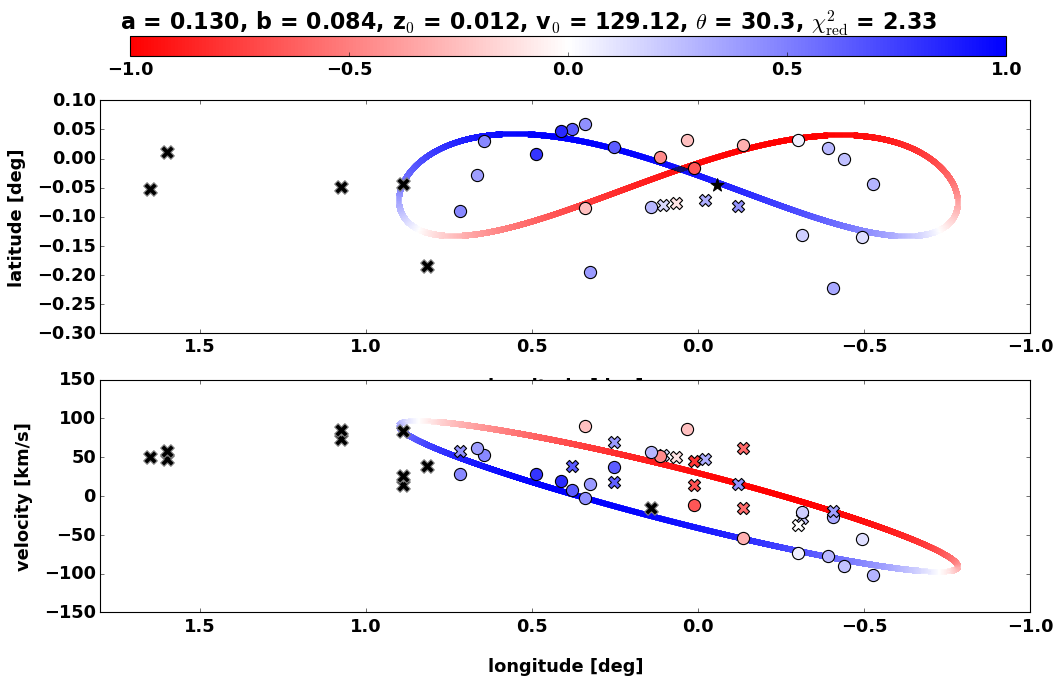

140 140
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 252
    # data points      = 22
    # variables        = 5
    chi-square         = 39.1737991
    reduced chi-square = 2.30434113
    Akaike info crit   = 22.6932450
    Bayesian info crit = 28.1484572
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.13703519 (init = 0.14)
    b_rings:      0.08572805 (init = 0.0854)
    z_rings:      0.01370365 (init = 0.0125)
    v_rings:      129.549281 (init = 130)
    theta_rings:  31.0919832 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.03066665] [-0.00190247]
[0.40078695] [-0.29184225] [1.] [-1.]
NICE FIT!


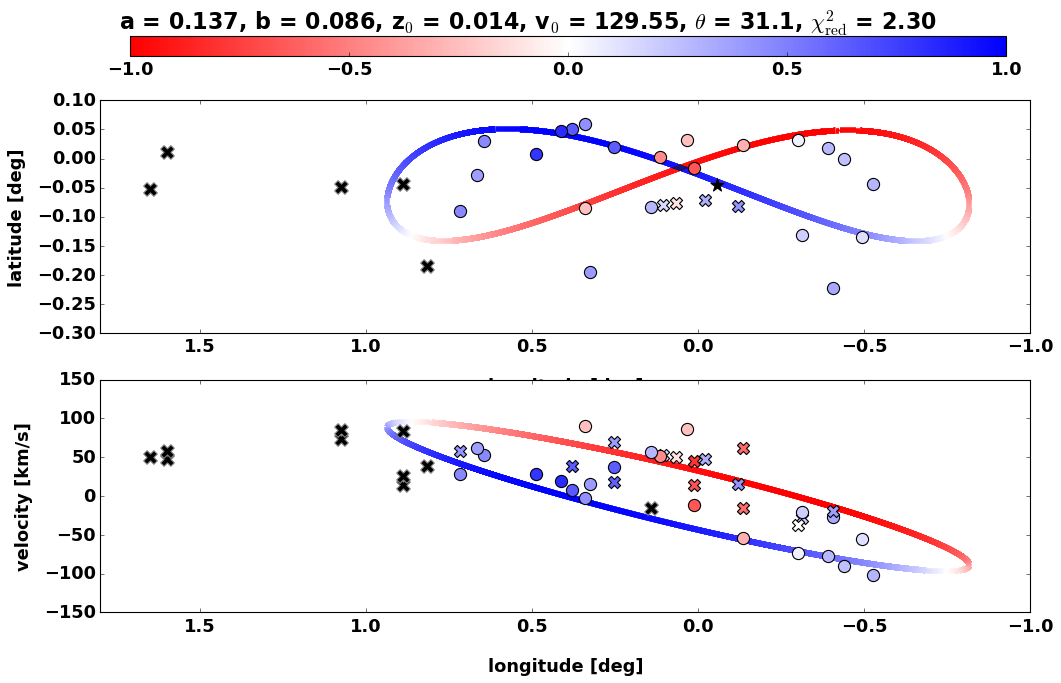

145 145
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 645
    # data points      = 22
    # variables        = 5
    chi-square         = 39.3402032
    reduced chi-square = 2.31412960
    Akaike info crit   = 22.7864995
    Bayesian info crit = 28.2417118
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.14415325 (init = 0.145)
    b_rings:      0.09059190 (init = 0.08845)
    z_rings:      0.01338873 (init = 0.0125)
    v_rings:      130.505394 (init = 130)
    theta_rings:  35.2132263 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.0246684] [0.00360538]
[0.42698748] [-0.3166836] [1.] [-1.]
NICE FIT!


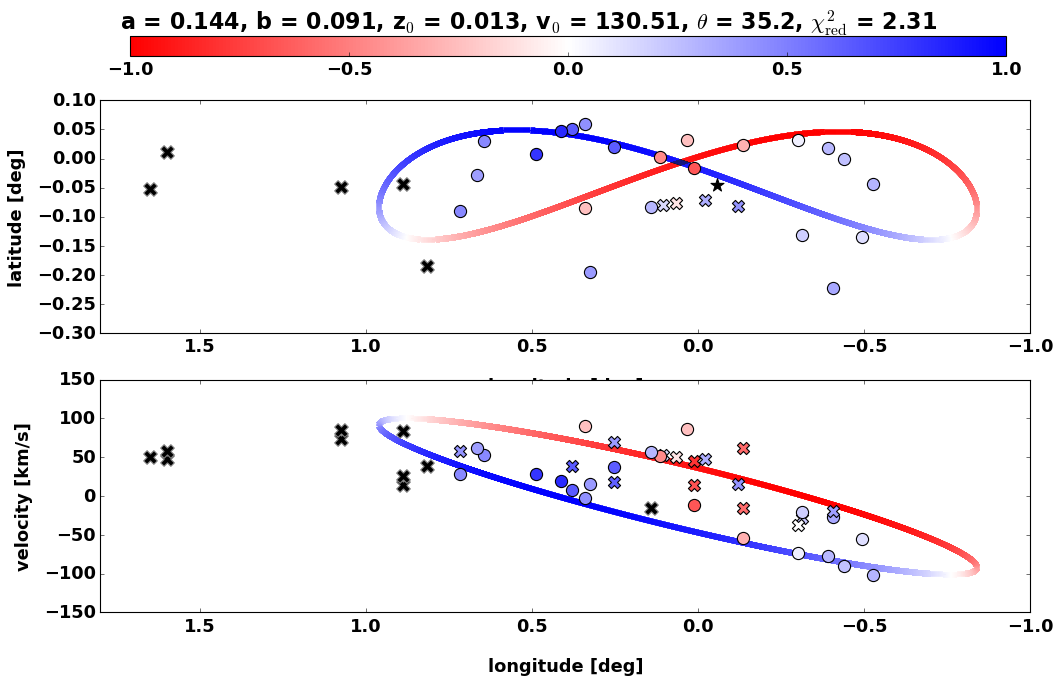

150 150
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 545
    # data points      = 22
    # variables        = 5
    chi-square         = 39.0755383
    reduced chi-square = 2.29856107
    Akaike info crit   = 22.6379924
    Bayesian info crit = 28.0932046
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.14977032 (init = 0.15)
    b_rings:      0.09777487 (init = 0.0915)
    z_rings:      0.01185819 (init = 0.0125)
    v_rings:      129.342316 (init = 130)
    theta_rings:  41.3531697 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.01786503] [0.01138018]
[0.41816006] [-0.30585783] [1.] [-1.]
NICE FIT!


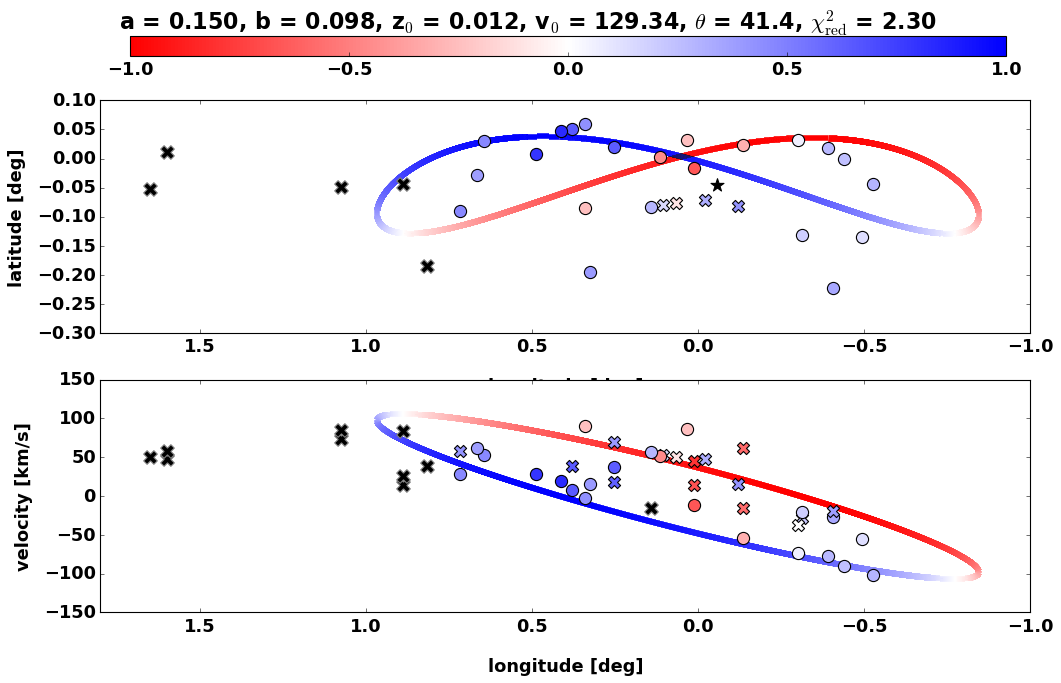

155 155
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 475
    # data points      = 22
    # variables        = 5
    chi-square         = 39.2758087
    reduced chi-square = 2.31034169
    Akaike info crit   = 22.7504591
    Bayesian info crit = 28.2056714
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.15558464 (init = 0.155)
    b_rings:      0.09976104 (init = 0.09455)
    z_rings:      0.01263191 (init = 0.0125)
    v_rings:      129.935662 (init = 130)
    theta_rings:  42.7375951 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[-0.01702205] [0.013108]
[0.44274243] [-0.32975725] [1.] [-1.]
NICE FIT!


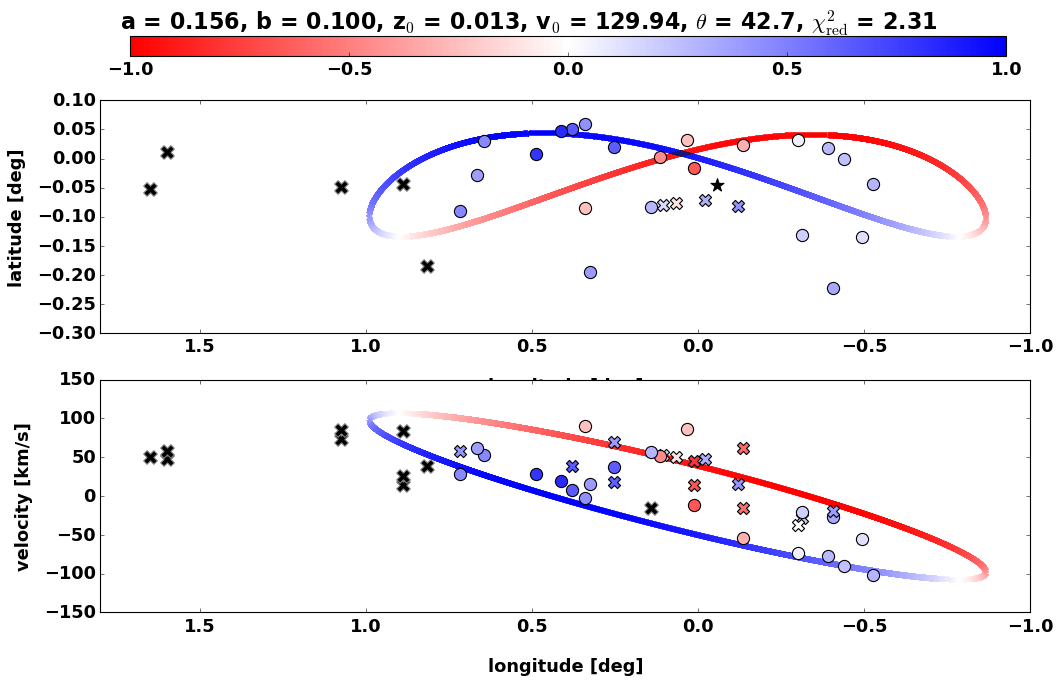

160 160
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 708
    # data points      = 22
    # variables        = 5
    chi-square         = 28.2531015
    reduced chi-square = 1.66194715
    Akaike info crit   = 15.5035373
    Bayesian info crit = 20.9587495
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.17080897 (init = 0.16)
    b_rings:      0.10129608 (init = 0.0976)
    z_rings:      0.01892640 (init = 0.0125)
    v_rings:      102.040248 (init = 130)
    theta_rings:  57.2554315 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[0.00505362] [0.03542078]
[0.45043283] [-0.33167439] [1.] [-1.]
NICE FIT!


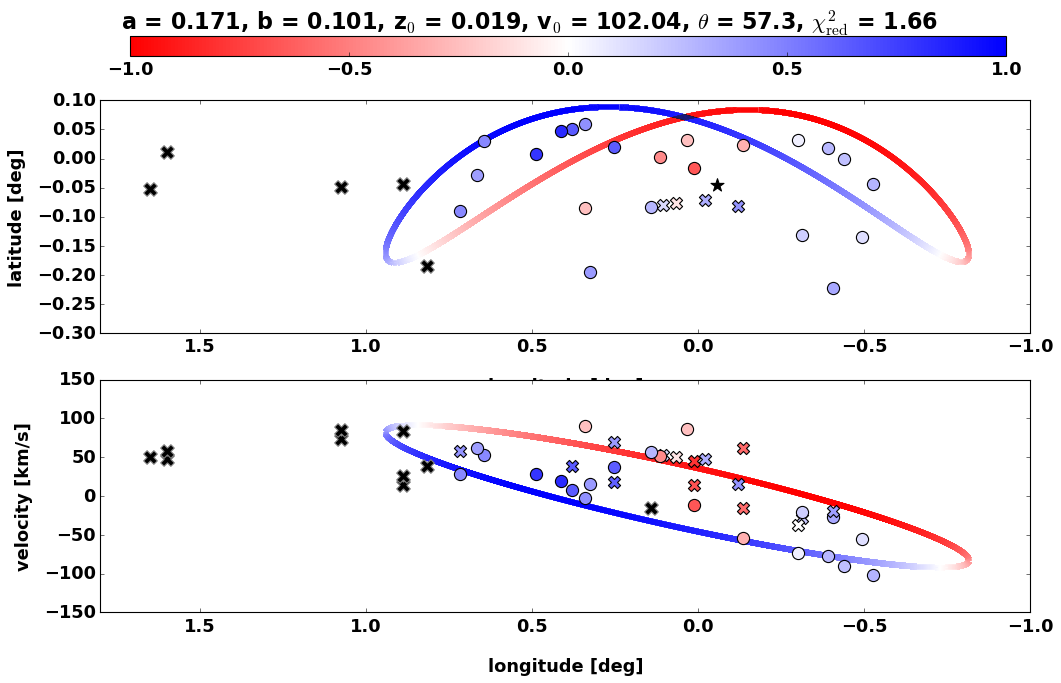

165 165
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 471
    # data points      = 22
    # variables        = 5
    chi-square         = 20.1642408
    reduced chi-square = 1.18613181
    Akaike info crit   = 8.08310312
    Bayesian info crit = 13.5383154
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.12611102 (init = 0.165)
    b_rings:      0.06430246 (init = 0.10065)
    z_rings:      0.04450716 (init = 0.0125)
    v_rings:      101.905315 (init = 130)
    theta_rings:  62.0108004 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[0.1775076] [0.19633817]
[0.35480956] [-0.23601091] [1.] [-1.]
NICE FIT!


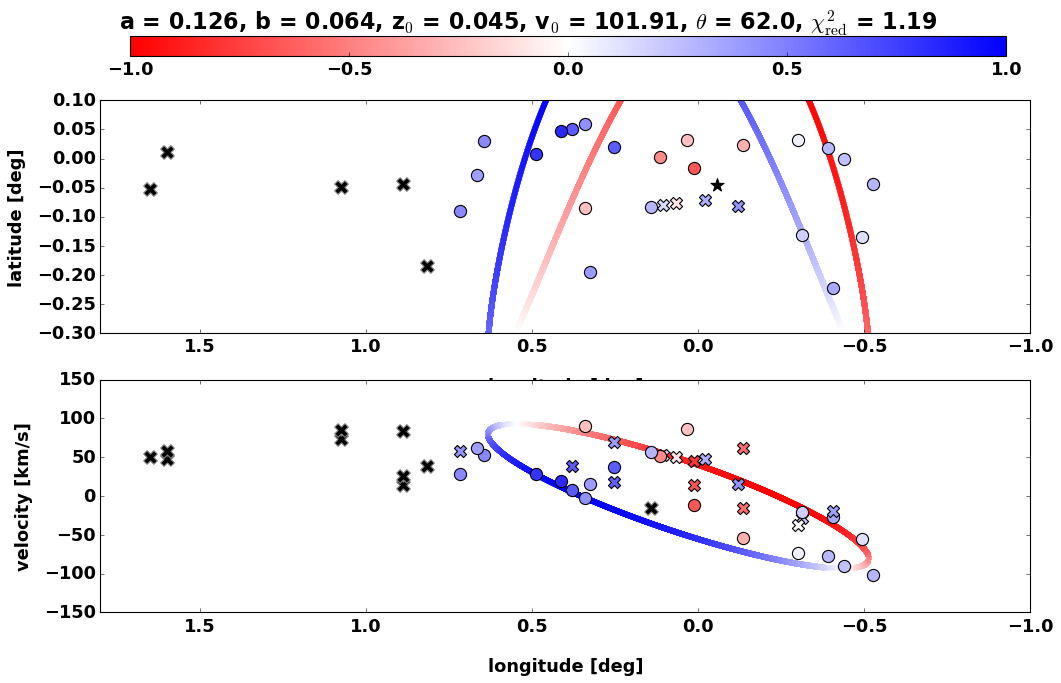

170 170
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 648
    # data points      = 22
    # variables        = 5
    chi-square         = 18.4655837
    reduced chi-square = 1.08621081
    Akaike info crit   = 6.14705657
    Bayesian info crit = 11.6022688
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a_rings:      0.24159056 (init = 0.17)
    b_rings:      0.07459488 (init = 0.1037)
    z_rings:      0.04998508 (init = 0.0125)
    v_rings:      100.014521 (init = 130)
    theta_rings:  79.3474723 (init = 25)
    alpha_rings:  0.4 (fixed)
    ddphi:        0.001 (fixed)
[0.10012121] [0.11531652]
[0.34577072] [-0.21830978] [1.] [-1.]
NICE FIT!


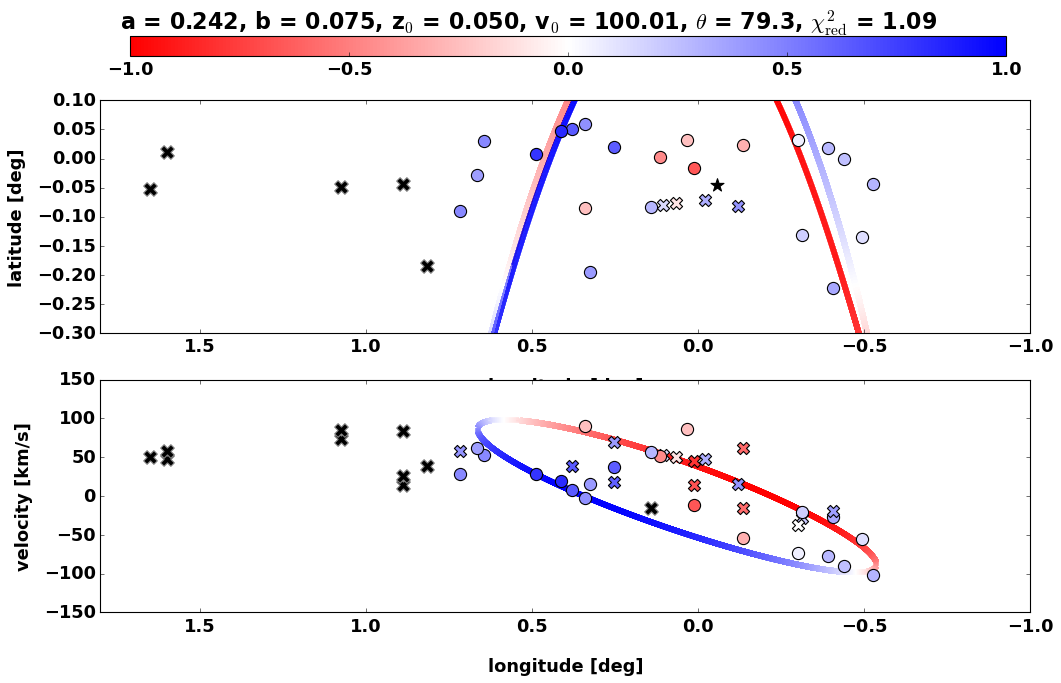

175 175


KeyboardInterrupt: 

In [333]:
agrid = np.arange(10, 305, 5)
bgrid = np.arange(10, 305, 5)

grid_tab = Table()
r0, a_out, b_out, z_out, v_out, theta_out, alpha_out, redchisq = [], [], [], [], [], [],[], []

for i in range(len(agrid)):
    print(agrid[i],bgrid[i])

    params_GRID = create_params(a_rings={'value': agrid[i]/1e3   , 'min': 0.01, 'max': 0.3, 'vary': True},
                               b_rings={'value': (0.61*agrid[i])/1e3  , 'min': 0.01, 'max': 0.2, 'vary': True},
                               z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                               v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                               theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True},
                               #alpha_rings={'value': 0.3904+((((agrid[i]/1e3)-0.010)/0.005)*0.0006)  , 'min': -np.pi/2, 'max': np.pi/2, 'vary': True},
                               alpha_rings={'value': 0.4  , 'min': -np.pi/2, 'max': np.pi/2, 'vary': False},
                               ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                                  )
    
    out = minimize(ring_resid, params_GRID, method='nelder', args=(Ndata.l0,Ndata.b0,Ndata.v0))
    print(fit_report(out))
        
    #if (np.mean(Rings_out.vr[ring_NF_dist(Rings_out)[1]])<np.mean(Rings_out.vr[ring_NF_dist(Rings_out)[0]])):
    
    dphi = np.radians(0.001)
    phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)

    Rings_out = Ring(phi,
                      out.params['a_rings'].value,
                      out.params['b_rings'].value,
                      out.params['z_rings'].value,
                      out.params['v_rings'].value, 
                      np.radians(out.params['theta_rings'].value),
                      xyzsun,vxyzsun,
                      out.params['alpha_rings'].value)


#    N_cent_vr = Rings_out.vr[argmedian(np.degrees(Rings_out.l[ring_NF_dist(Rings_out)[1][0]]))]
#    F_cent_vr = Rings_out.vr[argmedian(np.degrees(Rings_out.l[ring_NF_dist(Rings_out)[0][0]]))]
    NN = np.where(ring_NF_dist(Rings_out)[2]==1)
    FF = np.where(ring_NF_dist(Rings_out)[2]==-1)

    print(Rings_out.vr[NN], Rings_out.vr[FF])

    print(np.degrees(Rings_out.l[NN]), np.degrees(Rings_out.l[FF]) , ring_NF_dist(Rings_out)[2][NN], ring_NF_dist(Rings_out)[2][FF])

#    N_rings_arr = Rings_out.l[ring_NF_dist(Rings_out)[1][0]]
#    N_cent_vr = Rings_out.vr[argmedian(N_rings_arr[np.where((np.degrees(N_rings_arr)>0) )[0]])]

#    F_rings_arr = Rings_out.l[ring_NF_dist(Rings_out)[0][0]]
#    F_cent_vr = Rings_out.vr[argmedian(F_rings_arr[np.where((np.degrees(F_rings_arr)>0.) )[0]])]
    if (Rings_out.vr[NN]<Rings_out.vr[FF]) and (out.params['a_rings']>=out.params['b_rings']):
        print("NICE FIT!")
        lb_lv_plots_postcolor_grad(Rings_out, out)
        
        r0.append(agrid[i])
        a_out.append(out.params['a_rings'].value)
        b_out.append(out.params['b_rings'].value)
        z_out.append(out.params['z_rings'].value)
        v_out.append(out.params['v_rings'].value)
        theta_out.append(out.params['theta_rings'].value)
        alpha_out.append(out.params['alpha_rings'].value)
        redchisq.append(out.redchi)
    else:
        print("DISREGARDED FIT")
        lb_lv_plots_postcolor_grad(Rings_out, out)

In [ ]:
#N_cent_vr = Rings_out.vr[np.argmin(abs(Rings_out.l[ring_NF_dist(Rings_out)[1][0]]))]
#F_cent_vr = Rings_out.vr[np.argmin(abs(Rings_out.l[ring_NF_dist(Rings_out)[0][0]]))]
NN = np.where(ring_NF_dist(Rings_out)[2]==1)
FF = np.where(ring_NF_dist(Rings_out)[2]==-1)

print(Rings_out.vr[NN], Rings_out.vr[FF])
np.degrees(Rings_out.l[NN]), np.degrees(Rings_out.l[FF]), ring_NF_dist(Rings_out)[2][NN], ring_NF_dist(Rings_out)[2][FF]

[-0.00129442] [-0.02049355]


(array([-0.17797083]), array([0.2909941]), array([1.]), array([-1.]))

In [ ]:
Rings_out.vr[np.argmin(ring_NF_dist(Rings_out)[2])], Rings_out.vr[np.argmin(ring_NF_dist(Rings_out)[2])]
ring_NF_dist(Rings_out)[0][0]

array([     0,      1,      2, ..., 359997, 359998, 359999],
      shape=(180927,))

# Chisq Plots

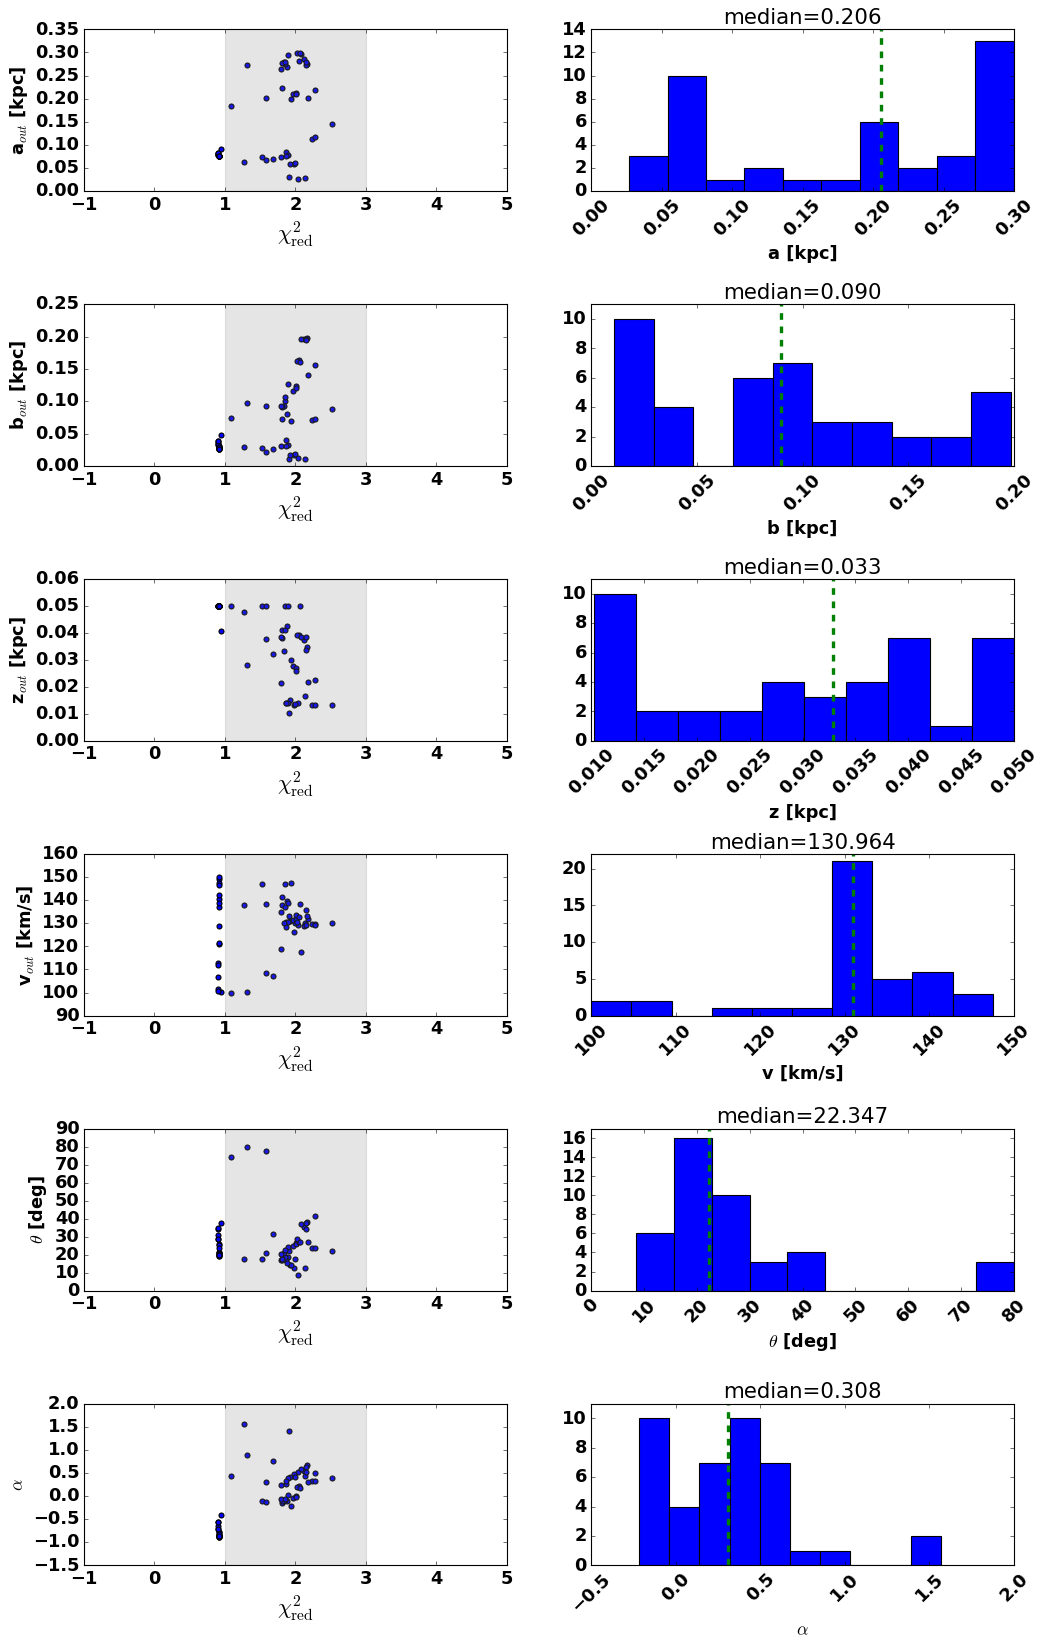

In [ ]:
fig, ax = plt.subplots(6, 2,  figsize=(15, 24))
fig.set_facecolor('white')
plt.subplots_adjust(hspace=0.7)

output_params = [a_out, b_out, z_out, v_out, theta_out, alpha_out]
output_param_name = ['a [kpc]', 'b [kpc]', 'z [kpc]', 'v [km/s]', r'$\theta$ [deg]', r'$\alpha$']

# Define redchisq bin masks
redchisq = np.asarray(redchisq)  # ensure it's a NumPy array
bins = [
    #(redchisq <= 12),                          # 10–12
    (redchisq > 1) & (redchisq <= 3),        # 12–14
    #(redchisq > 14) & (redchisq <= 16)         # 14–16
]
bin_labels = [
    #'10 < redchisq < 12',
    '1 < redchisq < 3',
    #'14 < redchisq < 16'
]


ax[0][0].scatter(redchisq, a_out)
ax[1][0].scatter(redchisq, b_out)
ax[2][0].scatter(redchisq, z_out)
ax[3][0].scatter(redchisq, v_out)
ax[4][0].scatter(redchisq, theta_out)
ax[5][0].scatter(redchisq, alpha_out)


ax[0][0].set_ylabel(r'a$_{out}$ [kpc]')
ax[1][0].set_ylabel(r'b$_{out}$ [kpc]')
ax[2][0].set_ylabel(r'z$_{out}$ [kpc]')
ax[3][0].set_ylabel(r'v$_{out}$ [km/s]')
ax[4][0].set_ylabel(r'$\theta$ [deg]')
ax[5][0].set_ylabel(r'$\alpha$')

for axes in ax:

    axes[:][0].set_xlabel(r'$\chi_{\mathrm{red}}^{2}$', fontsize=20)
    #axes[:][0].axvspan(1, 3, alpha=0.2, color='grey',zorder=1)
    axes[:][0].axvspan(1, 3, alpha=0.2, color='grey',zorder=1)


# Loop through each parameter (rows)
for i in range(len(output_params)):


    param_array = np.asarray(output_params[i])
    mask = bins[0]
    hist_vals = param_array[mask]
        
    h = ax[i][1].hist(hist_vals, bins=10)
    median_val = np.median(hist_vals)
    
    ax[i][0].set_xlim(-1, 5)
    ax[i][1].axvline(median_val, color='g', linestyle='dashed', linewidth=3)
    ax[i][1].set_ylim(0, h[0].max() + 1)
    ax[i][1].set_title(f'median={median_val:.3f}')
    ax[i][1].set_xlabel(f'{output_param_name[i]}')
    ax[i][1].tick_params(axis='x', labelrotation=45)
#plt.savefig('./paper_items/Figs/redchisq_converge.pdf', bbox_inches='tight')

In [ ]:
# Locations of the bin edges 
for i in range(len(output_params)):


    param_array = np.asarray(output_params[i])
    mask = bins[0]
    hist_vals = param_array[mask]

    h, bedges = np.histogram(hist_vals, bins='auto')
    print(bedges[0],np.median(hist_vals), bedges[-1], np.std(hist_vals))

0.010214590563998208 0.13547289985743416 0.18923086437218778 0.046849510441042026
0.01002461689127389 0.0920933248423621 0.1364858213883266 0.038973532216517906
0.012701087303710688 0.015641911554046147 0.02885019474660433 0.0029940193037596746
100.49087478808394 128.08564947820702 137.76399053359623 5.560014187019663
7.5348426124513885 22.90549814829355 88.38478113593281 13.749604766654404
2.427588923998579e-06 0.11591223171566266 1.8833103294479232 0.3627489561051979


In [ ]:
hist_vals

array([19.04988267, 15.76431241, 16.78801419, 15.03450002, 15.73347417,
       15.02680651, 15.15986089, 15.05339445, 18.10983632, 20.30884002,
       16.93012246, 31.5434954 , 40.84057834, 40.73960409, 40.30244839,
       39.87936406, 45.46410574, 34.09647427, 34.10248284, 40.03365747,
       59.24542418, 32.82273661, 33.70442876, 43.98022069, 35.61418793,
       43.82508129, 42.20233099, 31.9502096 , 37.96637477, 36.69072505,
       36.31232256, 16.80886741, 35.1359918 , 36.1516418 ])

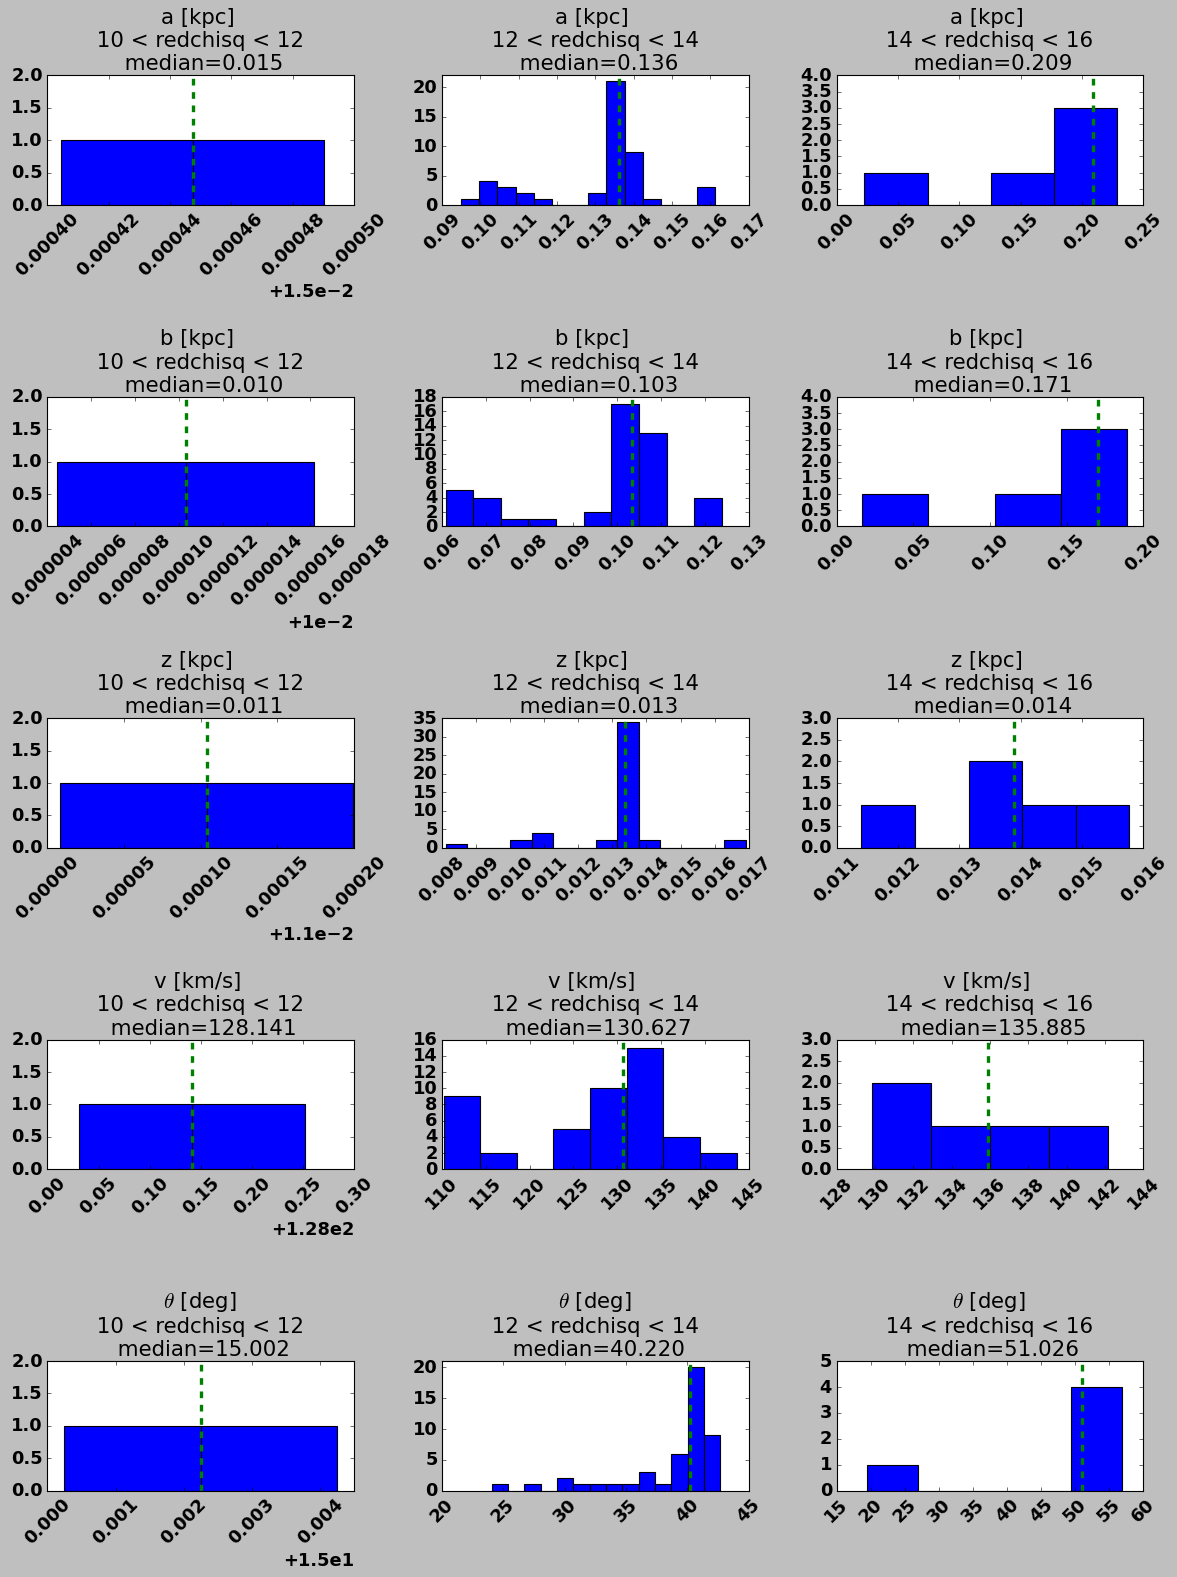

In [ ]:
# Create a single 5x3 grid of subplots
fig, axs = plt.subplots(5, 3, figsize=(15, 20))  # 5 rows (params), 3 cols (bins)
plt.subplots_adjust(wspace=0.4, hspace=0.2)

output_params = [a_out, b_out, z_out, v_out, theta_out]
output_param_name = ['a [kpc]', 'b [kpc]', 'z [kpc]', 'v [km/s]', r'$\theta$ [deg]']

# Define redchisq bin masks
redchisq = np.asarray(redchisq)  # ensure it's a NumPy array
bins = [
    (redchisq <= 12),                          # 10–12
    (redchisq > 12) & (redchisq <= 14),        # 12–14
    (redchisq > 14) & (redchisq <= 16)         # 14–16
]
bin_labels = [
    '10 < redchisq < 12',
    '12 < redchisq < 14',
    '14 < redchisq < 16'
]

# Loop through each parameter (rows)
for i in range(len(output_params)):
    param_array = np.asarray(output_params[i])
    
    # Loop through each redchisq bin (columns)
    for j in range(3):
        ax = axs[i, j]
        mask = bins[j]
        hist_vals = param_array[mask]
        
        h = ax.hist(hist_vals, bins='auto')
        median_val = np.median(hist_vals)
        
        ax.axvline(median_val, color='g', linestyle='dashed', linewidth=3)
        ax.set_ylim(0, h[0].max() + 1)
        ax.set_title(f'{output_param_name[i]} \n {bin_labels[j]} \n median={median_val:.3f}')
        ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.savefig('./paper_items/Figs/redchisq_converge.pdf', bbox_inches='tight')

In [ ]:
str(output)

'[np.float64(0.015404475138727407), np.float64(0.01549031882294138), np.float64(0.02274762675574269), np.float64(0.13898284227586538), np.float64(0.13167879153970705), np.float64(0.09499448260222942), np.float64(0.13543269258999507), np.float64(0.10331460459708092), np.float64(0.101759311873056), np.float64(0.10507681305883698), np.float64(0.10247836845105478), np.float64(0.10238770534847136), np.float64(0.10706836651253386), np.float64(0.10661328285899431), np.float64(0.11543772128656596), np.float64(0.13842812074295655), np.float64(0.13816182623217932), np.float64(0.13817655258776967), np.float64(0.1316425672911466), np.float64(0.1463503239623502), np.float64(0.1405746261764092), np.float64(0.13795972252467814), np.float64(0.13329971854297185), np.float64(0.13367222157515937), np.float64(0.15783668805107995), np.float64(0.13797829399903633), np.float64(0.13595920673259695), np.float64(0.13596140885414384), np.float64(0.13686823451813523), np.float64(0.13584600294564791), np.float64(0

In [ ]:
danya_tab = Table.read("/Users/danilipman/Downloads/xray_ill_clouds_distances_including_ALL_pixel_starcounts_09_26.tex")


In [ ]:
danya_tab[2:4]

<Table length=2>
Index  Name d_proj (pc) ... sigma$_{SC}$ (pc) sigma$_{tot}$ (pc)
 str1 str13   float64   ...       str10             str10       
----- ----- ----------- ... ----------------- ------------------
    c   Br1      17.225 ...               NaN          47.910000
    d   Br2      22.929 ...               NaN          65.861000

In [ ]:
float(danya_tab['sigma$_{tot}$'][2]) * 155

31.465000000000003

In [ ]:
Rings_avg = Ring(phi,
                  0.155 ,
                  0.117 ,
                  0.016 ,
                  129.8 , 
                  np.radians(33.8 ),
                  xyzsun,vxyzsun)

In [ ]:
denorm_sigma_value(float(danya_tab['sigma$_{tot}$'][3]),Rings_avg)*1000

0.12985836594075373 -0.13004674190618282 0.25990510784693655


np.float64(72.5135250892953)

In [ ]:

def denorm_sigma_value(NFsigma, Rings_out):

    minkpc =  8.2 - np.nanmin(Rings_out.r)
    maxkpc =  8.2 - np.nanmax(Rings_out.r)
    widthkpc = minkpc - maxkpc
    
    term1 = (NFsigma)
    term2 = widthkpc
    print(minkpc,maxkpc, widthkpc )
    
    real_sig = (term1*term2) 

    #returns the LOS distance on the ring from SgrA* in kpc
    return real_sig

In [ ]:
###redo projection so that it finds the width of the ring at that longitude....ugh...redo redo redo...